In [1]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [2]:
import numpy as np
import pickle
import h5py
import os
from collections import Counter

# === Load aligned spike and EMG data ===
x = np.load(r"dataset\Gabby\train_500\X_long.npy")[:, :, 100:900]
x_val = np.load(r"dataset\Gabby\validation\X_long.npy")[:, :, 100:900]
x_test = np.load(r"dataset\Gabby\test\X_long.npy")[:, :, 100:900]
X_all = np.concatenate([x, x_val, x_test], axis=0)  # [N, C, T]

with open("dataset/Gabby/train_500/y_emg_dict.pkl", "rb") as f:
    y_emg = pickle.load(f)
with open("dataset/Gabby/validation/y_emg_dict.pkl", "rb") as f:
    y_emg_val = pickle.load(f)
with open("dataset/Gabby/test/y_emg_dict.pkl", "rb") as f:
    y_emg_test = pickle.load(f)
Y_dict_all = y_emg + y_emg_val + y_emg_test

assert len(X_all) == len(Y_dict_all)

# === Count how often each muscle appears ===
muscle_counts = Counter()
for trial in Y_dict_all:
    muscle_counts.update(trial.keys())

num_trials = len(Y_dict_all)
muscle_presence_ratio = {muscle: count / num_trials for muscle, count in muscle_counts.items()}

# === Keep only muscles appearing in ≥95% of trials ===
threshold = 0.95
kept_muscles = sorted([m for m, r in muscle_presence_ratio.items() if r >= threshold])
print(f"✅ Kept {len(kept_muscles)} muscles (threshold={threshold})")

# === Filter trials to only those with complete EMG data for kept muscles ===
valid_indices = [
    i for i, trial in enumerate(Y_dict_all)
    if all(m in trial and trial[m].shape[0] == 1250 for m in kept_muscles)
]
print(f"✅ Retained {len(valid_indices)} trials with complete EMG for kept muscles")

# === Build filtered spike and EMG tensors ===
X_filtered = X_all[valid_indices]  # shape: [N, C, T]

def emg_dicts_to_tensor(y_dicts, muscles, emg_bins=1250):
    N = len(y_dicts)
    M = len(muscles)
    Y = np.zeros((N, M, emg_bins), dtype=np.float32)
    for i, trial in enumerate(y_dicts):
        for j, muscle in enumerate(muscles):
            trace = trial[muscle]
            Y[i, j, :] = trace - np.mean(trace[:100])  # baseline correction
    return Y[:, :, 100:900]  # match time axis with spike data

Y_filtered = emg_dicts_to_tensor([Y_dict_all[i] for i in valid_indices], kept_muscles)

assert X_filtered.shape[0] == Y_filtered.shape[0]

# === Shuffle trials before splitting ===
n_total = X_filtered.shape[0]
indices = np.arange(n_total)
np.random.seed(0)  # for reproducibility
np.random.shuffle(indices)

X_shuffled = X_filtered[indices]
Y_shuffled = Y_filtered[indices]

# === 80/20 train/val split ===
n_train = int(0.8 * n_total)

train_encod = X_shuffled[:n_train].transpose(0, 2, 1)  # spikes [N, T, C]
train_recon = Y_shuffled[:n_train].transpose(0, 2, 1)  # emg    [N, T, M]
valid_encod = X_shuffled[n_train:].transpose(0, 2, 1)
valid_recon = Y_shuffled[n_train:].transpose(0, 2, 1)

# === Save to HDF5 ===
save_path = "dataset/Chip/lfads_filtered"
os.makedirs(save_path, exist_ok=True)

with h5py.File(os.path.join(save_path, "lfads_spike_to_emg_filtered.h5"), "w") as f:
    f.create_dataset("train_encod_data", data=train_encod)
    f.create_dataset("train_recon_data", data=train_recon)
    f.create_dataset("valid_encod_data", data=valid_encod)
    f.create_dataset("valid_recon_data", data=valid_recon)

print("✅ Saved shuffled spike→EMG LFADS file: lfads_spike_to_emg_filtered.h5")



KeyboardInterrupt: 

In [ ]:
print('valid_encod.shape')
print(valid_encod.shape)


valid_encod.shape
(1360, 800, 152)


X shape: (6000, 152, 800) y shape: (6000,)
X_val shape: (600, 152, 800) y_val shape: (600,)
X_test shape: (600, 152, 800) y_test shape: (600,)
Muscle index mapping: {0: 'APL', 1: 'Bchrd', 2: 'ECR', 3: 'ECRB', 4: 'ECU', 5: 'ECUh', 6: 'ECUu', 7: 'ED23', 8: 'ED45', 9: 'EDC', 10: 'EPL', 11: 'FCR', 12: 'FCU', 13: 'FDI', 14: 'FDPr', 15: 'FDPu', 16: 'FDS', 17: 'Hypo', 18: 'Hypoth', 19: 'IO34', 20: 'PL', 21: 'Sup', 22: 'Thenar'}
y shape: (6000, 23, 800), y_mask shape: (6000, 23, 800)
y_val shape: (600, 23, 800), y_val_mask shape: (600, 23, 800)
y_test shape: (600, 23, 800), y_test_mask shape: (600, 23, 800)


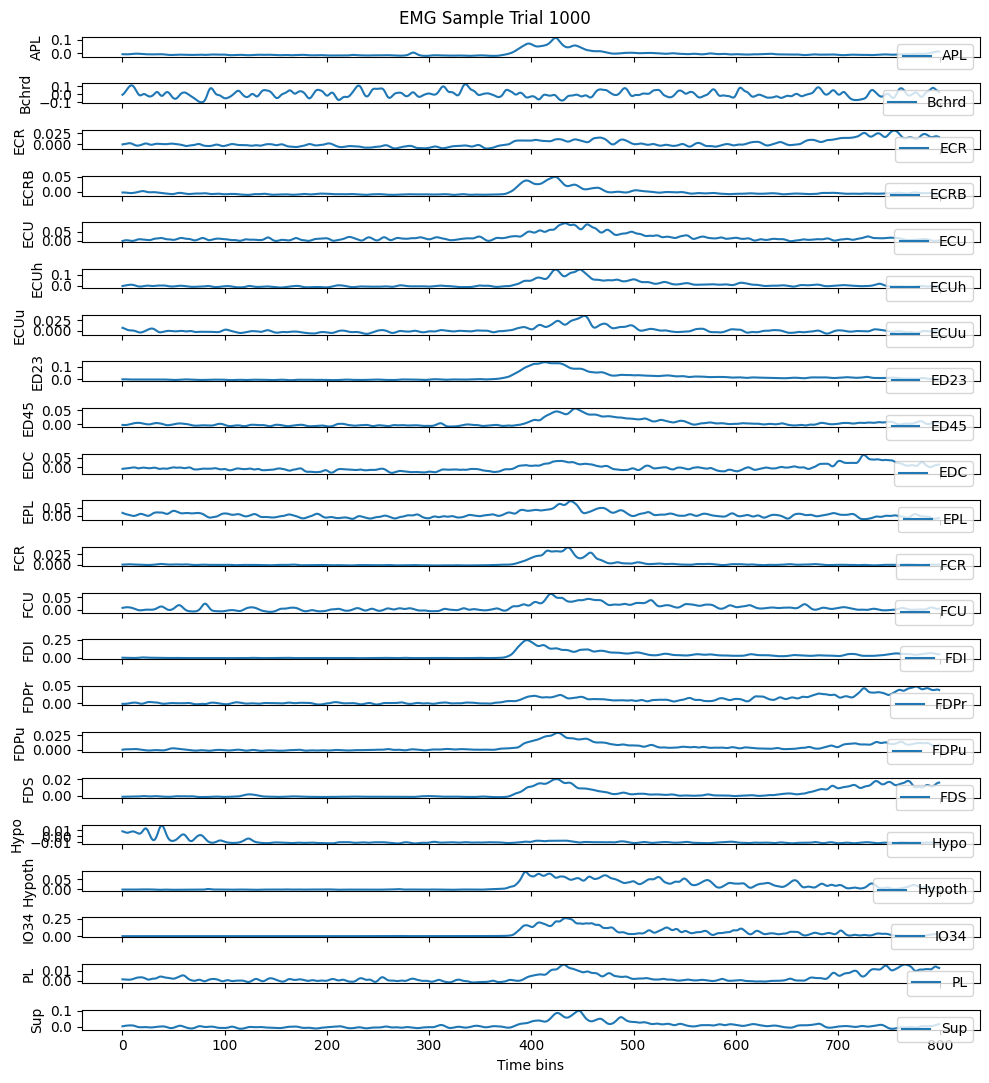

In [2]:
import numpy as np
import pickle

# === Load spike input ===
x =  np.load(r"dataset\Chip\train_500\X_long.npy")
y = np.load(r"dataset\Chip\train_500\y_long.npy")
x_val = np.load(r"dataset\Chip\validation\X_long.npy")
y_val = np.load(r"dataset\Chip\validation\y_long.npy")
x_test = np.load(r"dataset\Chip\test\X_long.npy")
y_test = np.load(r"dataset\Chip\test\y_long.npy")

# Crop time axis to [100:900]   # axes are [trials, channels, time]
x = x[:, :, 100:900]
x_val = x_val[:, :, 100:900]
x_test = x_test[:, :, 100:900]

print(f'X shape: {x.shape} y shape: {y.shape}')
print(f'X_val shape: {x_val.shape} y_val shape: {y_val.shape}')
print(f'X_test shape: {x_test.shape} y_test shape: {y_test.shape}')

# === Load EMG dicts ===
with open("dataset/Chip/train_500/y_emg_dict.pkl", "rb") as f:
    y_emg = pickle.load(f)
with open("dataset/Chip/validation/y_emg_dict.pkl", "rb") as f:
    y_emg_val = pickle.load(f)
with open("dataset/Chip/test/y_emg_dict.pkl", "rb") as f:
    y_emg_test = pickle.load(f)

# === Determine full list of muscles across all splits ===
all_keys = [list(d.keys()) for trial_list in [y_emg, y_emg_val, y_emg_test] for d in trial_list]
all_muscles = sorted(set(k for keys in all_keys for k in keys))
emg_bins = 1250

# === Pad missing keys with zeros for consistency ===
for trial_list in [y_emg, y_emg_val, y_emg_test]:
    for trial in trial_list:
        for key in all_muscles:
            if key not in trial:
                trial[key] = np.zeros(emg_bins, dtype=np.float32)

# === Confirm all trials now share the same keys ===
for i, trial_list in enumerate([y_emg, y_emg_val, y_emg_test]):
    for j, trial in enumerate(trial_list):
        if set(trial.keys()) != set(all_muscles):
            print(f"Mismatch in trial {j} of split {i}")

# === Muscle index mapping ===
muscle_idx_dict = {i: muscle for i, muscle in enumerate(all_muscles)}
print("Muscle index mapping:", muscle_idx_dict)

# === Convert to aligned tensor ===
def emg_dicts_to_tensor(y_dicts, muscles, emg_bins):
    Y = np.zeros((len(y_dicts), len(muscles), emg_bins), dtype=np.float32)
    for i, trial in enumerate(y_dicts):
        for j, muscle in enumerate(muscles):
            Y[i, j, :] = trial[muscle]
            Y[i, j, :] -= np.mean(Y[i, j, :200])  # center baseline
    return Y

y = emg_dicts_to_tensor(y_emg, all_muscles, emg_bins)[:, :, 100:900]
y_val = emg_dicts_to_tensor(y_emg_val, all_muscles, emg_bins)[:, :, 100:900]
y_test = emg_dicts_to_tensor(y_emg_test, all_muscles, emg_bins)[:, :, 100:900]



import matplotlib.pyplot as plt

# === Updated tensor conversion with mask ===
def emg_dicts_to_tensor_and_mask(y_dicts, muscles, emg_bins):
    Y = np.zeros((len(y_dicts), len(muscles), emg_bins), dtype=np.float32)
    M = np.zeros_like(Y, dtype=np.float32)
    for i, trial in enumerate(y_dicts):
        for j, muscle in enumerate(muscles):
            if np.any(trial[muscle]):  # Detect non-zero-padded muscles
                Y[i, j, :] = trial[muscle]
                Y[i, j, :] -= np.mean(Y[i, j, :100])  # baseline centering
                M[i, j, :] = 1.0  # mark as real data
    return Y[:, :, 100:900], M[:, :, 100:900]

# Convert to tensors + masks
y, y_mask = emg_dicts_to_tensor_and_mask(y_emg, all_muscles, 1250)
y_val, y_val_mask = emg_dicts_to_tensor_and_mask(y_emg_val, all_muscles, 1250)
y_test, y_test_mask = emg_dicts_to_tensor_and_mask(y_emg_test, all_muscles, 1250)

print(f"y shape: {y.shape}, y_mask shape: {y_mask.shape}")
print(f"y_val shape: {y_val.shape}, y_val_mask shape: {y_val_mask.shape}")
print(f"y_test shape: {y_test.shape}, y_test_mask shape: {y_test_mask.shape}")

# === Cleanup ===


# === Plot EMG signals for a random sample ===
def plot_emg_sample(Y, muscles, trial_idx=0, n_channels=5):
    fig, axes = plt.subplots(n_channels, 1, figsize=(10, 0.5 * n_channels), sharex=True)
    for i in range(n_channels):
        if np.all(Y[trial_idx, i] == 0):
            axes[i].plot(Y[trial_idx, i], color='red', label=muscles[i] + ' (zeros padded)')
        else:
            axes[i].plot(Y[trial_idx, i], label=muscles[i])
        axes[i].set_ylabel(muscles[i])
        axes[i].legend(loc='upper right')
    axes[-1].set_xlabel("Time bins")
    plt.suptitle(f"EMG Sample Trial {trial_idx}")
    plt.tight_layout()
    plt.show()

plot_emg_sample(y, list(muscle_idx_dict.values()), trial_idx=1000, n_channels=22)


In [ ]:
import h5py
import os
import numpy as np

# === Save filtered dataset ===
save_path = "dataset/Chip/lfads_filtered"
os.makedirs(save_path, exist_ok=True)

# Assume you have:
# x_filtered: shape [N, C, T]  - spikes aligned with filtered trials
# y_all: shape [N, M, T]       - EMG (after emg_dicts_to_tensor)
# You may want to manually slice x to match y_all if not already done:
x_filtered = x[:y_all.shape[0]]  # Crop spike trials to match filtered EMG

# Transpose to [N, T, C]
train_encod = x_filtered.transpose(0, 2, 1)     # spikes: N x T x neurons
train_recon = y_all.transpose(0, 2, 1)          # emg:    N x T x muscles

# Split 80/20 train/val
n_total = train_encod.shape[0]
n_train = int(0.8 * n_total)

train_encod_split = train_encod[:n_train]
train_recon_split = train_recon[:n_train]
valid_encod_split = train_encod[n_train:]
valid_recon_split = train_recon[n_train:]

# === Save for LFADS training (spike → EMG)
with h5py.File(os.path.join(save_path, "lfads_emg_data_filtered.h5"), "w") as f:
    f.create_dataset("train_encod_data", data=train_encod_split)
    f.create_dataset("train_recon_data", data=train_recon_split)
    f.create_dataset("valid_encod_data", data=valid_encod_split)
    f.create_dataset("valid_recon_data", data=valid_recon_split)

print("✅ Saved filtered LFADS spike→EMG data to lfads_data_filtered.h5")

In [ ]:
import h5py
import os

save_path = "dataset/Chip/lfads"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Transpose from [N, C, T] → [N, T, C]
train_encod = x.transpose(0, 2, 1)
train_recon = y.transpose(0, 2, 1)
valid_encod = x_val.transpose(0, 2, 1)
valid_recon = y_val.transpose(0, 2, 1)

with h5py.File(os.path.join(save_path, "lfads_data_all.h5"), "w") as f:
    f.create_dataset("train_encod_data", data=train_encod)
    f.create_dataset("train_recon_data", data=train_recon)
    f.create_dataset("valid_encod_data", data=valid_encod)
    f.create_dataset("valid_recon_data", data=valid_recon)


print("✅ Saved all arrays in lfads_data_all.h5 with keys:")
print(" - train_encod_data")
print(" - train_recon_data")
print(" - valid_encod_data")
print(" - valid_recon_data")



# now make another file for outo encoder training - train and rec are same
with h5py.File(os.path.join(save_path, "lfads_spike_reconstraction_all.h5"), "w") as f:
    f.create_dataset("train_encod_data", data=train_encod)
    f.create_dataset("train_recon_data", data=train_encod)
    f.create_dataset("valid_encod_data", data=valid_encod)
    f.create_dataset("valid_recon_data", data=valid_encod)

print("✅ Saved all arrays in lfads_spike_reconstraction_all.h5 with keys:")
print(" - train_encod_data")

✅ Saved all arrays in lfads_data_all.h5 with keys:
 - train_encod_data
 - train_recon_data
 - valid_encod_data
 - valid_recon_data
✅ Saved all arrays in lfads_spike_reconstraction_all.h5 with keys:
 - train_encod_data


In [2]:
import torch
from torch.serialization import add_safe_globals
from torch.distributions.bernoulli import Bernoulli
import logging
import os
import warnings
from glob import glob
from pathlib import Path
from lfads_torch.utils import flatten
import hydra
import pytorch_lightning as pl
import torch
from hydra.utils import call, instantiate
from omegaconf import OmegaConf, open_dict
from ray import tune
# === Safe unpickling
from lfads_torch.modules.augmentations import AugmentationStack, CoordinatedDropout
from lfads_torch.modules.priors import AutoregressiveMultivariateNormal
from lfads_torch.run_model import run_model
add_safe_globals([AugmentationStack, CoordinatedDropout, Bernoulli, AutoregressiveMultivariateNormal])

# Compose the train config with properly formatted overrides

config_path = Path("G:\project\lfads-torch\configs\single.yaml")
model ,_,_ = run_model(
    overrides={
        "datamodule": 'spike_prediction',
        "model": 'nlb_neuronal_reconstraction',
    },
    config_path="../configs/single.yaml",
    do_train=False,
    do_posterior_sample=False , return_on_end=True)


#load checkpoint
# === Paths
ckpt_path = r"G:\project\lfads-torch\scripts\runs\lfads-neuronal_reconstruction\neuronal_reconstruction\250803_exampleSingle\lightning_checkpoints\last.ckpt"
config_path = r"G:\project\lfads-torch\configs\model\nlb_neuronal_reconstraction.yaml"

# === Load the weights
checkpoint = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(checkpoint["state_dict"])

# === Finalize
model.eval()
model.cuda()

Global seed set to 0


FileNotFoundError: [Errno 2] No such file or directory: 'G:\\project\\lfads-torch\\scripts\\runs\\lfads-neuronal_reconstruction\\neuronal_reconstruction\\250803_exampleSingle\\lightning_checkpoints\\last.ckpt'

In [5]:
x_input = torch.tensor(x_test[:2].transpose(0, 2, 1), dtype=torch.float32).cuda()  # [B, T, input_dim]
model.eval()
print(f"x_input shape: {x_input.shape}")
with torch.no_grad():
    # Encode
    ic_mean, ic_std, ci = model.encoder(x_input)
    ic_post = model.ic_prior.make_posterior(ic_mean, ic_std)
    ic_sample = ic_post.rsample()

    # Empty external input (check if model requires it)
    ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0).to(x_input.device)

    # Decode
    gen_input, gen_states, gen_outputs, firing_rates, reconstructions, factor_dist, factors = \
        model.decoder(ic_sample, ci, ext_input)
    
    print(reconstructions.shape)


raw_output = model.readout[0](factors)
print(f"raw_output shape: {raw_output}")

x_input shape: torch.Size([2, 800, 152])
torch.Size([2, 800, 4])
raw_output shape: tensor([[[-4.9883, -3.3609, -4.6358,  ..., -4.0121, -3.1522, -4.2053],
         [-4.7266, -3.3147, -4.4677,  ..., -4.3431, -3.1662, -5.0657],
         [-4.6909, -3.3766, -4.4295,  ..., -4.3415, -3.1911, -5.0665],
         ...,
         [-2.8911, -2.3428, -2.2989,  ..., -2.7223, -2.2446, -2.7296],
         [-2.8417, -2.3371, -2.2757,  ..., -2.7362, -2.2359, -2.7432],
         [-2.7992, -2.3179, -2.2455,  ..., -2.7315, -2.2247, -2.7208]],

        [[-4.9381, -3.3720, -4.5024,  ..., -3.9598, -3.1580, -4.2737],
         [-4.6935, -3.3434, -4.4054,  ..., -4.2435, -3.1778, -5.1485],
         [-4.6275, -3.3898, -4.3623,  ..., -4.2626, -3.1885, -5.1169],
         ...,
         [-2.9209, -2.3838, -2.3412,  ..., -2.6976, -2.2412, -2.8119],
         [-2.9036, -2.3749, -2.3188,  ..., -2.7019, -2.2348, -2.7933],
         [-2.9174, -2.3800, -2.3499,  ..., -2.6991, -2.2394, -2.8202]]],
       device='cuda:0', grad_fn=<

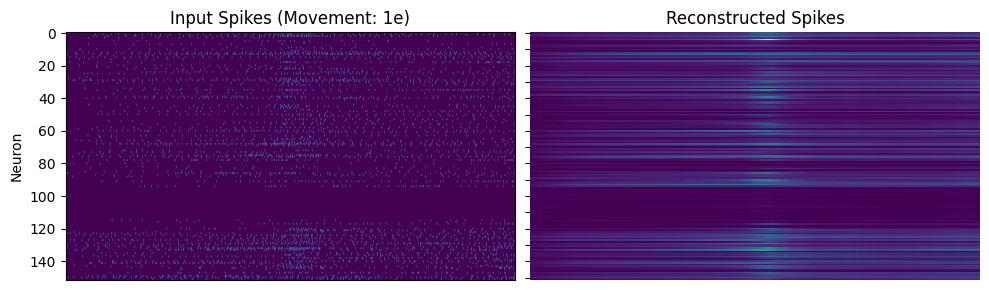

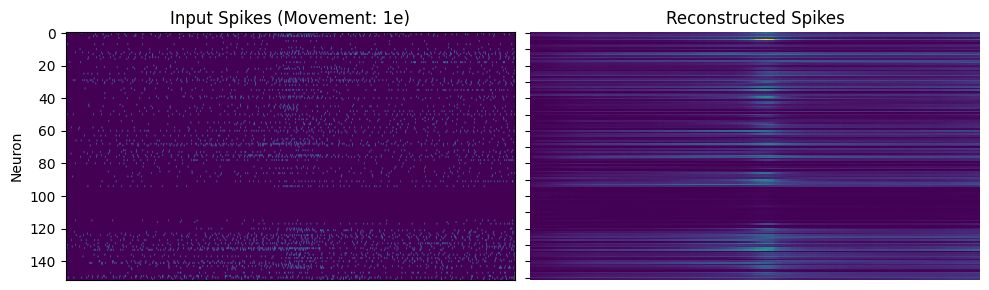

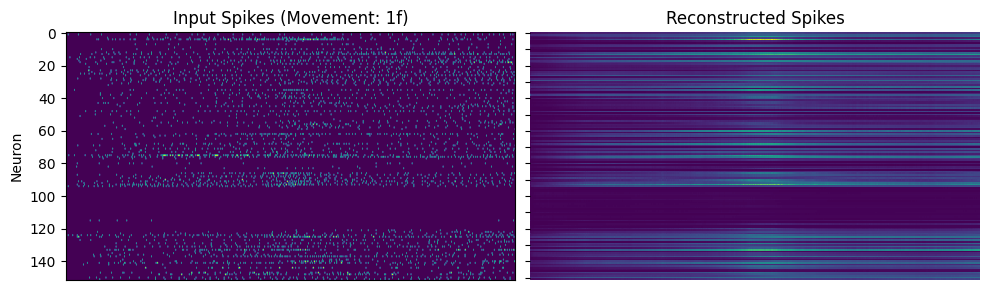

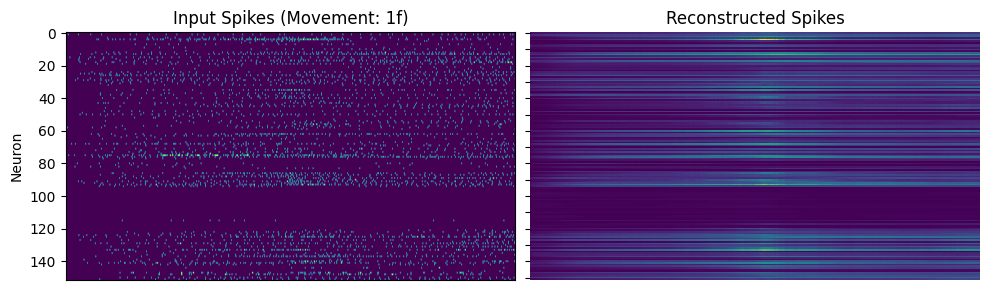

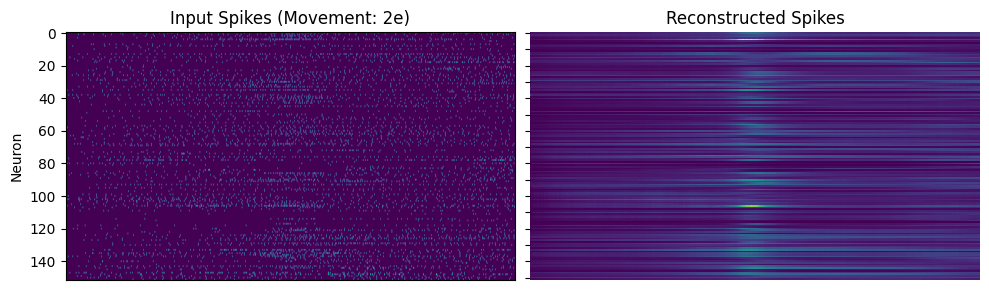

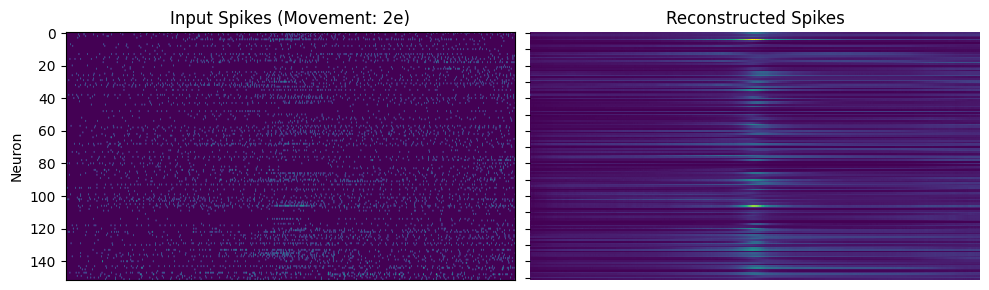

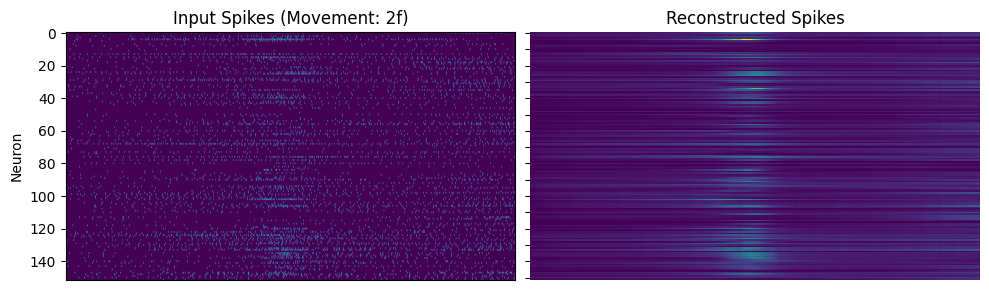

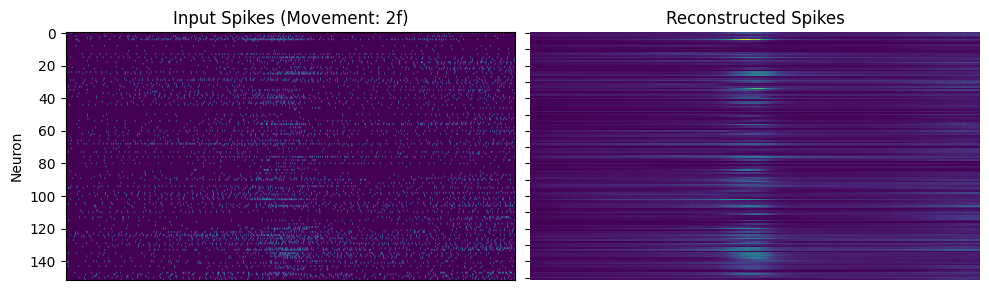

In [6]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# movements index mapping
movements = {0: '1e', 1: '1f', 2: '2e', 3: '2f',
            4: '3e', 5: '3f', 6: '4e', 7: '4f',
            8: '5e', 9: '5f', 10: '6e', 11: '6f'}

def plot_heatmap(ax, data, title, ylabel, yticklabels=None):
    ax.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time")
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5, color='gray')
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ax.set_yticklabels(yticklabels if yticklabels else np.arange(data.shape[0]))
    ax.tick_params(axis='y', length=0)


torch.manual_seed(0)  # For reproducibility

# === Input tensor: [B, T, Neurons]
x_input = torch.tensor(x_test[:200].transpose(0, 2, 1), dtype=torch.float32).cuda()

model.eval()

with torch.no_grad():
    # === Encode
    ic_mean, ic_std, ci = model.encoder(x_input)
    ic_post = model.ic_prior.make_posterior(ic_mean, ic_std)
    ic_sample = ic_post.mean  # Deterministic output

    # === External input
    ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0).to(x_input.device)

    # === Decode
    _, _, _, _, _, _, factors = model.decoder(ic_sample, ci, ext_input)

    # === Readout & activation
    raw_output = model.readout[0](factors)  # [B, T, EMG_dim]
    recon_np = torch.exp(raw_output).cpu().numpy()  # EMG reconstruction [B, T, EMG]
    x_input_np = x_input.cpu().numpy()  # [B, T, Neurons]

# === Convert to [B, Channels, Time]
recon_np = np.transpose(recon_np, (0, 2, 1))  # [B, EMG, T]
x_input_np = np.transpose(x_input_np, (0, 2, 1))  # [B, Neuron, T]
Y = y[:200]  # Ground truth EMG [B, EMG, T]

# === Trials to plot
examples_to_plot = [0,20, 60,78, 110,132, 160,190]

for i in examples_to_plot:
    fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True)

    axs[0].imshow(x_input_np[i], aspect='auto', cmap='viridis')
    axs[0].set_title(f"Input Spikes (Movement: {movements[i//50]})")
    axs[0].set_ylabel("Neuron")
    axs[0].grid(False)

    # Reconstructed EMG
    sns.heatmap(recon_np[i], ax=axs[1], cmap='viridis', cbar=False)
    axs[1].set_title("Reconstructed Spikes")
    axs[1].set_yticklabels([])
    axs[1].set_xticks([])
    plt.tight_layout()
    plt.show()


In [7]:
x_input = torch.tensor(x_test[::50].transpose(0, 2, 1), dtype=torch.float32).cuda()  # shape [2, 800, 152]

model.eval()
with torch.no_grad():
    ic_mean, ic_std, ci = model.encoder(x_input)
    ic_post = model.ic_prior.make_posterior(ic_mean, ic_std)
    ic_sample = ic_post.rsample()

    # FIXED: [B, T, ext_input_dim] with ext_input_dim=0
    ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0, device=x_input.device)

    # Run decoder
    _, _, _, _, _, _, C_factors = model.decoder(ic_sample, ci, ext_input)

print(f"Factors shape: {C_factors.shape}")  # Should be [B, T, fac_dim]


Factors shape: torch.Size([12, 800, 15])


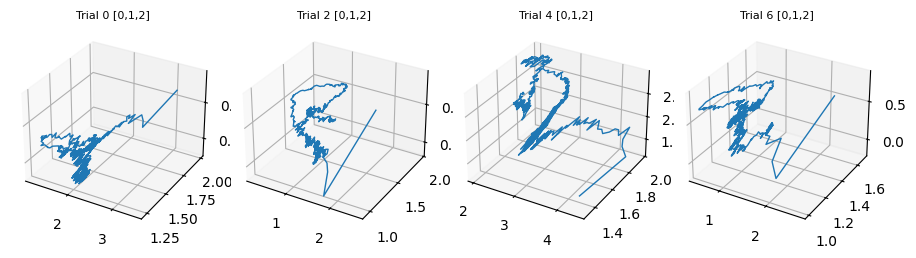

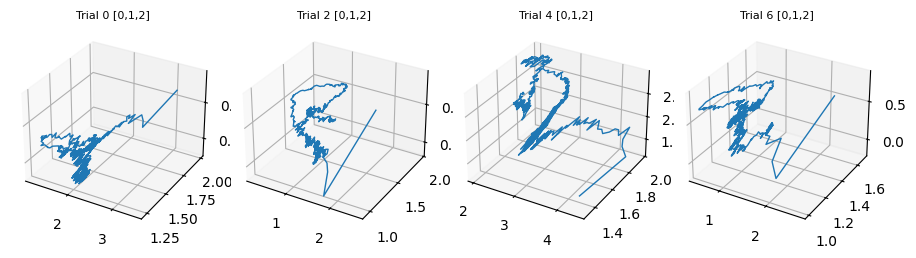

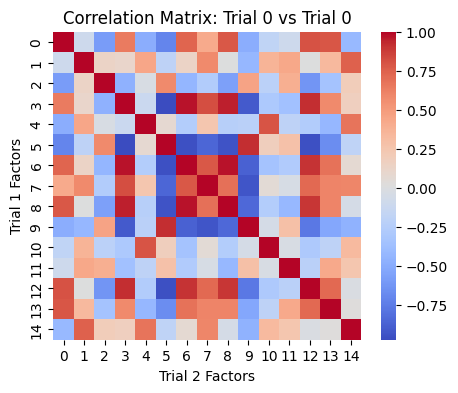

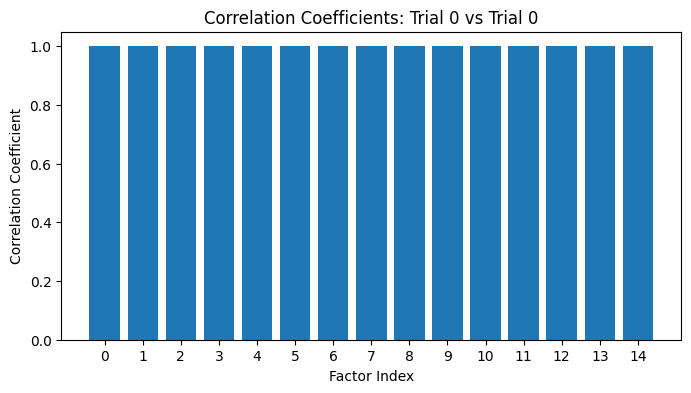

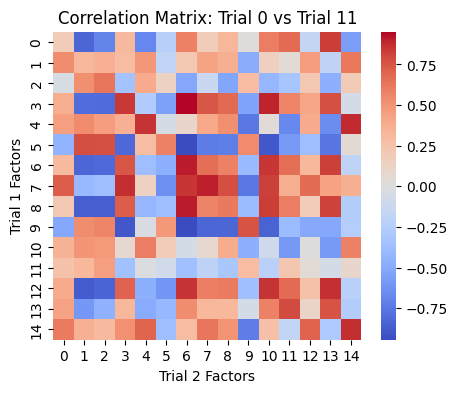

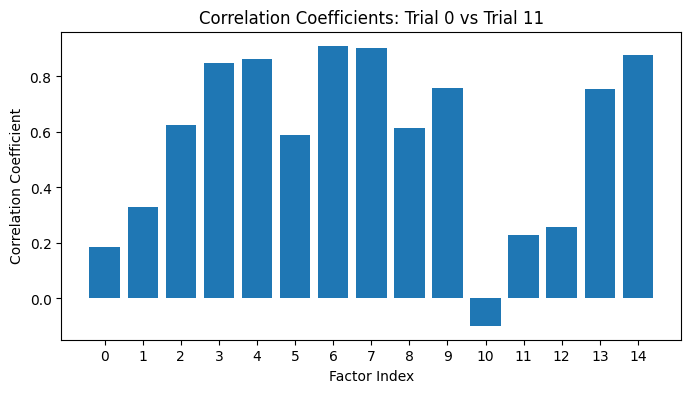

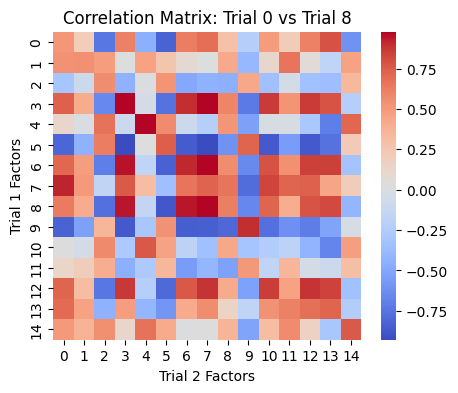

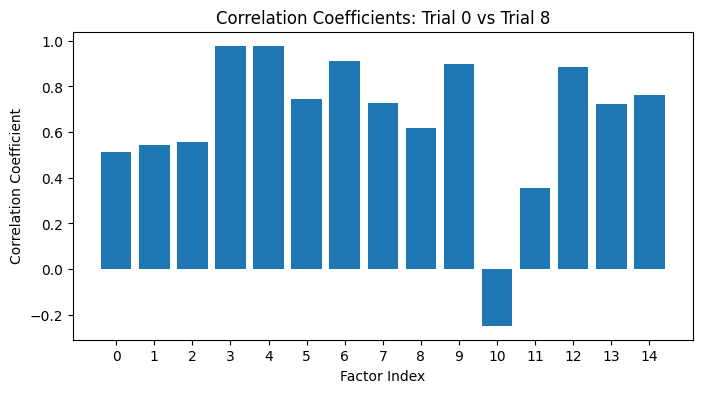

In [9]:
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# plot pca of random 4 sample C_factors in 3d
import matplotlib.pyplot as plt

def plot_factors_3d(C_factors, sample_indices=None, pca_components=None):
    """
    Plots 3D PCA or selected dims of C_factors for given sample indices.
    If pca_components is None, uses dims [0,1,2] and [10,33,33] as in original code.
    """
    if sample_indices is None:
        sample_indices = [0, 2, 4, 6]
    num_samples = len(sample_indices)
    fig = plt.figure(figsize=(9, 3))
    for i, idx in enumerate(sample_indices):
        ax = fig.add_subplot(1, num_samples, i+1, projection='3d')
        trial_C_factors = C_factors[idx].detach().cpu().numpy()  # [T, fac_dim]
        if pca_components is None:
            ax.plot(trial_C_factors[:, 0], trial_C_factors[:, 1], trial_C_factors[:, 2], lw=1)
            ax.set_title(f"Trial {idx} [0,1,2]" , fontsize=8)
        else:
            ax.plot(trial_C_factors[:, pca_components[0]], 
                    trial_C_factors[:, pca_components[1]], 
                    trial_C_factors[:, pca_components[2]], lw=1)
            ax.set_title(f"Trial {idx} {pca_components}", fontsize=8)
    plt.tight_layout()
    plt.show()

    # Second plot with dims [10,33,57] if pca_components is None
    if pca_components is None:
        fig = plt.figure(figsize=(9, 3))
        for i, idx in enumerate(sample_indices):
            ax = fig.add_subplot(1, num_samples, i+1, projection='3d')
            trial_C_factors = C_factors[idx].detach().cpu().numpy()
            ax.plot(trial_C_factors[:, 0], trial_C_factors[:, 1], trial_C_factors[:, 2], lw=1)
            ax.set_title(f"Trial {idx} [0,1,2]" , fontsize=8)
        plt.tight_layout()
        plt.show()

# Example usage:
plot_factors_3d(C_factors)


# make correlation matrix of C_factors between 2 different trials
import seaborn as sns   
import matplotlib.pyplot as plt
def plot_correlation_matrix(factors, trial1_idx, trial2_idx):
    # Get C_factors for the two trials
    factors1 = factors[trial1_idx].detach().cpu().numpy()  # [T, fac_dim]
    factors2 = factors[trial2_idx].detach().cpu().numpy()  # [T, fac_dim]

    # Compute correlation matrix
    corr_matrix = np.corrcoef(factors1.T, factors2.T)[:factors1.shape[1], factors1.shape[1]:]

    # Plot heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True)
    plt.title(f'Correlation Matrix: Trial {trial1_idx} vs Trial {trial2_idx}')
    
    plt.xlabel('Trial 2 Factors')
    plt.ylabel('Trial 1 Factors')
    plt.show()
    #print the corelations on the daiagonal as barplot
    diag_corr = np.diag(corr_matrix)
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(diag_corr)), diag_corr)
    plt.xlabel('Factor Index')
    plt.ylabel('Correlation Coefficient')
    plt.title(f'Correlation Coefficients: Trial {trial1_idx} vs Trial {trial2_idx}')
    plt.xticks(range(len(diag_corr)))
    plt.show()

# Example usage
plot_correlation_matrix(C_factors,0, 0)  # Compare trial 0
plot_correlation_matrix(C_factors, 0, 11)  # Compare trial 0 and 22
plot_correlation_matrix(C_factors, 0, 8)  # Compare trial 0


In [10]:
### lets try it on another monkey!

# Load another dataset
x_gabby_test = np.load(r"dataset\Gabby\test\X_long.npy")
# Crop time axis to [100:900]   # axes are [trials, channels, time]
x_gabby_test = x_gabby_test[:, :, 100:900]
# remove three channels that are all zeros
print(f'X_test shape: {x_gabby_test.shape}')
# Find channels that are all zeros across all trials and time bins
zero_channels = np.where(np.all(x_gabby_test == 0, axis=(0, 2)))[0]
print(f"Zero channels: {zero_channels}")
# Remove those channels
x_gabby_test = np.delete(x_gabby_test, zero_channels[:3], axis=1)
print(f'X_test shape: {x_gabby_test.shape}')
x_input = torch.tensor(x_gabby_test[::].transpose(0, 2, 1), dtype=torch.float32).cuda()  # shape [2, 800, 152]

model.eval()
with torch.no_grad():
    ic_mean, ic_std, ci = model.encoder(x_input)
    ic_post = model.ic_prior.make_posterior(ic_mean, ic_std)
    ic_sample = ic_post.rsample()

    # FIXED: [B, T, ext_input_dim] with ext_input_dim=0
    ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0, device=x_input.device)

    # Run decoder
    _, _, _, _, _, _, G_factors = model.decoder(ic_sample, ci, ext_input)

print(f"Factors shape: {G_factors.shape}")  # Should be [B, T, fac_dim]


X_test shape: (600, 155, 800)
Zero channels: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154]
X_test shape: (600, 152, 800)
Factors shape: torch.Size([600, 800, 15])


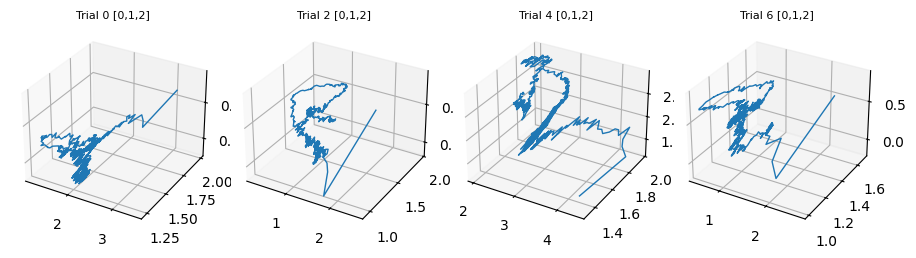

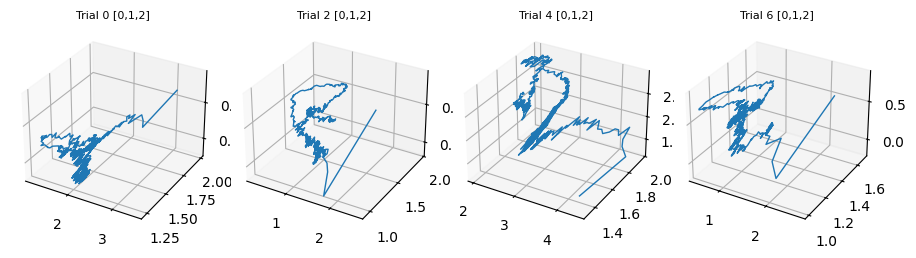

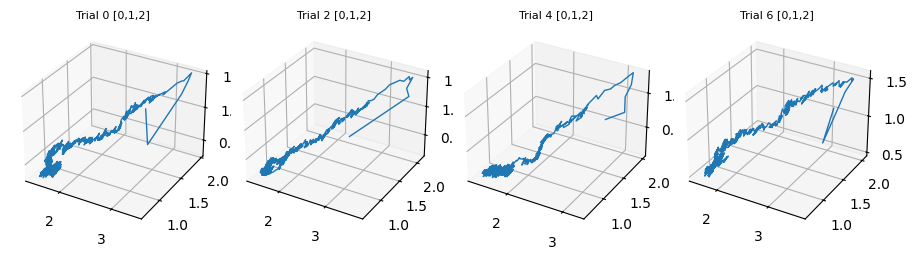

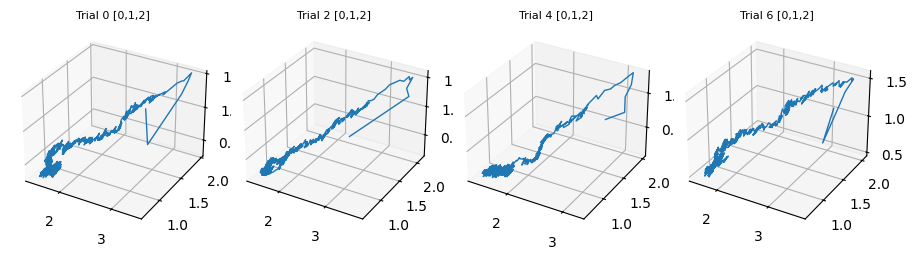

In [11]:
plot_factors_3d(C_factors)
plot_factors_3d(G_factors)


C_factors shape: torch.Size([12, 800, 15])
G_factors shape: torch.Size([600, 800, 15])


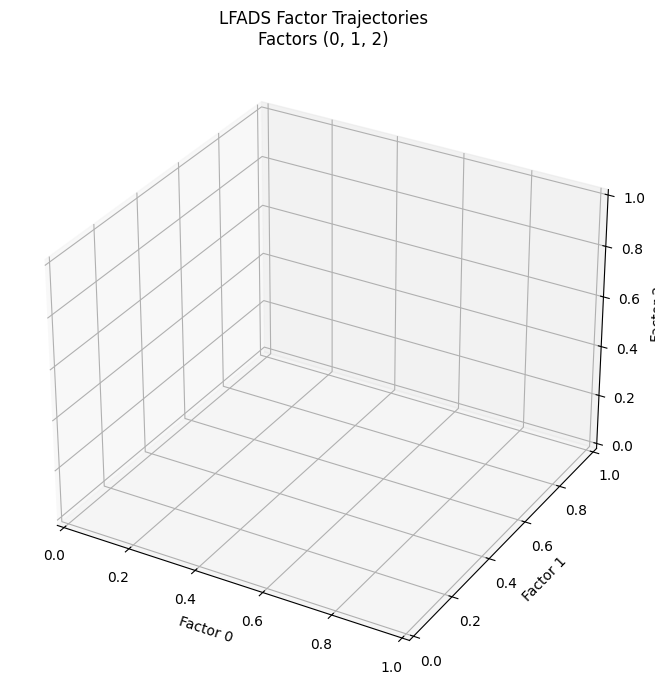

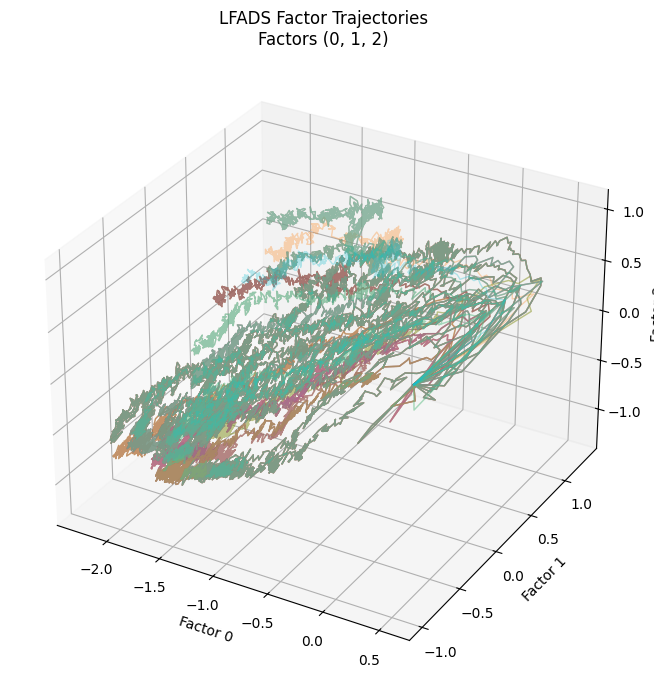

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print('C_factors shape:', C_factors.shape)
print('G_factors shape:', G_factors.shape)

def plot_lfads_factors_grouped(
    C_factors,
    trials_per_movement=50,
    movements=range(6),
    trials_per_group=20,
    factor_triplet=(0, 1, 2),
    align_to_origin=True
):
    """
    Plot LFADS factor trajectories from multiple movements in a shared 3D plot.

    Args:
        C_factors (torch.Tensor): Tensor of shape [B, T, F]
        trials_per_movement (int): Number of trials per movement block
        movements (list): Movement indices (e.g., [0,1,2,...])
        trials_per_group (int): Number of trials to sample per movement
        factor_triplet (tuple): Indices of 3 factors to plot (e.g., (0,1,2))
        align_to_origin (bool): Whether to shift all trajectories to start at the origin
    """
    assert C_factors.ndim == 3, "C_factors must be shape [B, T, F]"
    B, T, F = C_factors.shape
    i, j, k = factor_triplet

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    cmap = plt.get_cmap("tab10")

    for m in movements:
        color = cmap(m % 10)
        start = m * trials_per_movement
        for t in range(start, min(start + trials_per_group, B)):
            traj = C_factors[t].detach().cpu().numpy()  # [T, F]
            traj_xyz = traj[:, [i, j, k]]
            if align_to_origin:
                traj_xyz -= traj_xyz[0]  # Align to common origin
            ax.plot(traj_xyz[:, 0], traj_xyz[:, 1], traj_xyz[:, 2],
                    color=color, alpha=0.3, linewidth=1)

    ax.set_title(f"LFADS Factor Trajectories\nFactors {factor_triplet}")
    ax.set_xlabel(f"Factor {i}")
    ax.set_ylabel(f"Factor {j}")
    ax.set_zlabel(f"Factor {k}")
    plt.tight_layout()
    plt.show()

# === Example usage:
plot_lfads_factors_grouped(
    C_factors,
    trials_per_movement=50,
    movements=list(range(1,10)),
    trials_per_group=20,
    factor_triplet=(0, 1, 2),
    align_to_origin=True  # toggle to False if you want raw coordinates
)


# === Example usage:
plot_lfads_factors_grouped(
    G_factors,
    trials_per_movement=1,
    movements=list(range(1,10)),
    trials_per_group=20,
    factor_triplet=(0, 1, 2),
    align_to_origin=True  # toggle to False if you want raw coordinates
)

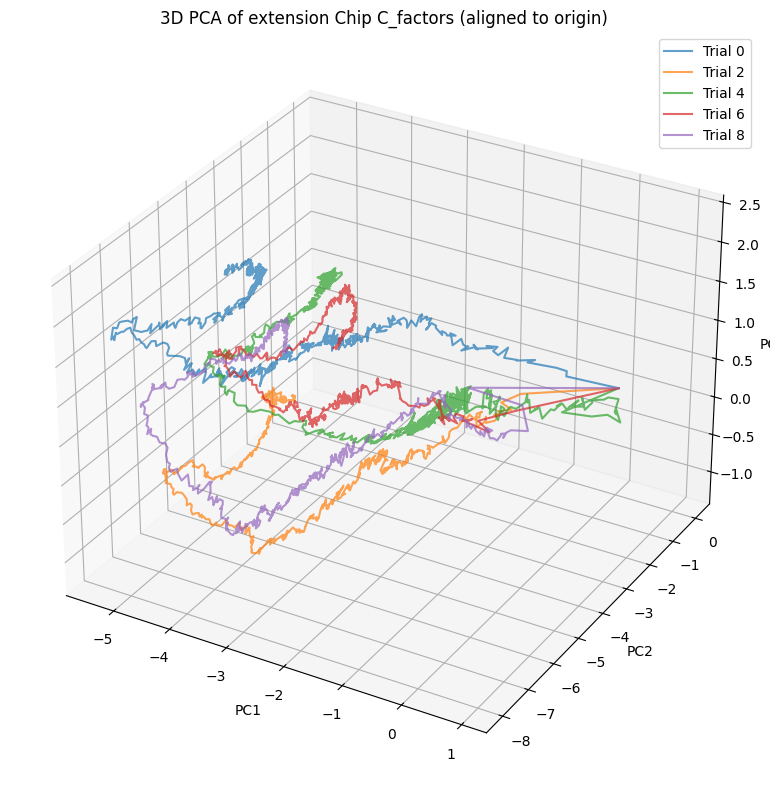

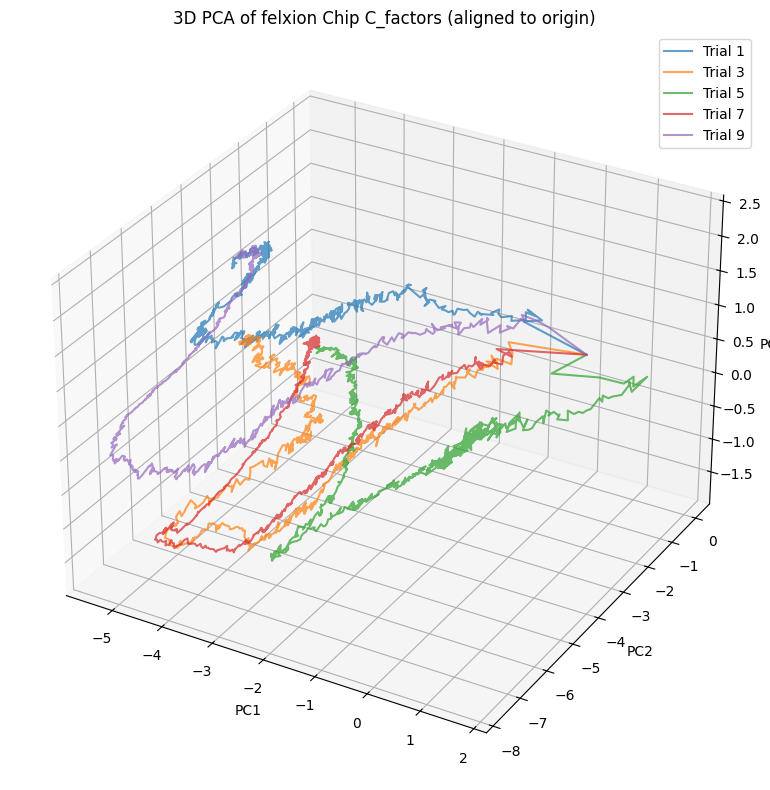

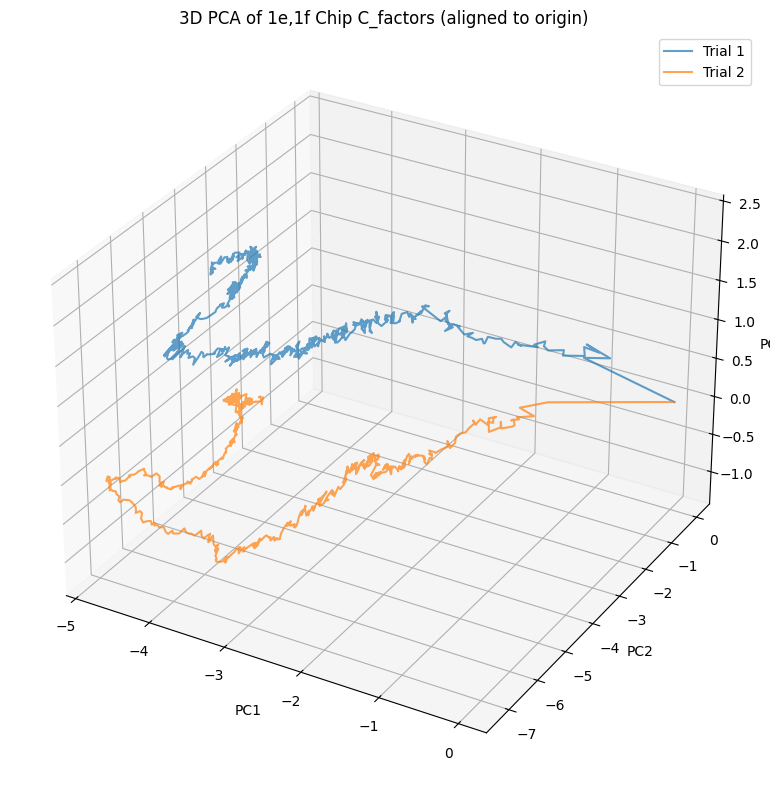

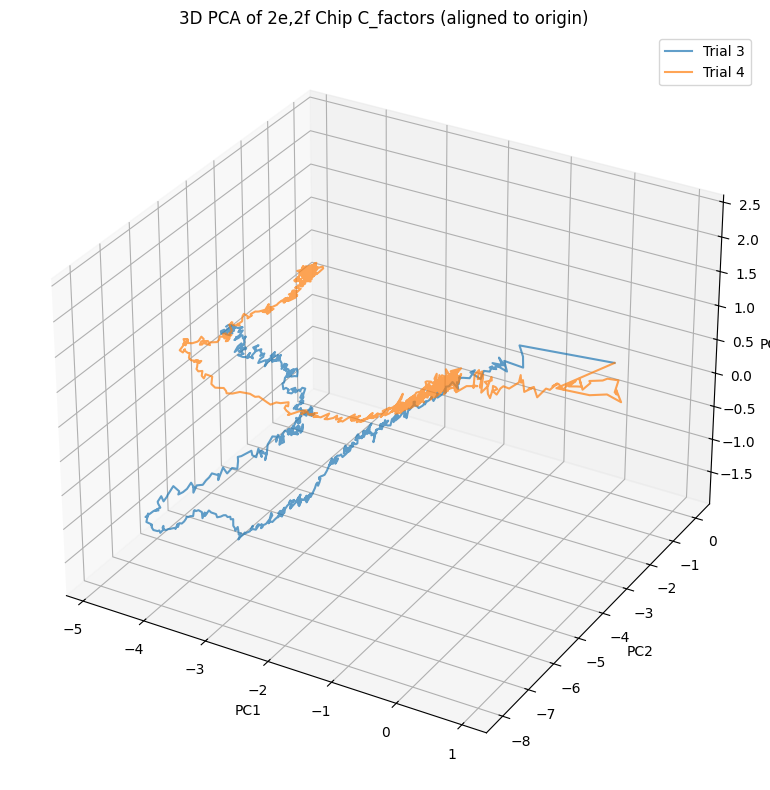

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert to numpy and flatten across trials & time
factors_np = C_factors.detach().cpu().numpy()  # [B, T, F]
B, T, F = factors_np.shape
factors_flat = factors_np.reshape(-1, F)       # [B*T, F]

# Run PCA to 3 components
pca = PCA(n_components=3)
factors_pca_flat = pca.fit_transform(factors_flat)  # [B*T, 3]
factors_pca = factors_pca_flat.reshape(B, T, 3)     # [B, T, 3]

# Align each trajectory to origin (subtract first timepoint)
factors_pca -= factors_pca[:, 0:1, :]

# Plot selected trials in 3D
trials_to_plot = [0, 2, 4, 6, 8]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of extension Chip C_factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()

# Plot selected trials in 3D
trials_to_plot = [1, 3, 5, 7, 9]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of felxion Chip C_factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()


# Plot selected trials in 3D
trials_to_plot = [1,2]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of 1e,1f Chip C_factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()

# Plot selected trials in 3D
trials_to_plot = [3,4]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of 2e, 2f Chip C_factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()

X_test shape: (600, 155, 800)
Zero channels: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154]
X_test shape: (600, 152, 800)
Factors shape: torch.Size([600, 800, 15])


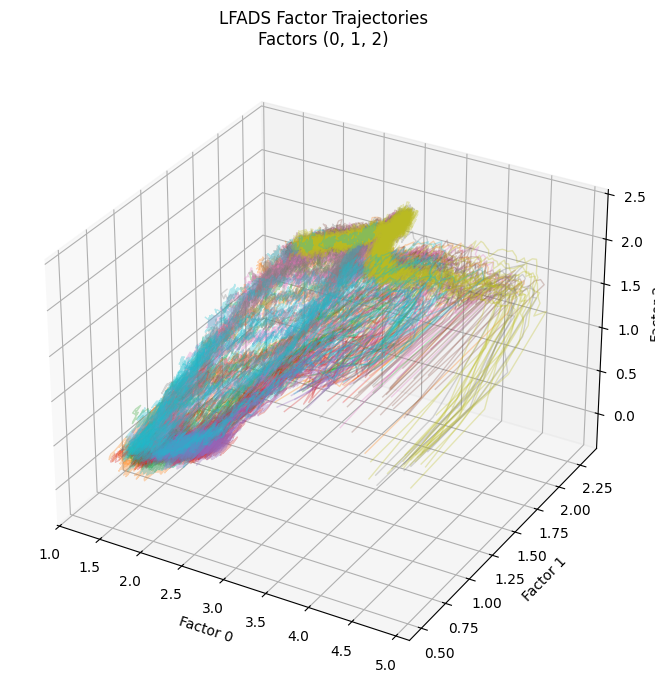

In [18]:

# Load another dataset
x_gabby_test = np.load(r"dataset\Gabby\test\X_long.npy")
# Crop time axis to [100:900]   # axes are [trials, channels, time]
x_gabby_test = x_gabby_test[:, :, 100:900]
# remove three channels that are all zeros
print(f'X_test shape: {x_gabby_test.shape}')
# Find channels that are all zeros across all trials and time bins
zero_channels = np.where(np.all(x_gabby_test == 0, axis=(0, 2)))[0]
print(f"Zero channels: {zero_channels}")
# Remove those channels
x_gabby_test = np.delete(x_gabby_test, zero_channels[:3], axis=1)
print(f'X_test shape: {x_gabby_test.shape}')
x_input = torch.tensor(x_gabby_test[::].transpose(0, 2, 1), dtype=torch.float32).cuda()  # shape [2, 800, 152]

model.eval()
with torch.no_grad():
    ic_mean, ic_std, ci = model.encoder(x_input)
    ic_post = model.ic_prior.make_posterior(ic_mean, ic_std)
    ic_sample = ic_post.rsample()

    # FIXED: [B, T, ext_input_dim] with ext_input_dim=0
    ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0, device=x_input.device)

    # Run decoder
    _, _, _, _, _, _, G_factors = model.decoder(ic_sample, ci, ext_input)

print(f"Factors shape: {G_factors.shape}")  # Should be [B, T, fac_dim]
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_lfads_factors_grouped(
    G_factors,
    trials_per_movement=50,
    movements=range(6),
    trials_per_group=20,
    factor_triplet=(0, 1, 2),
    align_to_origin=True
):
    """
    Plot LFADS factor trajectories from multiple movements in a shared 3D plot.

    Args:
        G_factors (torch.Tensor): Tensor of shape [B, T, F]
        trials_per_movement (int): Number of trials per movement block
        movements (list): Movement indices (e.g., [0,1,2,...])
        trials_per_group (int): Number of trials to sample per movement
        factor_triplet (tuple): Indices of 3 factors to plot (e.g., (0,1,2))
        align_to_origin (bool): Whether to shift all trajectories to start at the origin
    """
    assert G_factors.ndim == 3, "G_factors must be shape [B, T, F]"
    B, T, F = G_factors.shape
    i, j, k = factor_triplet

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    cmap = plt.get_cmap("tab10")

    for m in movements:
        color = cmap(m % 10)
        start = m * trials_per_movement
        for t in range(start, min(start + trials_per_group, B)):
            traj = G_factors[t].detach().cpu().numpy()  # [T, F]
            traj_xyz = traj[:, [i, j, k]]
            if align_to_origin:
                traj_xyz -= traj_xyz[0]  # Align to common origin
            ax.plot(traj_xyz[:, 0], traj_xyz[:, 1], traj_xyz[:, 2],
                    color=color, alpha=0.3, linewidth=1)

    ax.set_title(f"LFADS Factor Trajectories\nFactors {factor_triplet}")
    ax.set_xlabel(f"Factor {i}")
    ax.set_ylabel(f"Factor {j}")
    ax.set_zlabel(f"Factor {k}")
    plt.tight_layout()
    plt.show()

# === Example usage:
plot_lfads_factors_grouped(
    G_factors,
    trials_per_movement=500 // 12,
    movements=list(range(1,10)),
    trials_per_group=20,
    factor_triplet=(0, 1, 2),
    align_to_origin=False  # toggle to False if you want raw coordinates
)


Factors shape: torch.Size([12, 800, 15])
raw_output shape: tensor([[[-4.9400, -3.5516, -4.7597,  ..., -4.0863, -3.3247, -4.7201],
         [-4.2898, -3.1952, -4.2405,  ..., -3.9449, -3.1788, -5.1537],
         [-4.3219, -3.1543, -4.1943,  ..., -3.9315, -3.1906, -5.0366],
         ...,
         [-3.3087, -2.4126, -2.9387,  ..., -3.2671, -2.4384, -2.6632],
         [-3.2978, -2.3981, -2.9211,  ..., -3.2610, -2.4279, -2.6275],
         [-3.2854, -2.3899, -2.9019,  ..., -3.2540, -2.4187, -2.5982]],

        [[-4.9678, -3.5166, -4.7013,  ..., -4.1768, -3.3222, -4.7450],
         [-4.7355, -3.2698, -4.5853,  ..., -4.1505, -3.3027, -5.3245],
         [-4.6360, -3.2225, -4.5100,  ..., -4.1561, -3.2449, -5.1025],
         ...,
         [-3.3253, -2.5631, -2.7614,  ..., -3.1589, -2.4190, -2.7664],
         [-3.3232, -2.5737, -2.7725,  ..., -3.1589, -2.4174, -2.7862],
         [-3.2762, -2.5590, -2.7530,  ..., -3.1646, -2.4029, -2.7763]],

        [[-5.0300, -3.5817, -4.6819,  ..., -4.2585, -3.22

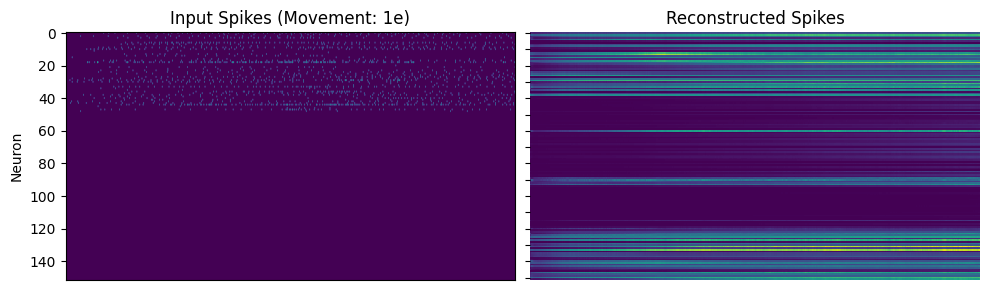

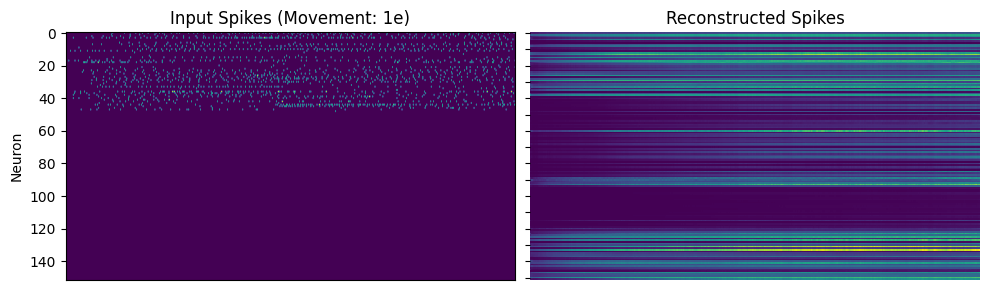

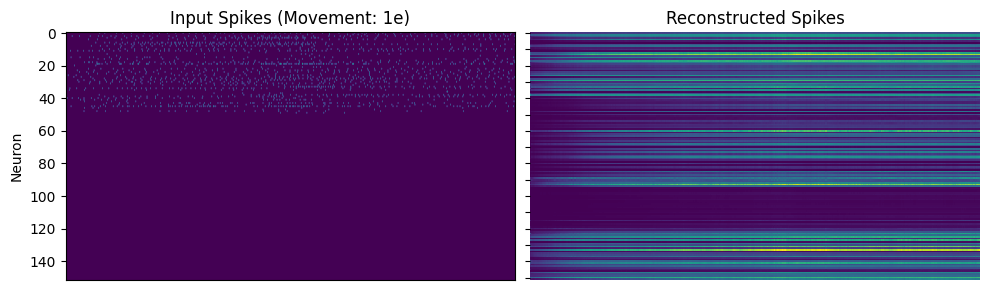

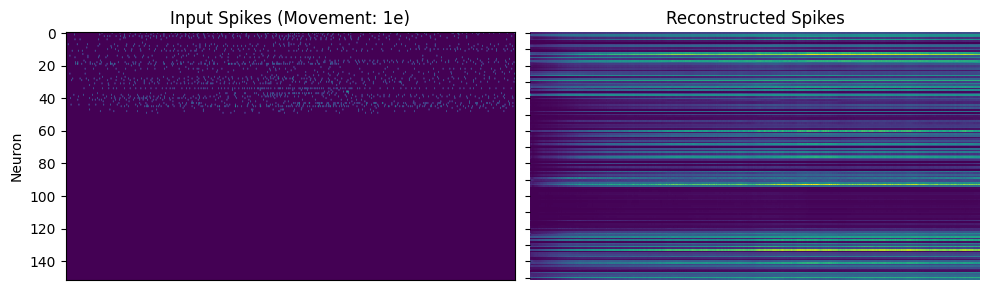

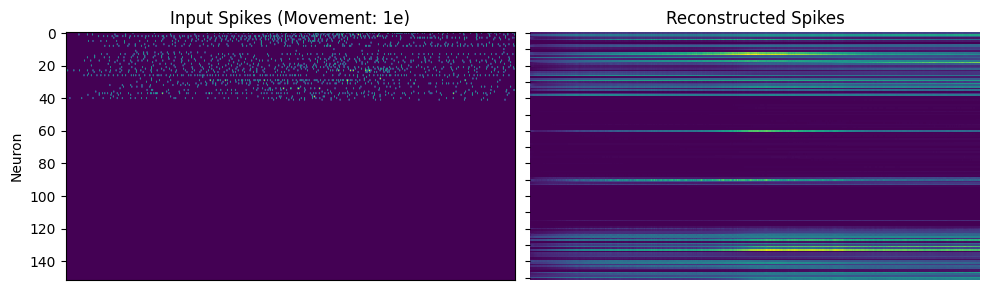

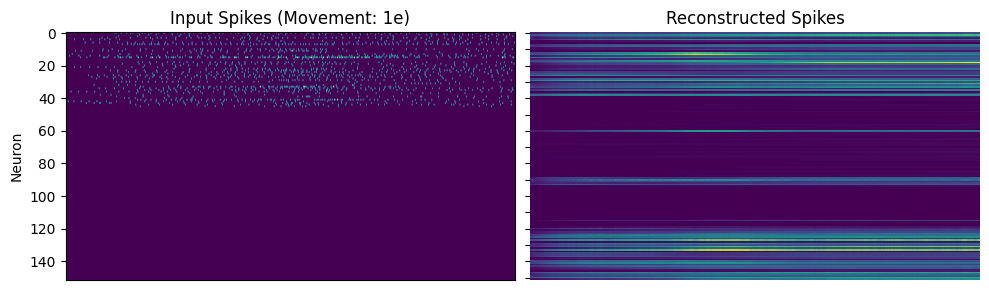

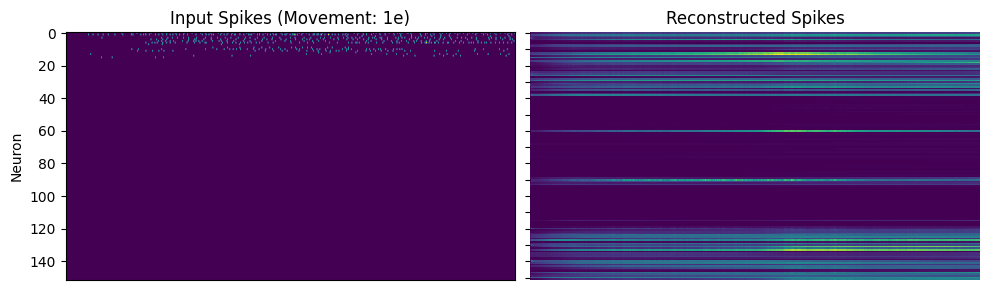

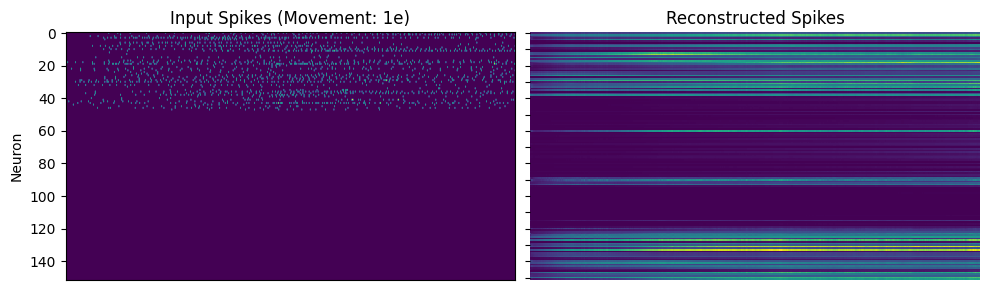

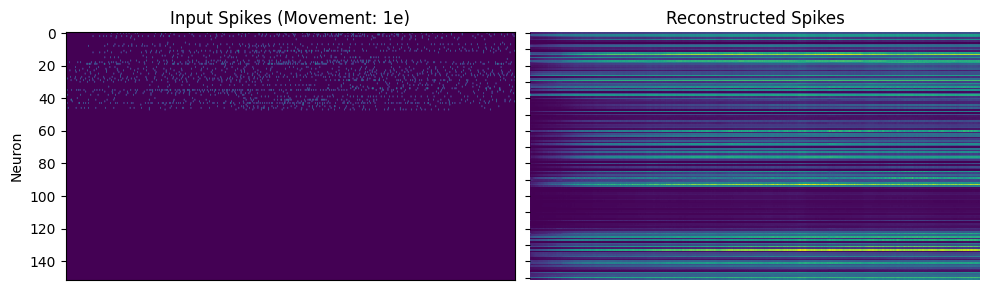

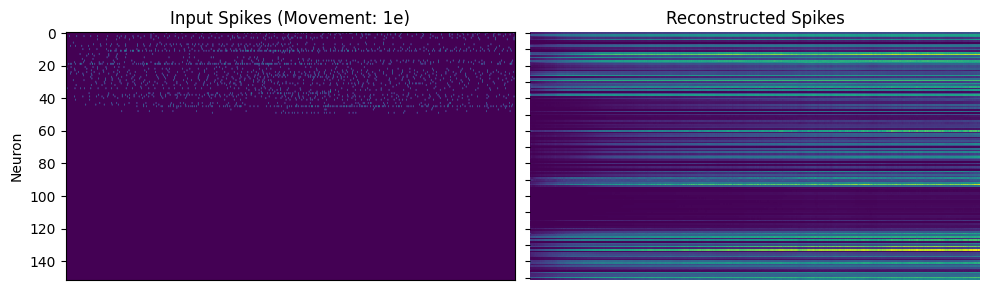

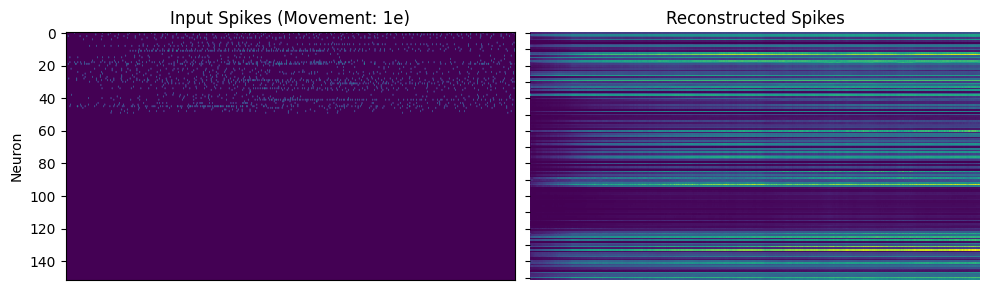

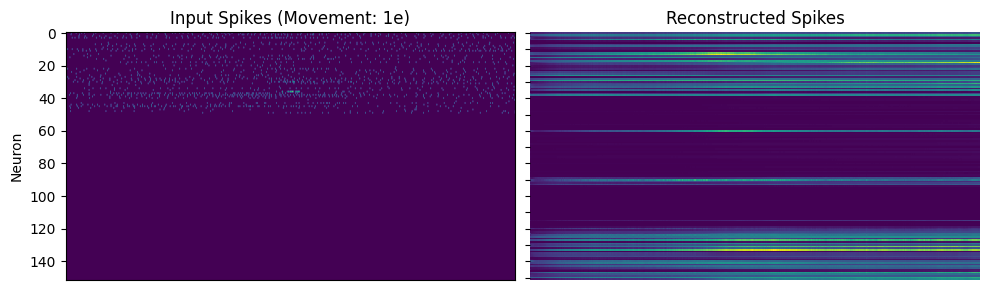

IndexError: index 12 is out of bounds for axis 0 with size 12

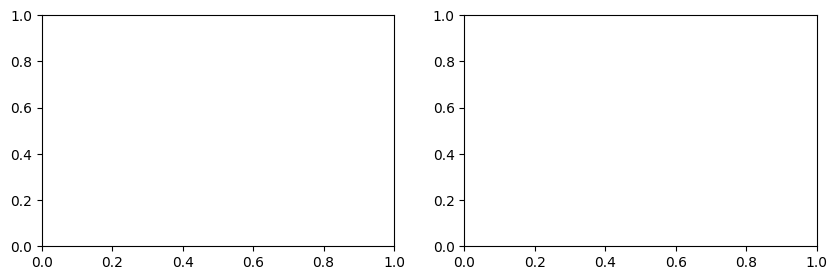

In [19]:
# try reconstracting the gabby data
x_input = torch.tensor(x_gabby_test[::50].transpose(0, 2, 1), dtype=torch.float32).cuda()  # shape [2, 800, 152]
model.eval()
with torch.no_grad():
    ic_mean, ic_std, ci = model.encoder(x_input)
    ic_post = model.ic_prior.make_posterior(ic_mean, ic_std)
    ic_sample = ic_post.rsample()

    # FIXED: [B, T, ext_input_dim] with ext_input_dim=0
    ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0, device=x_input.device)

    # Run decoder
    _, _, _, _, _, _, G_factors = model.decoder(ic_sample, ci, ext_input)
    print(f"Factors shape: {G_factors.shape}")  # Should be [B, T, fac_dim]
    raw_output = model.readout[0](G_factors)
    print(f"raw_output shape: {raw_output}")
    # Convert to numpy and reshape
    recon_np = torch.exp(raw_output).cpu().numpy()  # EMG reconstruction [B, T, EMG]
    recon_np = np.transpose(recon_np, (0, 2, 1))
# [B, EMG, T]
x_input_np = x_input.cpu().numpy()  # [B, T, Neurons]
# [B, Neuron, T]
Y = y_test[:200]  # Ground truth EMG [B, EMG, T]
# [B, EMG, T]
# === Trials to plot
examples_to_plot = [0,1,2,3,4,5,6,7,8,9,10,11,12]
for i in examples_to_plot:
    fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True)

    axs[0].imshow(x_input_np[i].T, aspect='auto', cmap='viridis')
    axs[0].set_title(f"Input Spikes (Movement: {movements[i//50]})")
    axs[0].set_ylabel("Neuron")
    axs[0].grid(False)

    # Reconstructed EMG
    sns.heatmap(recon_np[i], ax=axs[1], cmap='viridis', cbar=False)
    axs[1].set_title("Reconstructed Spikes")
    axs[1].set_yticklabels([])
    axs[1].set_xticks([])
    plt.tight_layout()
    plt.show()

In [ ]:
# lets make a factor dataset
# chip Dataset - for training classifier
import numpy as np
import pickle


# movements index mapping
movements = {0: '1e', 1: '1f', 2: '2e', 3: '2f',
            4: '3e', 5: '3f', 6: '4e', 7: '4f',
            8: '5e', 9: '5f', 10: '6e', 11: '6f'}


import numpy as np
import pickle
import torch
from tqdm import tqdm

# === Load spike input ===
x =  np.load(r"dataset\Chip\train_500\X_long.npy")
y =  np.load(r"dataset\Chip\train_500\y_long.npy")
x_val = np.load(r"dataset\Chip\validation\X_long.npy")
y_val = np.load(r"dataset\Chip\validation\y_long.npy")
x_test = np.load(r"dataset\Chip\test\X_long.npy")
y_test = np.load(r"dataset\Chip\test\y_long.npy")

# === Crop time axis to [100:900]
x = x[:, :, 100:900]
x_val = x_val[:, :, 100:900]
x_test = x_test[:, :, 100:900]

# === Dataset extractor that returns full factor sequence (no pooling)
def extract_factors_sequence(x_data, y_data, batch_size=64, deterministic=True):
    model.eval()
    X_f_seq = []
    Y_f_seq = []

    for i in tqdm(range(0, x_data.shape[0], batch_size)):
        x_batch = x_data[i:i + batch_size]  # [B, C, T]
        y_batch = y_data[i:i + batch_size]
        x_input = torch.tensor(x_batch.transpose(0, 2, 1), dtype=torch.float32).cuda()  # [B, T, C]

        with torch.no_grad():
            ic_mean, ic_std, ci = model.encoder(x_input)
            ic_post = model.ic_prior.make_posterior(ic_mean, ic_std)
            ic_sample = ic_post.mean if deterministic else ic_post.rsample()
            ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0, device=x_input.device)
            _, _, _, _, _, _, factors = model.decoder(ic_sample, ci, ext_input)  # [B, T, F]

            X_f_seq.append(factors.cpu().numpy())  # [B, T, F]
            Y_f_seq.append(y_batch)

    return np.concatenate(X_f_seq), np.concatenate(Y_f_seq)

# === Extract full factor sequences
x_f_train, y_f_train = extract_factors_sequence(x, y)
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_train.pkl", "wb") as f:
    pickle.dump((x_f_train, y_f_train), f)

x_f_val,   y_f_val   = extract_factors_sequence(x_val, y_val)
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_val.pkl", "wb") as f:
    pickle.dump((x_f_val, y_f_val), f)

x_f_test,  y_f_test  = extract_factors_sequence(x_test, y_test)
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_test.pkl", "wb") as f:
    pickle.dump((x_f_test, y_f_test), f)

print(f"Train: {x_f_train.shape}, Labels: {y_f_train.shape}")
print(f"Val:   {x_f_val.shape},   Labels: {y_f_val.shape}")
print(f"Test:  {x_f_test.shape},  Labels: {y_f_test.shape}")

# === Save to pickle


print("✅ Saved all factor sequences.")




100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Train: (6000, 800, 100), Labels: (6000,)
Val:   (600, 800, 100),   Labels: (600,)
Test:  (600, 800, 100),  Labels: (600,)
✅ Saved all factor sequences.


In [ ]:
# lets make a factor dataset
# Gabby Dataset - for training classifier
import numpy as np
import pickle


# movements index mapping
movements = {0: '1e', 1: '1f', 2: '2e', 3: '2f',
            4: '3e', 5: '3f', 6: '4e', 7: '4f',
            8: '5e', 9: '5f', 10: '6e', 11: '6f'}


import numpy as np
import pickle
import torch
from tqdm import tqdm

# === Load spike input ===

x_test = np.load(r"dataset\Gabby\test\X_long.npy")
y_test = np.load(r"dataset\Gabby\test\y_long.npy")

# === Crop time axis to [100:900]
x_test = x_test[:, :, 100:900]

# === Remove zero channels
zero_channels = np.where(np.all(x_test == 0, axis=(0, 2)))[0]
print(f"Zero channels: {zero_channels}")
# Remove those channels
x_test = np.delete(x_test, zero_channels[:3], axis=1)
print(f'X_test shape: {x_test.shape}')
# === Convert to tensor

# === Dataset extractor that returns full factor sequence (no pooling)
def extract_factors_sequence(x_data, y_data, batch_size=64, deterministic=True):
    model.eval()
    X_f_seq = []
    Y_f_seq = []

    for i in tqdm(range(0, x_data.shape[0], batch_size)):
        x_batch = x_data[i:i + batch_size]  # [B, C, T]
        y_batch = y_data[i:i + batch_size]
        x_input = torch.tensor(x_batch.transpose(0, 2, 1), dtype=torch.float32).cuda()  # [B, T, C]

        with torch.no_grad():
            ic_mean, ic_std, ci = model.encoder(x_input)
            ic_post = model.ic_prior.make_posterior(ic_mean, ic_std)
            ic_sample = ic_post.mean if deterministic else ic_post.rsample()
            ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0, device=x_input.device)
            _, _, _, _, _, _, factors = model.decoder(ic_sample, ci, ext_input)  # [B, T, F]

            X_f_seq.append(factors.cpu().numpy())  # [B, T, F]
            Y_f_seq.append(y_batch)

    return np.concatenate(X_f_seq), np.concatenate(Y_f_seq)

# === Extract full factor sequences


x_f_test,  y_f_test  = extract_factors_sequence(x_test, y_test)
with open(r"G:\project\dataset\Gabby\lfads_factors\lfads_factors_test.pkl", "wb") as f:
    pickle.dump((x_f_test, y_f_test), f)

print(f"Test:  {x_f_test.shape},  Labels: {y_f_test.shape}")

# === Save to pickle


print("✅ Saved all factor sequences.")




Zero channels: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154]
X_test shape: (600, 152, 800)


100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


Test:  (600, 800, 100),  Labels: (600,)
✅ Saved all factor sequences.


In [ ]:
### lets build a classifier and train it on the C_factors to distinguish between movements
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class FactorClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FactorClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
## data loader
class FactorDataset(torch.utils.data.Dataset):
    def __init__(self, factors, labels):
        self.factors = factors
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.factors[idx], self.labels[idx]
    
# load the factors dataset for Chip training
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_train.pkl", "rb") as f:
    x_f_train, y_f_train = pickle.load(f)
# load the factors dataset for Chip validation
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_val.pkl", "rb") as f:
    x_f_val, y_f_val = pickle.load(f)
# load the factors dataset for Chip test
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_test.pkl", "rb") as f:
    x_f_test, y_f_test = pickle.load(f)

# Create datasets
train_dataset = FactorDataset(x_f_train, y_f_train)
val_dataset = FactorDataset(x_f_val, y_f_val)
test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Setup
chp_save = r'G:\project\lfads_classifier'
os.makedirs(chp_save, exist_ok=True)


# === Init
input_dim = x_f_train.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y_f_train))

model = FactorClassifier(input_dim, hidden_dim, output_dim).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)  
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)
# === Tracking
train_losses = []
val_losses = []
val_accs = []
best_val_loss = float("inf")
best_val_acc = 0.0

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.long().cuda() 
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    return avg_loss, acc

def plot_metrics(train_losses, val_losses, val_accs, path):
    fig, ax1 = plt.subplots()

    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='orange')
    ax1.set_xlabel('Half Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(val_accs, label='Val Acc', color='green')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper right')

    plt.title('Loss and Accuracy')
    fig.tight_layout()
    plt.savefig(os.path.join(path, 'loss_acc_curve.png'))
    plt.close()


# === Training loop
num_epochs = 200
a = 0
log_interval = len(train_loader) 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (factors, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        factors = factors.cuda()
        labels = labels.long().cuda()
        optimizer.zero_grad()
        outputs = model(factors)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * factors.size(0)

        # === Mid-epoch validation
        if (batch_idx + 1) % log_interval == 0 or (batch_idx + 1) == len(train_loader):
            half_epoch = epoch + (batch_idx + 1) / len(train_loader)
            train_loss = running_loss / ((batch_idx + 1) * train_loader.batch_size)
            val_loss, val_acc = evaluate(val_loader)

            print(f"[{half_epoch:.2f} epochs] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            plot_metrics(train_losses, val_losses, val_accs, chp_save)      

            # Save best checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                ckpt_path = os.path.join(chp_save, "best_model.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"✅ Saved best checkpoint to {ckpt_path}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                ckpt_path = os.path.join(chp_save, "best_acc_model.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"✅ Saved best accuracy checkpoint to {ckpt_path}")
                
    # Update learning rate
    lr_scheduler.step(val_loss)
    print(f"Updated learning rate to {optimizer.param_groups[0]['lr']:.6f}")


Epoch 1: 100%|██████████| 94/94 [00:00<00:00, 457.32it/s]


[1.00 epochs] Train Loss: 2.4772 | Val Loss: 2.4677 | Val Acc: 0.0833
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 2:   0%|          | 0/94 [00:00<?, ?it/s]

[2.00 epochs] Train Loss: 2.4273 | Val Loss: 2.4233 | Val Acc: 0.1667


Epoch 2: 100%|██████████| 94/94 [00:00<00:00, 436.44it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 3:   0%|          | 0/94 [00:00<?, ?it/s]

[3.00 epochs] Train Loss: 2.3838 | Val Loss: 2.3847 | Val Acc: 0.1667


Epoch 3: 100%|██████████| 94/94 [00:00<00:00, 406.89it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 4:   0%|          | 0/94 [00:00<?, ?it/s]

[4.00 epochs] Train Loss: 2.3458 | Val Loss: 2.3495 | Val Acc: 0.1667


Epoch 4: 100%|██████████| 94/94 [00:00<00:00, 405.13it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 5:  96%|█████████▌| 90/94 [00:00<00:00, 895.58it/s]

[5.00 epochs] Train Loss: 2.3117 | Val Loss: 2.3179 | Val Acc: 0.1667


Epoch 5: 100%|██████████| 94/94 [00:00<00:00, 394.77it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 6:   0%|          | 0/94 [00:00<?, ?it/s]

[6.00 epochs] Train Loss: 2.2805 | Val Loss: 2.2896 | Val Acc: 0.1667


Epoch 6: 100%|██████████| 94/94 [00:00<00:00, 389.17it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 7:   0%|          | 0/94 [00:00<?, ?it/s]

[7.00 epochs] Train Loss: 2.2517 | Val Loss: 2.2633 | Val Acc: 0.1667


Epoch 7: 100%|██████████| 94/94 [00:00<00:00, 431.15it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 8:  90%|█████████ | 85/94 [00:00<00:00, 845.68it/s]

[8.00 epochs] Train Loss: 2.2240 | Val Loss: 2.2371 | Val Acc: 0.1667


Epoch 8: 100%|██████████| 94/94 [00:00<00:00, 395.74it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 9:  90%|█████████ | 85/94 [00:00<00:00, 849.73it/s]

[9.00 epochs] Train Loss: 2.1972 | Val Loss: 2.2138 | Val Acc: 0.2200


Epoch 9: 100%|██████████| 94/94 [00:00<00:00, 380.34it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 10: 100%|██████████| 94/94 [00:00<00:00, 271.33it/s]


[10.00 epochs] Train Loss: 2.1735 | Val Loss: 2.1929 | Val Acc: 0.2500
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 11: 100%|██████████| 94/94 [00:00<00:00, 389.00it/s]


[11.00 epochs] Train Loss: 2.1504 | Val Loss: 2.1720 | Val Acc: 0.2567
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 12: 100%|██████████| 94/94 [00:00<00:00, 322.43it/s]


[12.00 epochs] Train Loss: 2.1286 | Val Loss: 2.1538 | Val Acc: 0.3267
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 13:   0%|          | 0/94 [00:00<?, ?it/s]

[13.00 epochs] Train Loss: 2.1091 | Val Loss: 2.1366 | Val Acc: 0.3333


Epoch 13: 100%|██████████| 94/94 [00:00<00:00, 419.98it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 14:  93%|█████████▎| 87/94 [00:00<00:00, 867.41it/s]

[14.00 epochs] Train Loss: 2.0895 | Val Loss: 2.1175 | Val Acc: 0.3417


Epoch 14: 100%|██████████| 94/94 [00:00<00:00, 377.47it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 15:   0%|          | 0/94 [00:00<?, ?it/s]

[15.00 epochs] Train Loss: 2.0690 | Val Loss: 2.1004 | Val Acc: 0.3333


Epoch 15: 100%|██████████| 94/94 [00:00<00:00, 388.91it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 16:  97%|█████████▋| 91/94 [00:00<00:00, 907.85it/s]

[16.00 epochs] Train Loss: 2.0510 | Val Loss: 2.0847 | Val Acc: 0.3333


Epoch 16: 100%|██████████| 94/94 [00:00<00:00, 408.17it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 17:   0%|          | 0/94 [00:00<?, ?it/s]

[17.00 epochs] Train Loss: 2.0342 | Val Loss: 2.0699 | Val Acc: 0.3350


Epoch 17: 100%|██████████| 94/94 [00:00<00:00, 417.19it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 18:  98%|█████████▊| 92/94 [00:00<00:00, 917.69it/s]

[18.00 epochs] Train Loss: 2.0180 | Val Loss: 2.0554 | Val Acc: 0.3400


Epoch 18: 100%|██████████| 94/94 [00:00<00:00, 400.40it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 19:  98%|█████████▊| 92/94 [00:00<00:00, 915.32it/s]

[19.00 epochs] Train Loss: 2.0017 | Val Loss: 2.0410 | Val Acc: 0.3633


Epoch 19: 100%|██████████| 94/94 [00:00<00:00, 393.37it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 20:  97%|█████████▋| 91/94 [00:00<00:00, 909.11it/s]

[20.00 epochs] Train Loss: 1.9855 | Val Loss: 2.0265 | Val Acc: 0.3650


Epoch 20: 100%|██████████| 94/94 [00:00<00:00, 390.47it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 21:  39%|███▉      | 37/94 [00:00<00:00, 368.12it/s]

[21.00 epochs] Train Loss: 1.9671 | Val Loss: 2.0111 | Val Acc: 0.4117


Epoch 21: 100%|██████████| 94/94 [00:00<00:00, 318.08it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 22:  90%|█████████ | 85/94 [00:00<00:00, 845.69it/s]

[22.00 epochs] Train Loss: 1.9497 | Val Loss: 1.9957 | Val Acc: 0.4067


Epoch 22: 100%|██████████| 94/94 [00:00<00:00, 398.27it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 23:   0%|          | 0/94 [00:00<?, ?it/s]

[23.00 epochs] Train Loss: 1.9320 | Val Loss: 1.9819 | Val Acc: 0.4083


Epoch 23: 100%|██████████| 94/94 [00:00<00:00, 439.20it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 24:  99%|█████████▉| 93/94 [00:00<00:00, 925.28it/s]

[24.00 epochs] Train Loss: 1.9161 | Val Loss: 1.9694 | Val Acc: 0.4150


Epoch 24: 100%|██████████| 94/94 [00:00<00:00, 393.88it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 25: 100%|██████████| 94/94 [00:00<00:00, 243.85it/s]


[25.00 epochs] Train Loss: 1.9006 | Val Loss: 1.9561 | Val Acc: 0.4167
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 26: 100%|██████████| 94/94 [00:00<00:00, 405.13it/s]


[26.00 epochs] Train Loss: 1.8848 | Val Loss: 1.9434 | Val Acc: 0.4167
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 27: 100%|██████████| 94/94 [00:00<00:00, 353.66it/s]


[27.00 epochs] Train Loss: 1.8705 | Val Loss: 1.9316 | Val Acc: 0.4167
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 28: 100%|██████████| 94/94 [00:00<00:00, 402.65it/s]


[28.00 epochs] Train Loss: 1.8567 | Val Loss: 1.9204 | Val Acc: 0.4167
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 29: 100%|██████████| 94/94 [00:00<00:00, 316.96it/s]


[29.00 epochs] Train Loss: 1.8434 | Val Loss: 1.9095 | Val Acc: 0.4167
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 30:   0%|          | 0/94 [00:00<?, ?it/s]

[30.00 epochs] Train Loss: 1.8304 | Val Loss: 1.8987 | Val Acc: 0.4167


Epoch 30: 100%|██████████| 94/94 [00:00<00:00, 407.62it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 31:   0%|          | 0/94 [00:00<?, ?it/s]

[31.00 epochs] Train Loss: 1.8175 | Val Loss: 1.8882 | Val Acc: 0.4183


Epoch 31: 100%|██████████| 94/94 [00:00<00:00, 386.81it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 32:   0%|          | 0/94 [00:00<?, ?it/s]

[32.00 epochs] Train Loss: 1.8047 | Val Loss: 1.8779 | Val Acc: 0.4183


Epoch 32: 100%|██████████| 94/94 [00:00<00:00, 404.37it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 33:  96%|█████████▌| 90/94 [00:00<00:00, 886.57it/s]

[33.00 epochs] Train Loss: 1.7923 | Val Loss: 1.8676 | Val Acc: 0.4233


Epoch 33: 100%|██████████| 94/94 [00:00<00:00, 328.05it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 34:   0%|          | 0/94 [00:00<?, ?it/s]

[34.00 epochs] Train Loss: 1.7798 | Val Loss: 1.8573 | Val Acc: 0.4233


Epoch 34: 100%|██████████| 94/94 [00:00<00:00, 412.24it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 35:  99%|█████████▉| 93/94 [00:00<00:00, 925.25it/s]

[35.00 epochs] Train Loss: 1.7672 | Val Loss: 1.8473 | Val Acc: 0.4367


Epoch 35: 100%|██████████| 94/94 [00:00<00:00, 374.90it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 36:   0%|          | 0/94 [00:00<?, ?it/s]

[36.00 epochs] Train Loss: 1.7547 | Val Loss: 1.8373 | Val Acc: 0.4933


Epoch 36: 100%|██████████| 94/94 [00:00<00:00, 404.15it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 37:   0%|          | 0/94 [00:00<?, ?it/s]

[37.00 epochs] Train Loss: 1.7413 | Val Loss: 1.8256 | Val Acc: 0.5133


Epoch 37: 100%|██████████| 94/94 [00:00<00:00, 413.62it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 38:  98%|█████████▊| 92/94 [00:00<00:00, 919.39it/s]

[38.00 epochs] Train Loss: 1.7277 | Val Loss: 1.8151 | Val Acc: 0.4950


Epoch 38: 100%|██████████| 94/94 [00:00<00:00, 395.38it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 39:   0%|          | 0/94 [00:00<?, ?it/s]

[39.00 epochs] Train Loss: 1.7144 | Val Loss: 1.8041 | Val Acc: 0.4833


Epoch 39: 100%|██████████| 94/94 [00:00<00:00, 405.13it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 40:  86%|████████▌ | 81/94 [00:00<00:00, 805.90it/s]

[40.00 epochs] Train Loss: 1.7016 | Val Loss: 1.7931 | Val Acc: 0.4817


Epoch 40: 100%|██████████| 94/94 [00:00<00:00, 375.20it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 41:  99%|█████████▉| 93/94 [00:00<00:00, 929.41it/s]

[41.00 epochs] Train Loss: 1.6890 | Val Loss: 1.7830 | Val Acc: 0.4900


Epoch 41: 100%|██████████| 94/94 [00:00<00:00, 394.00it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 42:   0%|          | 0/94 [00:00<?, ?it/s]

[42.00 epochs] Train Loss: 1.6767 | Val Loss: 1.7723 | Val Acc: 0.5017


Epoch 42: 100%|██████████| 94/94 [00:00<00:00, 427.22it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 43:   0%|          | 0/94 [00:00<?, ?it/s]

[43.00 epochs] Train Loss: 1.6642 | Val Loss: 1.7623 | Val Acc: 0.5133


Epoch 43: 100%|██████████| 94/94 [00:00<00:00, 422.69it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 44: 100%|██████████| 94/94 [00:00<00:00, 238.97it/s]


[44.00 epochs] Train Loss: 1.6514 | Val Loss: 1.7523 | Val Acc: 0.5217
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 45: 100%|██████████| 94/94 [00:00<00:00, 447.70it/s]


[45.00 epochs] Train Loss: 1.6383 | Val Loss: 1.7414 | Val Acc: 0.5483
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 46: 100%|██████████| 94/94 [00:00<00:00, 344.84it/s]


[46.00 epochs] Train Loss: 1.6246 | Val Loss: 1.7304 | Val Acc: 0.5250
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 47: 100%|██████████| 94/94 [00:00<00:00, 407.05it/s]


[47.00 epochs] Train Loss: 1.6115 | Val Loss: 1.7195 | Val Acc: 0.5133
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 48: 100%|██████████| 94/94 [00:00<00:00, 408.45it/s]


[48.00 epochs] Train Loss: 1.5988 | Val Loss: 1.7087 | Val Acc: 0.5767
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 49: 100%|██████████| 94/94 [00:00<00:00, 347.62it/s]


[49.00 epochs] Train Loss: 1.5864 | Val Loss: 1.6983 | Val Acc: 0.5467
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 50: 100%|██████████| 94/94 [00:00<00:00, 437.16it/s]


[50.00 epochs] Train Loss: 1.5741 | Val Loss: 1.6884 | Val Acc: 0.5500
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 51: 100%|██████████| 94/94 [00:00<00:00, 351.96it/s]


[51.00 epochs] Train Loss: 1.5614 | Val Loss: 1.6783 | Val Acc: 0.5600
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 52: 100%|██████████| 94/94 [00:00<00:00, 405.33it/s]


[52.00 epochs] Train Loss: 1.5497 | Val Loss: 1.6688 | Val Acc: 0.5750
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 53:   0%|          | 0/94 [00:00<?, ?it/s]

[53.00 epochs] Train Loss: 1.5375 | Val Loss: 1.6589 | Val Acc: 0.5750


Epoch 53: 100%|██████████| 94/94 [00:00<00:00, 435.14it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 54:   0%|          | 0/94 [00:00<?, ?it/s]

[54.00 epochs] Train Loss: 1.5245 | Val Loss: 1.6484 | Val Acc: 0.5917


Epoch 54: 100%|██████████| 94/94 [00:00<00:00, 421.44it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 55: 100%|██████████| 94/94 [00:00<00:00, 445.33it/s]

[55.00 epochs] Train Loss: 1.5112 | Val Loss: 1.6382 | Val Acc: 0.5467
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth


Epoch 55: 100%|██████████| 94/94 [00:00<00:00, 445.33it/s]


Updated learning rate to 0.000010


Epoch 56:   0%|          | 0/94 [00:00<?, ?it/s]

[56.00 epochs] Train Loss: 1.4995 | Val Loss: 1.6287 | Val Acc: 0.6050


Epoch 56: 100%|██████████| 94/94 [00:00<00:00, 406.88it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 57:   0%|          | 0/94 [00:00<?, ?it/s]

[57.00 epochs] Train Loss: 1.4882 | Val Loss: 1.6193 | Val Acc: 0.5567


Epoch 57: 100%|██████████| 94/94 [00:00<00:00, 423.38it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 58: 100%|██████████| 94/94 [00:00<00:00, 431.43it/s]

[58.00 epochs] Train Loss: 1.4770 | Val Loss: 1.6102 | Val Acc: 0.5517
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth


Epoch 58: 100%|██████████| 94/94 [00:00<00:00, 429.46it/s]


Updated learning rate to 0.000010


Epoch 59:   0%|          | 0/94 [00:00<?, ?it/s]

[59.00 epochs] Train Loss: 1.4659 | Val Loss: 1.6006 | Val Acc: 0.5983


Epoch 59: 100%|██████████| 94/94 [00:00<00:00, 114.68it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 60: 100%|██████████| 94/94 [00:00<00:00, 261.32it/s]


[60.00 epochs] Train Loss: 1.4548 | Val Loss: 1.5917 | Val Acc: 0.5900
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 61: 100%|██████████| 94/94 [00:00<00:00, 414.65it/s]


[61.00 epochs] Train Loss: 1.4440 | Val Loss: 1.5825 | Val Acc: 0.5650
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 62: 100%|██████████| 94/94 [00:00<00:00, 390.71it/s]


[62.00 epochs] Train Loss: 1.4328 | Val Loss: 1.5732 | Val Acc: 0.6233
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 63: 100%|██████████| 94/94 [00:00<00:00, 410.44it/s]


[63.00 epochs] Train Loss: 1.4208 | Val Loss: 1.5620 | Val Acc: 0.5917
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 64: 100%|██████████| 94/94 [00:00<00:00, 416.38it/s]


[64.00 epochs] Train Loss: 1.4060 | Val Loss: 1.5492 | Val Acc: 0.6017
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 65: 100%|██████████| 94/94 [00:00<00:00, 394.48it/s]


[65.00 epochs] Train Loss: 1.3938 | Val Loss: 1.5405 | Val Acc: 0.5900
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 66: 100%|██████████| 94/94 [00:00<00:00, 401.67it/s]


[66.00 epochs] Train Loss: 1.3824 | Val Loss: 1.5309 | Val Acc: 0.5850
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 67: 100%|██████████| 94/94 [00:00<00:00, 421.48it/s]


[67.00 epochs] Train Loss: 1.3713 | Val Loss: 1.5221 | Val Acc: 0.5883
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 68: 100%|██████████| 94/94 [00:00<00:00, 408.34it/s]


[68.00 epochs] Train Loss: 1.3607 | Val Loss: 1.5136 | Val Acc: 0.5800
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 69: 100%|██████████| 94/94 [00:00<00:00, 411.19it/s]


[69.00 epochs] Train Loss: 1.3499 | Val Loss: 1.5034 | Val Acc: 0.5800
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 70: 100%|██████████| 94/94 [00:00<00:00, 407.89it/s]


[70.00 epochs] Train Loss: 1.3373 | Val Loss: 1.4943 | Val Acc: 0.5800
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 71: 100%|██████████| 94/94 [00:00<00:00, 428.64it/s]


[71.00 epochs] Train Loss: 1.3262 | Val Loss: 1.4854 | Val Acc: 0.5900
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 72: 100%|██████████| 94/94 [00:00<00:00, 282.96it/s]


[72.00 epochs] Train Loss: 1.3158 | Val Loss: 1.4773 | Val Acc: 0.5833
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 73: 100%|██████████| 94/94 [00:00<00:00, 335.60it/s]


[73.00 epochs] Train Loss: 1.3053 | Val Loss: 1.4681 | Val Acc: 0.5883
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 74: 100%|██████████| 94/94 [00:00<00:00, 322.43it/s]


[74.00 epochs] Train Loss: 1.2945 | Val Loss: 1.4598 | Val Acc: 0.5867
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 75: 100%|██████████| 94/94 [00:00<00:00, 419.38it/s]


[75.00 epochs] Train Loss: 1.2845 | Val Loss: 1.4510 | Val Acc: 0.5967
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 76:   0%|          | 0/94 [00:00<?, ?it/s]

[76.00 epochs] Train Loss: 1.2746 | Val Loss: 1.4427 | Val Acc: 0.5967


Epoch 76: 100%|██████████| 94/94 [00:00<00:00, 412.52it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 77:   0%|          | 0/94 [00:00<?, ?it/s]

[77.00 epochs] Train Loss: 1.2649 | Val Loss: 1.4345 | Val Acc: 0.5950


Epoch 77: 100%|██████████| 94/94 [00:00<00:00, 418.44it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 78:  47%|████▋     | 44/94 [00:00<00:00, 437.75it/s]

[78.00 epochs] Train Loss: 1.2550 | Val Loss: 1.4261 | Val Acc: 0.5917


Epoch 78: 100%|██████████| 94/94 [00:00<00:00, 312.93it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 79:   0%|          | 0/94 [00:00<?, ?it/s]

[79.00 epochs] Train Loss: 1.2452 | Val Loss: 1.4188 | Val Acc: 0.5933


Epoch 79: 100%|██████████| 94/94 [00:00<00:00, 407.03it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 80:   0%|          | 0/94 [00:00<?, ?it/s]

[80.00 epochs] Train Loss: 1.2355 | Val Loss: 1.4117 | Val Acc: 0.5767


Epoch 80: 100%|██████████| 94/94 [00:00<00:00, 401.67it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 81:   0%|          | 0/94 [00:00<?, ?it/s]

[81.00 epochs] Train Loss: 1.2262 | Val Loss: 1.4031 | Val Acc: 0.6133


Epoch 81: 100%|██████████| 94/94 [00:00<00:00, 410.83it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 82:  41%|████▏     | 39/94 [00:00<00:00, 384.20it/s]

[82.00 epochs] Train Loss: 1.2170 | Val Loss: 1.3961 | Val Acc: 0.5950


Epoch 82: 100%|██████████| 94/94 [00:00<00:00, 284.25it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 83:   0%|          | 0/94 [00:00<?, ?it/s]

[83.00 epochs] Train Loss: 1.2080 | Val Loss: 1.3884 | Val Acc: 0.6200


Epoch 83: 100%|██████████| 94/94 [00:00<00:00, 427.22it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 84:  99%|█████████▉| 93/94 [00:00<00:00, 929.44it/s]

[84.00 epochs] Train Loss: 1.1990 | Val Loss: 1.3820 | Val Acc: 0.6200


Epoch 84: 100%|██████████| 94/94 [00:00<00:00, 411.78it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 85:   0%|          | 0/94 [00:00<?, ?it/s]

[85.00 epochs] Train Loss: 1.1902 | Val Loss: 1.3753 | Val Acc: 0.6150


Epoch 85: 100%|██████████| 94/94 [00:00<00:00, 420.40it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 86:   0%|          | 0/94 [00:00<?, ?it/s]

[86.00 epochs] Train Loss: 1.1814 | Val Loss: 1.3673 | Val Acc: 0.6167


Epoch 86: 100%|██████████| 94/94 [00:00<00:00, 399.94it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 87:   0%|          | 0/94 [00:00<?, ?it/s]

[87.00 epochs] Train Loss: 1.1727 | Val Loss: 1.3601 | Val Acc: 0.6200


Epoch 87: 100%|██████████| 94/94 [00:00<00:00, 415.85it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 88:   0%|          | 0/94 [00:00<?, ?it/s]

[88.00 epochs] Train Loss: 1.1642 | Val Loss: 1.3536 | Val Acc: 0.6283


Epoch 88: 100%|██████████| 94/94 [00:00<00:00, 419.26it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 89:   0%|          | 0/94 [00:00<?, ?it/s]

[89.00 epochs] Train Loss: 1.1557 | Val Loss: 1.3470 | Val Acc: 0.6300


Epoch 89: 100%|██████████| 94/94 [00:00<00:00, 412.76it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 90:  85%|████████▌ | 80/94 [00:00<00:00, 795.92it/s]

[90.00 epochs] Train Loss: 1.1474 | Val Loss: 1.3400 | Val Acc: 0.6283


Epoch 90: 100%|██████████| 94/94 [00:00<00:00, 376.60it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 91:   0%|          | 0/94 [00:00<?, ?it/s]

[91.00 epochs] Train Loss: 1.1385 | Val Loss: 1.3320 | Val Acc: 0.6467


Epoch 91: 100%|██████████| 94/94 [00:00<00:00, 422.55it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 92:  93%|█████████▎| 87/94 [00:00<00:00, 865.57it/s]

[92.00 epochs] Train Loss: 1.1270 | Val Loss: 1.3241 | Val Acc: 0.7100


Epoch 92: 100%|██████████| 94/94 [00:00<00:00, 398.20it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 93:   0%|          | 0/94 [00:00<?, ?it/s]

[93.00 epochs] Train Loss: 1.1162 | Val Loss: 1.3182 | Val Acc: 0.7150


Epoch 93: 100%|██████████| 94/94 [00:00<00:00, 427.24it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 94:   0%|          | 0/94 [00:00<?, ?it/s]

[94.00 epochs] Train Loss: 1.1072 | Val Loss: 1.3109 | Val Acc: 0.7250


Epoch 94: 100%|██████████| 94/94 [00:00<00:00, 442.28it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 95:   0%|          | 0/94 [00:00<?, ?it/s]

[95.00 epochs] Train Loss: 1.0988 | Val Loss: 1.3044 | Val Acc: 0.7267


Epoch 95: 100%|██████████| 94/94 [00:00<00:00, 414.11it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 96:   0%|          | 0/94 [00:00<?, ?it/s]

[96.00 epochs] Train Loss: 1.0909 | Val Loss: 1.2976 | Val Acc: 0.7300


Epoch 96: 100%|██████████| 94/94 [00:00<00:00, 413.99it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 97: 100%|██████████| 94/94 [00:00<00:00, 235.25it/s]


[97.00 epochs] Train Loss: 1.0830 | Val Loss: 1.2927 | Val Acc: 0.7300
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 98: 100%|██████████| 94/94 [00:00<00:00, 248.73it/s]


[98.00 epochs] Train Loss: 1.0753 | Val Loss: 1.2869 | Val Acc: 0.7233
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 99: 100%|██████████| 94/94 [00:00<00:00, 252.33it/s]


[99.00 epochs] Train Loss: 1.0675 | Val Loss: 1.2796 | Val Acc: 0.7150
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 100: 100%|██████████| 94/94 [00:00<00:00, 265.25it/s]


[100.00 epochs] Train Loss: 1.0600 | Val Loss: 1.2748 | Val Acc: 0.6950
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 101: 100%|██████████| 94/94 [00:00<00:00, 244.18it/s]


[101.00 epochs] Train Loss: 1.0524 | Val Loss: 1.2696 | Val Acc: 0.7167
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 102: 100%|██████████| 94/94 [00:00<00:00, 249.84it/s]


[102.00 epochs] Train Loss: 1.0449 | Val Loss: 1.2644 | Val Acc: 0.6500
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 103: 100%|██████████| 94/94 [00:00<00:00, 253.54it/s]


[103.00 epochs] Train Loss: 1.0373 | Val Loss: 1.2569 | Val Acc: 0.6600
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 104: 100%|██████████| 94/94 [00:00<00:00, 245.40it/s]


[104.00 epochs] Train Loss: 1.0293 | Val Loss: 1.2511 | Val Acc: 0.6467
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 105: 100%|██████████| 94/94 [00:00<00:00, 248.00it/s]


[105.00 epochs] Train Loss: 1.0211 | Val Loss: 1.2455 | Val Acc: 0.6483
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 106: 100%|██████████| 94/94 [00:00<00:00, 255.65it/s]


[106.00 epochs] Train Loss: 1.0133 | Val Loss: 1.2398 | Val Acc: 0.6483
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 107: 100%|██████████| 94/94 [00:00<00:00, 244.47it/s]


[107.00 epochs] Train Loss: 1.0061 | Val Loss: 1.2339 | Val Acc: 0.6550
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 108: 100%|██████████| 94/94 [00:00<00:00, 229.54it/s]


[108.00 epochs] Train Loss: 0.9991 | Val Loss: 1.2282 | Val Acc: 0.6533
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 109: 100%|██████████| 94/94 [00:00<00:00, 241.31it/s]


[109.00 epochs] Train Loss: 0.9921 | Val Loss: 1.2230 | Val Acc: 0.6583
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 110: 100%|██████████| 94/94 [00:00<00:00, 247.48it/s]


[110.00 epochs] Train Loss: 0.9850 | Val Loss: 1.2173 | Val Acc: 0.6500
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 111: 100%|██████████| 94/94 [00:00<00:00, 250.29it/s]


[111.00 epochs] Train Loss: 0.9777 | Val Loss: 1.2111 | Val Acc: 0.6550
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 112: 100%|██████████| 94/94 [00:00<00:00, 252.66it/s]


[112.00 epochs] Train Loss: 0.9675 | Val Loss: 1.2033 | Val Acc: 0.6500
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 113: 100%|██████████| 94/94 [00:00<00:00, 247.79it/s]


[113.00 epochs] Train Loss: 0.9589 | Val Loss: 1.1963 | Val Acc: 0.6517
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 114: 100%|██████████| 94/94 [00:00<00:00, 126.26it/s]


[114.00 epochs] Train Loss: 0.9514 | Val Loss: 1.1919 | Val Acc: 0.6450
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 115: 100%|██████████| 94/94 [00:00<00:00, 392.56it/s]


[115.00 epochs] Train Loss: 0.9445 | Val Loss: 1.1859 | Val Acc: 0.6450
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 116: 100%|██████████| 94/94 [00:00<00:00, 411.32it/s]


[116.00 epochs] Train Loss: 0.9375 | Val Loss: 1.1822 | Val Acc: 0.6517
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 117: 100%|██████████| 94/94 [00:00<00:00, 394.93it/s]


[117.00 epochs] Train Loss: 0.9307 | Val Loss: 1.1761 | Val Acc: 0.6917
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 118: 100%|██████████| 94/94 [00:00<00:00, 402.97it/s]


[118.00 epochs] Train Loss: 0.9238 | Val Loss: 1.1707 | Val Acc: 0.6917
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 119: 100%|██████████| 94/94 [00:00<00:00, 397.32it/s]


[119.00 epochs] Train Loss: 0.9173 | Val Loss: 1.1653 | Val Acc: 0.7200
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 120: 100%|██████████| 94/94 [00:00<00:00, 412.24it/s]


[120.00 epochs] Train Loss: 0.9110 | Val Loss: 1.1595 | Val Acc: 0.7267
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 121: 100%|██████████| 94/94 [00:00<00:00, 384.61it/s]


[121.00 epochs] Train Loss: 0.9049 | Val Loss: 1.1558 | Val Acc: 0.7183
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 122: 100%|██████████| 94/94 [00:00<00:00, 423.03it/s]


[122.00 epochs] Train Loss: 0.8989 | Val Loss: 1.1514 | Val Acc: 0.7183
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 123: 100%|██████████| 94/94 [00:00<00:00, 406.40it/s]


[123.00 epochs] Train Loss: 0.8929 | Val Loss: 1.1473 | Val Acc: 0.7183
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 124: 100%|██████████| 94/94 [00:00<00:00, 424.12it/s]


[124.00 epochs] Train Loss: 0.8870 | Val Loss: 1.1445 | Val Acc: 0.7133
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 125: 100%|██████████| 94/94 [00:00<00:00, 405.98it/s]


[125.00 epochs] Train Loss: 0.8812 | Val Loss: 1.1391 | Val Acc: 0.7183
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 126: 100%|██████████| 94/94 [00:00<00:00, 409.72it/s]


[126.00 epochs] Train Loss: 0.8754 | Val Loss: 1.1351 | Val Acc: 0.7083
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 127: 100%|██████████| 94/94 [00:00<00:00, 400.60it/s]


[127.00 epochs] Train Loss: 0.8693 | Val Loss: 1.1325 | Val Acc: 0.7117
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 128: 100%|██████████| 94/94 [00:00<00:00, 413.84it/s]


[128.00 epochs] Train Loss: 0.8636 | Val Loss: 1.1280 | Val Acc: 0.7083
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 129: 100%|██████████| 94/94 [00:00<00:00, 397.15it/s]


[129.00 epochs] Train Loss: 0.8574 | Val Loss: 1.1229 | Val Acc: 0.7067
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 130: 100%|██████████| 94/94 [00:00<00:00, 392.73it/s]


[130.00 epochs] Train Loss: 0.8517 | Val Loss: 1.1208 | Val Acc: 0.7017
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 131: 100%|██████████| 94/94 [00:00<00:00, 411.43it/s]


[131.00 epochs] Train Loss: 0.8462 | Val Loss: 1.1172 | Val Acc: 0.7050
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 132: 100%|██████████| 94/94 [00:00<00:00, 403.21it/s]


[132.00 epochs] Train Loss: 0.8408 | Val Loss: 1.1119 | Val Acc: 0.7050
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 133: 100%|██████████| 94/94 [00:00<00:00, 416.67it/s]


[133.00 epochs] Train Loss: 0.8353 | Val Loss: 1.1082 | Val Acc: 0.7033
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 134: 100%|██████████| 94/94 [00:00<00:00, 382.03it/s]


[134.00 epochs] Train Loss: 0.8301 | Val Loss: 1.1073 | Val Acc: 0.6967
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 135: 100%|██████████| 94/94 [00:00<00:00, 399.97it/s]


[135.00 epochs] Train Loss: 0.8249 | Val Loss: 1.1015 | Val Acc: 0.6817
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 136: 100%|██████████| 94/94 [00:00<00:00, 364.61it/s]


[136.00 epochs] Train Loss: 0.8198 | Val Loss: 1.0979 | Val Acc: 0.7017
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 137: 100%|██████████| 94/94 [00:00<00:00, 401.68it/s]


[137.00 epochs] Train Loss: 0.8146 | Val Loss: 1.0957 | Val Acc: 0.6783
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 138: 100%|██████████| 94/94 [00:00<00:00, 380.10it/s]


[138.00 epochs] Train Loss: 0.8095 | Val Loss: 1.0925 | Val Acc: 0.6900
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 139: 100%|██████████| 94/94 [00:00<00:00, 382.03it/s]


[139.00 epochs] Train Loss: 0.8045 | Val Loss: 1.0878 | Val Acc: 0.6783
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 140: 100%|██████████| 94/94 [00:00<00:00, 383.64it/s]


[140.00 epochs] Train Loss: 0.7995 | Val Loss: 1.0853 | Val Acc: 0.6850
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 141: 100%|██████████| 94/94 [00:00<00:00, 385.79it/s]


[141.00 epochs] Train Loss: 0.7947 | Val Loss: 1.0806 | Val Acc: 0.6883
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 142: 100%|██████████| 94/94 [00:00<00:00, 369.31it/s]


[142.00 epochs] Train Loss: 0.7898 | Val Loss: 1.0761 | Val Acc: 0.6933
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 143: 100%|██████████| 94/94 [00:00<00:00, 378.08it/s]


[143.00 epochs] Train Loss: 0.7850 | Val Loss: 1.0706 | Val Acc: 0.6883
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 144: 100%|██████████| 94/94 [00:00<00:00, 370.76it/s]


[144.00 epochs] Train Loss: 0.7792 | Val Loss: 1.0704 | Val Acc: 0.6567
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 145: 100%|██████████| 94/94 [00:00<00:00, 387.47it/s]


[145.00 epochs] Train Loss: 0.7731 | Val Loss: 1.0632 | Val Acc: 0.6533
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 146: 100%|██████████| 94/94 [00:00<00:00, 362.19it/s]


[146.00 epochs] Train Loss: 0.7683 | Val Loss: 1.0624 | Val Acc: 0.6300
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 147: 100%|██████████| 94/94 [00:00<00:00, 385.42it/s]


[147.00 epochs] Train Loss: 0.7637 | Val Loss: 1.0591 | Val Acc: 0.6217
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 148: 100%|██████████| 94/94 [00:00<00:00, 370.81it/s]


[148.00 epochs] Train Loss: 0.7591 | Val Loss: 1.0558 | Val Acc: 0.6317
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 149: 100%|██████████| 94/94 [00:00<00:00, 395.32it/s]


[149.00 epochs] Train Loss: 0.7546 | Val Loss: 1.0538 | Val Acc: 0.6317
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 150: 100%|██████████| 94/94 [00:00<00:00, 369.87it/s]


[150.00 epochs] Train Loss: 0.7494 | Val Loss: 1.0487 | Val Acc: 0.6383
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 151: 100%|██████████| 94/94 [00:00<00:00, 394.06it/s]


[151.00 epochs] Train Loss: 0.7442 | Val Loss: 1.0487 | Val Acc: 0.6633
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 152: 100%|██████████| 94/94 [00:00<00:00, 256.41it/s]


[152.00 epochs] Train Loss: 0.7398 | Val Loss: 1.0423 | Val Acc: 0.6333
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 153: 100%|██████████| 94/94 [00:00<00:00, 233.99it/s]


[153.00 epochs] Train Loss: 0.7353 | Val Loss: 1.0403 | Val Acc: 0.6383
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 154: 100%|██████████| 94/94 [00:00<00:00, 402.23it/s]


[154.00 epochs] Train Loss: 0.7311 | Val Loss: 1.0383 | Val Acc: 0.6783
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 155: 100%|██████████| 94/94 [00:00<00:00, 381.13it/s]


[155.00 epochs] Train Loss: 0.7267 | Val Loss: 1.0339 | Val Acc: 0.6283
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 156: 100%|██████████| 94/94 [00:00<00:00, 402.19it/s]


[156.00 epochs] Train Loss: 0.7225 | Val Loss: 1.0330 | Val Acc: 0.6633
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 157: 100%|██████████| 94/94 [00:00<00:00, 392.36it/s]


[157.00 epochs] Train Loss: 0.7181 | Val Loss: 1.0276 | Val Acc: 0.6167
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 158: 100%|██████████| 94/94 [00:00<00:00, 404.37it/s]


[158.00 epochs] Train Loss: 0.7133 | Val Loss: 1.0263 | Val Acc: 0.6517
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 159: 100%|██████████| 94/94 [00:00<00:00, 398.27it/s]


[159.00 epochs] Train Loss: 0.7082 | Val Loss: 1.0232 | Val Acc: 0.6150
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 160: 100%|██████████| 94/94 [00:00<00:00, 405.98it/s]


[160.00 epochs] Train Loss: 0.7035 | Val Loss: 1.0211 | Val Acc: 0.6083
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 161: 100%|██████████| 94/94 [00:00<00:00, 392.43it/s]


[161.00 epochs] Train Loss: 0.6993 | Val Loss: 1.0159 | Val Acc: 0.6283
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 162: 100%|██████████| 94/94 [00:00<00:00, 398.80it/s]


[162.00 epochs] Train Loss: 0.6953 | Val Loss: 1.0154 | Val Acc: 0.6383
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 163: 100%|██████████| 94/94 [00:00<00:00, 375.20it/s]


[163.00 epochs] Train Loss: 0.6912 | Val Loss: 1.0115 | Val Acc: 0.6050
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 164: 100%|██████████| 94/94 [00:00<00:00, 395.66it/s]


[164.00 epochs] Train Loss: 0.6872 | Val Loss: 1.0074 | Val Acc: 0.6200
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 165: 100%|██████████| 94/94 [00:00<00:00, 396.99it/s]


[165.00 epochs] Train Loss: 0.6834 | Val Loss: 1.0063 | Val Acc: 0.6033
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 166: 100%|██████████| 94/94 [00:00<00:00, 367.76it/s]


[166.00 epochs] Train Loss: 0.6795 | Val Loss: 1.0047 | Val Acc: 0.6117
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 167: 100%|██████████| 94/94 [00:00<00:00, 276.01it/s]


[167.00 epochs] Train Loss: 0.6756 | Val Loss: 1.0010 | Val Acc: 0.5950
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 168: 100%|██████████| 94/94 [00:00<00:00, 243.67it/s]


[168.00 epochs] Train Loss: 0.6718 | Val Loss: 0.9956 | Val Acc: 0.6100
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 169: 100%|██████████| 94/94 [00:00<00:00, 241.92it/s]


[169.00 epochs] Train Loss: 0.6681 | Val Loss: 0.9926 | Val Acc: 0.6083
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 170: 100%|██████████| 94/94 [00:00<00:00, 244.53it/s]


[170.00 epochs] Train Loss: 0.6643 | Val Loss: 0.9967 | Val Acc: 0.5933
Updated learning rate to 0.000010


Epoch 171: 100%|██████████| 94/94 [00:00<00:00, 247.32it/s]


[171.00 epochs] Train Loss: 0.6605 | Val Loss: 0.9960 | Val Acc: 0.5883
Updated learning rate to 0.000010


Epoch 172: 100%|██████████| 94/94 [00:00<00:00, 259.55it/s]


[172.00 epochs] Train Loss: 0.6560 | Val Loss: 0.9870 | Val Acc: 0.6167
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 173: 100%|██████████| 94/94 [00:00<00:00, 254.08it/s]


[173.00 epochs] Train Loss: 0.6519 | Val Loss: 0.9881 | Val Acc: 0.6250
Updated learning rate to 0.000010


Epoch 174: 100%|██████████| 94/94 [00:00<00:00, 393.19it/s]


[174.00 epochs] Train Loss: 0.6482 | Val Loss: 0.9808 | Val Acc: 0.6000
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 175: 100%|██████████| 94/94 [00:00<00:00, 408.38it/s]


[175.00 epochs] Train Loss: 0.6445 | Val Loss: 0.9853 | Val Acc: 0.5950
Updated learning rate to 0.000010


Epoch 176: 100%|██████████| 94/94 [00:00<00:00, 256.29it/s]


[176.00 epochs] Train Loss: 0.6409 | Val Loss: 0.9815 | Val Acc: 0.5850
Updated learning rate to 0.000010


Epoch 177: 100%|██████████| 94/94 [00:00<00:00, 297.05it/s]


[177.00 epochs] Train Loss: 0.6373 | Val Loss: 0.9781 | Val Acc: 0.5850
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 178: 100%|██████████| 94/94 [00:00<00:00, 400.86it/s]


[178.00 epochs] Train Loss: 0.6337 | Val Loss: 0.9730 | Val Acc: 0.5867
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 179:   0%|          | 0/94 [00:00<?, ?it/s]

[179.00 epochs] Train Loss: 0.6303 | Val Loss: 0.9681 | Val Acc: 0.6017


Epoch 179: 100%|██████████| 94/94 [00:00<00:00, 142.77it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 180:  98%|█████████▊| 92/94 [00:00<00:00, 919.73it/s]

[180.00 epochs] Train Loss: 0.6268 | Val Loss: 0.9709 | Val Acc: 0.5883


Epoch 180: 100%|██████████| 94/94 [00:00<00:00, 390.79it/s]


Updated learning rate to 0.000010


Epoch 181:   0%|          | 0/94 [00:00<?, ?it/s]

[181.00 epochs] Train Loss: 0.6233 | Val Loss: 0.9688 | Val Acc: 0.5833


Epoch 181: 100%|██████████| 94/94 [00:00<00:00, 405.01it/s]


Updated learning rate to 0.000010


Epoch 182:  97%|█████████▋| 91/94 [00:00<00:00, 905.38it/s]

[182.00 epochs] Train Loss: 0.6199 | Val Loss: 0.9670 | Val Acc: 0.5767


Epoch 182: 100%|██████████| 94/94 [00:00<00:00, 385.87it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 183:  89%|████████▉ | 84/94 [00:00<00:00, 835.71it/s]

[183.00 epochs] Train Loss: 0.6165 | Val Loss: 0.9640 | Val Acc: 0.5800


Epoch 183: 100%|██████████| 94/94 [00:00<00:00, 378.21it/s]


✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 184: 100%|██████████| 94/94 [00:00<00:00, 227.27it/s]


[184.00 epochs] Train Loss: 0.6132 | Val Loss: 0.9649 | Val Acc: 0.5833
Updated learning rate to 0.000010


Epoch 185: 100%|██████████| 94/94 [00:00<00:00, 389.86it/s]


[185.00 epochs] Train Loss: 0.6098 | Val Loss: 0.9609 | Val Acc: 0.5733
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 186: 100%|██████████| 94/94 [00:00<00:00, 407.64it/s]


[186.00 epochs] Train Loss: 0.6065 | Val Loss: 0.9613 | Val Acc: 0.5700
Updated learning rate to 0.000010


Epoch 187: 100%|██████████| 94/94 [00:00<00:00, 245.09it/s]


[187.00 epochs] Train Loss: 0.6032 | Val Loss: 0.9578 | Val Acc: 0.5800
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 188: 100%|██████████| 94/94 [00:00<00:00, 249.97it/s]


[188.00 epochs] Train Loss: 0.5999 | Val Loss: 0.9603 | Val Acc: 0.5667
Updated learning rate to 0.000010


Epoch 189: 100%|██████████| 94/94 [00:00<00:00, 415.88it/s]


[189.00 epochs] Train Loss: 0.5967 | Val Loss: 0.9538 | Val Acc: 0.5700
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 190: 100%|██████████| 94/94 [00:00<00:00, 257.38it/s]


[190.00 epochs] Train Loss: 0.5936 | Val Loss: 0.9523 | Val Acc: 0.5717
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 191: 100%|██████████| 94/94 [00:00<00:00, 393.76it/s]


[191.00 epochs] Train Loss: 0.5904 | Val Loss: 0.9522 | Val Acc: 0.5683
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 192: 100%|██████████| 94/94 [00:00<00:00, 391.80it/s]


[192.00 epochs] Train Loss: 0.5874 | Val Loss: 0.9480 | Val Acc: 0.5667
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 193: 100%|██████████| 94/94 [00:00<00:00, 400.52it/s]


[193.00 epochs] Train Loss: 0.5841 | Val Loss: 0.9499 | Val Acc: 0.5650
Updated learning rate to 0.000010


Epoch 194: 100%|██████████| 94/94 [00:00<00:00, 391.44it/s]


[194.00 epochs] Train Loss: 0.5811 | Val Loss: 0.9444 | Val Acc: 0.5683
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 195: 100%|██████████| 94/94 [00:00<00:00, 401.12it/s]


[195.00 epochs] Train Loss: 0.5780 | Val Loss: 0.9414 | Val Acc: 0.5683
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 196: 100%|██████████| 94/94 [00:00<00:00, 388.39it/s]


[196.00 epochs] Train Loss: 0.5749 | Val Loss: 0.9431 | Val Acc: 0.5600
Updated learning rate to 0.000010


Epoch 197: 100%|██████████| 94/94 [00:00<00:00, 400.71it/s]


[197.00 epochs] Train Loss: 0.5720 | Val Loss: 0.9427 | Val Acc: 0.5600
Updated learning rate to 0.000010


Epoch 198: 100%|██████████| 94/94 [00:00<00:00, 244.26it/s]


[198.00 epochs] Train Loss: 0.5690 | Val Loss: 0.9394 | Val Acc: 0.5600
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 199: 100%|██████████| 94/94 [00:00<00:00, 391.27it/s]


[199.00 epochs] Train Loss: 0.5660 | Val Loss: 0.9359 | Val Acc: 0.5617
✅ Saved best checkpoint to G:\project\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 200: 100%|██████████| 94/94 [00:00<00:00, 295.12it/s]

[200.00 epochs] Train Loss: 0.5630 | Val Loss: 0.9396 | Val Acc: 0.5583
Updated learning rate to 0.000010


In [ ]:
# plot confusion matrix on validation set for 12 movements on best model
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# print in big letters - this is the LOSS best model
print("\n" + "="*50)
print(f"Best Model Validation Loss: {best_val_loss:.4f} | Best Model Validation Acc: {best_val_acc:.4f}")
print("="*50 + "\n")
# Load best model
model.load_state_dict(torch.load(os.path.join(chp_save, "best_model.pth")))
# Evaluate on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in val_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Validation Confusion Matrix')
# Evaluate on test set
test_loss, test_acc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
# Save final model
final_ckpt_path = os.path.join(chp_save, "final_model.pth")
torch.save(model.state_dict(), final_ckpt_path)
print(f"✅ Saved final model to {final_ckpt_path}")
# Plot confusion matrix on test set
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Test Confusion Matrix')

# now for the best accuracy model
print("\n" + "="*50)
print(f"Best Accuracy Model")
model.load_state_dict(torch.load(os.path.join(chp_save, "best_acc_model.pth")))
# Evaluate on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in val_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Validation Confusion Matrix - Best Acc Model')
# Evaluate on test set
val_loss, val_acc = evaluate(val_loader)
print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
print()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Test Confusion Matrix - Best Acc Model')
# Evaluate on test set
test_loss, test_acc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")



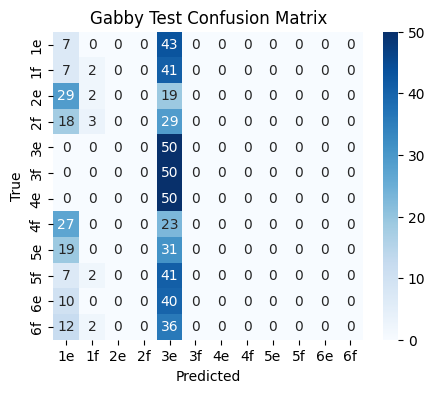

Test Loss: 6.0183 | Test Acc: 0.0983


In [ ]:
# plot confusion matrix on validation set for 12 movements on best model
#############
### test on Gabby dataset
# load the Gabby factors dataset for test
with open(r"G:\project\dataset\Gabby\lfads_factors\lfads_factors_test.pkl", "rb") as f:
    x_f_test, y_f_test = pickle.load(f)

# Create Gabby dataset
gabby_test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loader
gabby_test_loader = torch.utils.data.DataLoader(gabby_test_dataset, batch_size=64, shuffle=False)

# Load best model
model.load_state_dict(torch.load(os.path.join(chp_save, "best_acc_model.pth")))

# Evaluate on gabby test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in gabby_test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Gabby Test Confusion Matrix')

# Evaluate on test set
test_loss, test_acc = evaluate(gabby_test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Setup
chp_save = r'G:\project\lfads_classifier'
os.makedirs(chp_save, exist_ok=True)


# === Init
input_dim = x_f_train.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y_f_train))

model = FactorClassifier(input_dim, hidden_dim, output_dim).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)  
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)
# === Tracking
train_losses = []
val_losses = []
val_accs = []
best_val_loss = float("inf")
best_val_acc = 0.0

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.long().cuda()  # <-- this is the fix
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    return avg_loss, acc

def plot_metrics(train_losses, val_losses, val_accs, path):
    fig, ax1 = plt.subplots()

    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='orange')
    ax1.set_xlabel('Half Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(val_accs, label='Val Acc', color='green')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper right')

    plt.title('Loss and Accuracy')
    fig.tight_layout()
    plt.savefig(os.path.join(path, 'loss_acc_curve.png'))
    plt.close()


# === Training loop
num_epochs = 200
a = 0
log_interval = len(train_loader) 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (factors, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        factors = factors.cuda()
        labels = labels.long().cuda()
        optimizer.zero_grad()
        outputs = model(factors)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * factors.size(0)

        # === Mid-epoch validation
        if (batch_idx + 1) % log_interval == 0 or (batch_idx + 1) == len(train_loader):
            half_epoch = epoch + (batch_idx + 1) / len(train_loader)
            train_loss = running_loss / ((batch_idx + 1) * train_loader.batch_size)
            val_loss, val_acc = evaluate(gabby_test_loader)

            print(f"[{half_epoch:.2f} epochs] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            plot_metrics(train_losses, val_losses, val_accs, chp_save)      

            # Save best checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                ckpt_path = os.path.join(chp_save, "G_best_model.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"✅ Saved best checkpoint to {ckpt_path}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                ckpt_path = os.path.join(chp_save, "G_best_acc_model.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"✅ Saved best accuracy checkpoint to {ckpt_path}")
                
    # Update learning rate
    lr_scheduler.step(val_loss)
    print(f"Updated learning rate to {optimizer.param_groups[0]['lr']:.6f}")


Epoch 1: 100%|██████████| 94/94 [00:00<00:00, 420.12it/s]


[1.00 epochs] Train Loss: 2.4689 | Val Loss: 2.5174 | Val Acc: 0.0833
✅ Saved best checkpoint to G:\project\lfads_classifier\G_best_model.pth
✅ Saved best accuracy checkpoint to G:\project\lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000010


Epoch 2: 100%|██████████| 94/94 [00:00<00:00, 407.50it/s]


[2.00 epochs] Train Loss: 2.4191 | Val Loss: 2.5090 | Val Acc: 0.0833
✅ Saved best checkpoint to G:\project\lfads_classifier\G_best_model.pth
Updated learning rate to 0.000010


Epoch 3: 100%|██████████| 94/94 [00:00<00:00, 396.58it/s]


[3.00 epochs] Train Loss: 2.3762 | Val Loss: 2.5073 | Val Acc: 0.0833
✅ Saved best checkpoint to G:\project\lfads_classifier\G_best_model.pth
Updated learning rate to 0.000010


Epoch 4: 100%|██████████| 94/94 [00:00<00:00, 386.06it/s]


[4.00 epochs] Train Loss: 2.3379 | Val Loss: 2.5098 | Val Acc: 0.0833
Updated learning rate to 0.000010


Epoch 5: 100%|██████████| 94/94 [00:00<00:00, 432.13it/s]


[5.00 epochs] Train Loss: 2.3034 | Val Loss: 2.5146 | Val Acc: 0.0833
Updated learning rate to 0.000010


Epoch 6: 100%|██████████| 94/94 [00:00<00:00, 418.56it/s]


[6.00 epochs] Train Loss: 2.2741 | Val Loss: 2.5209 | Val Acc: 0.0833
Updated learning rate to 0.000010


Epoch 7: 100%|██████████| 94/94 [00:00<00:00, 413.02it/s]


[7.00 epochs] Train Loss: 2.2472 | Val Loss: 2.5278 | Val Acc: 0.0833
Updated learning rate to 0.000010


Epoch 8: 100%|██████████| 94/94 [00:00<00:00, 385.58it/s]


[8.00 epochs] Train Loss: 2.2220 | Val Loss: 2.5354 | Val Acc: 0.0833
Updated learning rate to 0.000010


Epoch 9: 100%|██████████| 94/94 [00:00<00:00, 390.78it/s]


[9.00 epochs] Train Loss: 2.1985 | Val Loss: 2.5439 | Val Acc: 0.0833
Updated learning rate to 0.000008


Epoch 10: 100%|██████████| 94/94 [00:00<00:00, 289.18it/s]


[10.00 epochs] Train Loss: 2.1771 | Val Loss: 2.5500 | Val Acc: 0.0833
Updated learning rate to 0.000008


Epoch 11: 100%|██████████| 94/94 [00:00<00:00, 257.51it/s]


[11.00 epochs] Train Loss: 2.1598 | Val Loss: 2.5561 | Val Acc: 0.0833
Updated learning rate to 0.000008


Epoch 12: 100%|██████████| 94/94 [00:00<00:00, 450.22it/s]


[12.00 epochs] Train Loss: 2.1424 | Val Loss: 2.5626 | Val Acc: 0.0833
Updated learning rate to 0.000008


Epoch 13: 100%|██████████| 94/94 [00:00<00:00, 351.26it/s]


[13.00 epochs] Train Loss: 2.1253 | Val Loss: 2.5700 | Val Acc: 0.0833
Updated learning rate to 0.000008


Epoch 14: 100%|██████████| 94/94 [00:00<00:00, 360.74it/s]


[14.00 epochs] Train Loss: 2.1086 | Val Loss: 2.5771 | Val Acc: 0.0833
Updated learning rate to 0.000008


Epoch 15: 100%|██████████| 94/94 [00:00<00:00, 301.74it/s]


[15.00 epochs] Train Loss: 2.0926 | Val Loss: 2.5839 | Val Acc: 0.0833
Updated learning rate to 0.000006


Epoch 16: 100%|██████████| 94/94 [00:00<00:00, 267.42it/s]


[16.00 epochs] Train Loss: 2.0787 | Val Loss: 2.5890 | Val Acc: 0.0833
Updated learning rate to 0.000006


Epoch 17: 100%|██████████| 94/94 [00:00<00:00, 393.99it/s]


[17.00 epochs] Train Loss: 2.0661 | Val Loss: 2.5952 | Val Acc: 0.0833
Updated learning rate to 0.000006


Epoch 18: 100%|██████████| 94/94 [00:00<00:00, 386.32it/s]


[18.00 epochs] Train Loss: 2.0543 | Val Loss: 2.6018 | Val Acc: 0.0833
Updated learning rate to 0.000006


Epoch 19: 100%|██████████| 94/94 [00:00<00:00, 252.78it/s]


[19.00 epochs] Train Loss: 2.0420 | Val Loss: 2.6098 | Val Acc: 0.0833
Updated learning rate to 0.000006


Epoch 20: 100%|██████████| 94/94 [00:00<00:00, 394.59it/s]


[20.00 epochs] Train Loss: 2.0294 | Val Loss: 2.6165 | Val Acc: 0.0833
Updated learning rate to 0.000006


Epoch 21: 100%|██████████| 94/94 [00:00<00:00, 419.61it/s]


[21.00 epochs] Train Loss: 2.0187 | Val Loss: 2.6225 | Val Acc: 0.0833
Updated learning rate to 0.000005


Epoch 22: 100%|██████████| 94/94 [00:00<00:00, 259.53it/s]


[22.00 epochs] Train Loss: 2.0092 | Val Loss: 2.6269 | Val Acc: 0.0833
Updated learning rate to 0.000005


Epoch 23: 100%|██████████| 94/94 [00:00<00:00, 266.63it/s]


[23.00 epochs] Train Loss: 2.0011 | Val Loss: 2.6320 | Val Acc: 0.0833
Updated learning rate to 0.000005


Epoch 24:   0%|          | 0/94 [00:00<?, ?it/s]

[24.00 epochs] Train Loss: 1.9931 | Val Loss: 2.6377 | Val Acc: 0.0833


Epoch 24: 100%|██████████| 94/94 [00:00<00:00, 436.24it/s]


Updated learning rate to 0.000005


Epoch 25:  89%|████████▉ | 84/94 [00:00<00:00, 963.41it/s]


KeyboardInterrupt: 

In [ ]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import numpy as np

def align_factors_with_cca(x_src, y_src, x_tgt, y_tgt, num_components=100):
    """
    Aligns Gabby's factors to source monkey's factor space using CCA.
    
    Args:
        x_src: (N_src, D) LFADS factors from source monkey.
        y_src: (N_src,) labels for source monkey.
        x_tgt: (N_tgt, D) LFADS factors from target monkey (Gabby).
        y_tgt: (N_tgt,) labels for target monkey.
        num_components: number of CCA dimensions.
    
    Returns:
        x_tgt_aligned: Gabby factors projected into CCA space aligned to source.
    """
    cca = CCA(n_components=num_components)
    X_src_concat = []
    X_tgt_concat = []

    for cls in np.unique(y_src):
        src_cls_idx = np.where(y_src == cls)[0]
        tgt_cls_idx = np.where(y_tgt == cls)[0]
        n_common = min(len(src_cls_idx), len(tgt_cls_idx))
        if n_common < 5:
            continue  # skip if not enough samples

        X_src_concat.append(x_src[src_cls_idx[:n_common]])
        X_tgt_concat.append(x_tgt[tgt_cls_idx[:n_common]])

    X_src_concat = np.concatenate(X_src_concat, axis=0)
    X_tgt_concat = np.concatenate(X_tgt_concat, axis=0)

    # Standardize before CCA
    scaler_src = StandardScaler().fit(X_src_concat)
    scaler_tgt = StandardScaler().fit(X_tgt_concat)

    X_src_std = scaler_src.transform(X_src_concat)
    X_tgt_std = scaler_tgt.transform(X_tgt_concat)

    # Fit CCA
    cca.fit(X_tgt_std, X_src_std)

    # Project Gabby data
    x_tgt_std = scaler_tgt.transform(x_tgt)
    x_tgt_aligned = cca.transform(x_tgt_std)

    return x_tgt_aligned

with open(r"G:\project\dataset\Gabby\lfads_factors\lfads_factors_test.pkl", "rb") as f:
    x_f_gabby, y_f_gabby = pickle.load(f)

x_f_gabby_aligned = align_factors_with_cca(
    x_src=x_f_train,
    y_src=y_f_train,
    x_tgt=x_f_gabby,
    y_tgt=y_f_gabby,
    num_components=100  
)


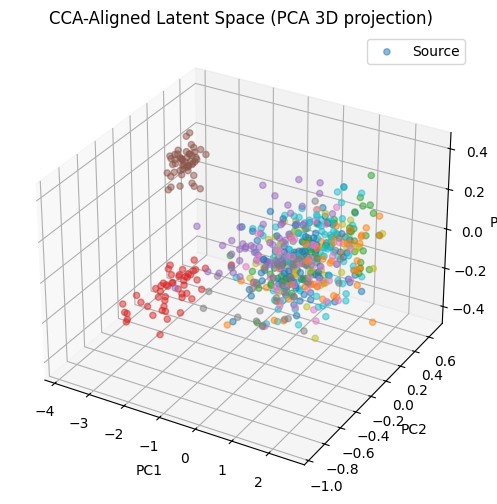

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
src_2d = pca.fit_transform(x_f_gabby)
# gabby_2d = pca.transform(x_f_gabby_aligned)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc1 = ax.scatter(src_2d[:, 0], src_2d[:, 1], src_2d[:, 2], c=y_f_gabby, cmap='tab10', alpha=0.5, label='Source')
# sc2 = ax.scatter(gabby_2d[:, 0], gabby_2d[:, 1], gabby_2d[:, 2], c=y_f_gabby, cmap='tab10', marker='x', label='Gabby')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.title("CCA-Aligned Latent Space (PCA 3D projection)")
plt.savefig(os.path.join(chp_save, "cca_aligned_latent_space_3d.png"))
plt.show()


In [ ]:
# plot confusion matrix on validation set for 12 movements on best model
#############
### test on Gabby dataset
# load the Gabby factors dataset for test
with open(r"G:\project\dataset\Gabby\lfads_factors\lfads_factors_test.pkl", "rb") as f:
    x_f_test, y_f_test = pickle.load(f)

# Create Gabby dataset
gabby_test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loader
gabby_test_loader = torch.utils.data.DataLoader(gabby_test_dataset, batch_size=64, shuffle=False)

# Load best model
model.load_state_dict(torch.load(os.path.join(chp_save, "best_acc_model.pth")))

# Evaluate on gabby test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in gabby_test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Gabby Test Confusion Matrix')

# Evaluate on test set
test_loss, test_acc = evaluate(gabby_test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


In [ ]:
# make gabby factors dataset for lfads using hydra
import numpy as np
import pickle
import h5py
import os
# === Load spike input ===
x_gabby_test = np.load(r"dataset\Gabby\test\X_long.npy")
# Crop time axis to [100:900]   # axes are [trials, channels, time]
x_gabby_test = x_gabby_test[:, :, 100:900]
# remove three channels that are all zeros
print(f'X_test shape: {x_gabby_test.shape}')
# Find channels that are all zeros across all trials and time bins
zero_channels = np.where(np.all(x_gabby_test == 0, axis=(0, 2)))[0]
print(f"Zero channels: {zero_channels}")
# Remove those channels
x_gabby_test = np.delete(x_gabby_test, zero_channels[:3], axis=1)
print(f'X_test shape: {x_gabby_test.shape}')


save_path = "dataset/Chip/lfads_filtered"
os.makedirs(save_path, exist_ok=True)

# Transpose to [N, T, C]
train_encod = x_gabby_test.transpose(0, 2, 1)  # spike:  N x T x channels
train_recon = x_gabby_test.transpose(0, 2, 1)  # spike:  N x T x channels

# Split 80/20 train/val
#shuffle before splitting
np.random.seed(42)  # For reproducibility
indices = np.random.permutation(train_encod.shape[0])
train_encod = train_encod[indices]
train_recon = train_recon[indices]
# Split into 80% train and 20% validation
n_total = train_encod.shape[0]
n_train = int(0.8 * n_total)

train_encod_split = train_encod[:n_train]
train_recon_split = train_recon[:n_train]
valid_encod_split = train_encod[n_train:]
valid_recon_split = train_recon[n_train:]
# print shapes
print(f"Train Encod Shape: {train_encod_split.shape}")  # Should be [N_train, T, C]
print(f"Train Recon Shape: {train_recon_split.shape}")  # Should be [N_train, T, C]
print(f"Valid Encod Shape: {valid_encod_split.shape}")  # Should be [N_valid, T, C]
print(f"Valid Recon Shape: {valid_recon_split.shape}")  # Should be [N_valid, T, C]

save_path = r"G:\project\lfads-torch\datasets"
# === Save for LFADS training (spike → spikes)
with h5py.File(os.path.join(save_path, "spike_gabby_data.h5"), "w") as f:
    f.create_dataset("train_encod_data", data=train_encod_split)
    f.create_dataset("train_recon_data", data=train_recon_split)
    f.create_dataset("valid_encod_data", data=valid_encod_split)
    f.create_dataset("valid_recon_data", data=valid_recon_split)

print("✅ Saved filtered LFADS spike→EMG data to lfads_data_filtered.h5")


X_test shape: (600, 155, 800)
Zero channels: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154]
X_test shape: (600, 152, 800)
Train Encod Shape: (480, 800, 152)
Train Recon Shape: (480, 800, 152)
Valid Encod Shape: (120, 800, 152)
Valid Recon Shape: (120, 800, 152)
✅ Saved filtered LFADS spike→EMG data to lfads_data_filtered.h5


array([[[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

Classifier using cnn

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
# Define a single Residual Block with 50% dropout after each convolution
class ResidualBlock(nn.Module):
    def __init__(self, in_channels , dropout=0.2):
        super().__init__()

        # Direct (main) path
        self.direct_path = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.Dropout(dropout),
            nn.ReLU()
        )

        # Skip (shortcut) path
        self.skip_layers = nn.Conv1d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        direct_out = self.direct_path(x)
        skip_out = self.skip_layers(x)
        out = direct_out + skip_out
        return torch.relu(out)

# Now define a small network using several Residual Blocks
class ResidualNet1D(nn.Module):
    def __init__(self, in_channels, num_classes , dropout=0.2):
        super().__init__()

        # Initial convolution (to go to a working channel size)
        self.initial = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=7, padding=3),
            nn.Dropout(dropout),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        # Stack of Residual Blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(16),
            ResidualBlock(16),
            ResidualBlock(16),
        )

        # Pooling and final classification layer
        self.pool = nn.AdaptiveAvgPool1d(1)  # Output: [batch, 16, 1]
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.pool(x).squeeze(-1)  # shape [batch_size, 16]
        x = self.fc(x)
        return x
    
    
## data loader
class FactorDataset(torch.utils.data.Dataset):
    def __init__(self, factors, labels):
        self.factors = factors
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.factors[idx], self.labels[idx]
    
# load the factors dataset for Chip training
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_train.pkl", "rb") as f:
    x_f_train, y_f_train = pickle.load(f)
# load the factors dataset for Chip validation
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_val.pkl", "rb") as f:
    x_f_val, y_f_val = pickle.load(f)
# load the factors dataset for Chip test
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_test.pkl", "rb") as f:
    x_f_test, y_f_test = pickle.load(f)

# Create datasets
train_dataset = FactorDataset(x_f_train, y_f_train)
val_dataset = FactorDataset(x_f_val, y_f_val)
test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
### lets build a classifier and train it on the C_factors to distinguish between movements
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## data loader
class FactorDataset(torch.utils.data.Dataset):
    def __init__(self, factors, labels):
        self.factors = factors.transpose(0,2,1)  # [B, T, F] to [B, F, T]
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.factors[idx], self.labels[idx]
    
# load the factors dataset for Chip training
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_train.pkl", "rb") as f:
    x_f_train, y_f_train = pickle.load(f)
# load the factors dataset for Chip validation
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_val.pkl", "rb") as f:
    x_f_val, y_f_val = pickle.load(f)
# load the factors dataset for Chip test
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_test.pkl", "rb") as f:
    x_f_test, y_f_test = pickle.load(f)

# Create datasets
train_dataset = FactorDataset(x_f_train, y_f_train)
val_dataset = FactorDataset(x_f_val, y_f_val)
test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Setup
chp_save = r'G:\project\CNN_lfads_classifier'
os.makedirs(chp_save, exist_ok=True)


# === Init
input_dim = x_f_train.shape[2]
hidden_dim = 128
output_dim = len(np.unique(y_f_train))
print(f"Input Dim: {input_dim}, Output Dim: {output_dim}")
model = ResidualNet1D(in_channels=input_dim, num_classes=output_dim, dropout=0.2).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# === Tracking
train_losses = []
val_losses = []
val_accs = []
best_val_loss = float("inf")
best_val_acc = 0.0

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.long().cuda()  # <-- this is the fix
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    return avg_loss, acc

def plot_metrics(train_losses, val_losses, val_accs, path):
    fig, ax1 = plt.subplots()

    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='orange')
    ax1.set_xlabel('Half Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(val_accs, label='Val Acc', color='green')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper right')

    plt.title('Loss and Accuracy')
    fig.tight_layout()
    plt.savefig(os.path.join(path, 'loss_acc_curve.png'))
    plt.close()


# === Training loop
num_epochs = 200
a = 0
log_interval = len(train_loader) 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (factors, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        factors = factors.cuda()
        labels = labels.long().cuda()
        optimizer.zero_grad()
        outputs = model(factors)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * factors.size(0)

        # === Mid-epoch validation
        if (batch_idx + 1) % log_interval == 0 or (batch_idx + 1) == len(train_loader):
            half_epoch = epoch + (batch_idx + 1) / len(train_loader)
            train_loss = running_loss / ((batch_idx + 1) * train_loader.batch_size)
            val_loss, val_acc = evaluate(val_loader)

            print(f"[{half_epoch:.2f} epochs] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            plot_metrics(train_losses, val_losses, val_accs, chp_save)      

            # Save best checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                ckpt_path = os.path.join(chp_save, "G_best_model.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"✅ Saved best checkpoint to {ckpt_path}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                ckpt_path = os.path.join(chp_save, "G_best_acc_model.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"✅ Saved best accuracy checkpoint to {ckpt_path}")
                
    # Update learning rate
    lr_scheduler.step(val_loss)
    print(f"Updated learning rate to {optimizer.param_groups[0]['lr']:.6f}")

Input Dim: 100, Output Dim: 12


Epoch 1: 100%|██████████| 94/94 [00:01<00:00, 86.42it/s] 


[1.00 epochs] Train Loss: 2.4431 | Val Loss: 2.3962 | Val Acc: 0.1667
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 2: 100%|██████████| 94/94 [00:01<00:00, 93.37it/s] 


[2.00 epochs] Train Loss: 2.2095 | Val Loss: 2.1678 | Val Acc: 0.1083
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
Updated learning rate to 0.000100


Epoch 3: 100%|██████████| 94/94 [00:00<00:00, 96.97it/s] 


[3.00 epochs] Train Loss: 1.9516 | Val Loss: 1.9877 | Val Acc: 0.3183
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 4: 100%|██████████| 94/94 [00:01<00:00, 86.52it/s] 


[4.00 epochs] Train Loss: 1.6651 | Val Loss: 1.8728 | Val Acc: 0.2717
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
Updated learning rate to 0.000100


Epoch 5: 100%|██████████| 94/94 [00:00<00:00, 96.77it/s] 


[5.00 epochs] Train Loss: 1.4599 | Val Loss: 1.6115 | Val Acc: 0.2950
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
Updated learning rate to 0.000100


Epoch 6: 100%|██████████| 94/94 [00:01<00:00, 87.25it/s] 


[6.00 epochs] Train Loss: 1.2365 | Val Loss: 1.3942 | Val Acc: 0.5017
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 7: 100%|██████████| 94/94 [00:01<00:00, 83.77it/s] 


[7.00 epochs] Train Loss: 1.0272 | Val Loss: 2.5777 | Val Acc: 0.2033
Updated learning rate to 0.000100


Epoch 8: 100%|██████████| 94/94 [00:00<00:00, 94.11it/s] 


[8.00 epochs] Train Loss: 0.7963 | Val Loss: 1.7022 | Val Acc: 0.3217
Updated learning rate to 0.000100


Epoch 9: 100%|██████████| 94/94 [00:01<00:00, 86.39it/s] 


[9.00 epochs] Train Loss: 0.5899 | Val Loss: 1.8358 | Val Acc: 0.2883
Updated learning rate to 0.000100


Epoch 10: 100%|██████████| 94/94 [00:00<00:00, 97.97it/s] 


[10.00 epochs] Train Loss: 0.4505 | Val Loss: 2.8046 | Val Acc: 0.2150
Updated learning rate to 0.000100


Epoch 11: 100%|██████████| 94/94 [00:00<00:00, 99.97it/s] 


[11.00 epochs] Train Loss: 0.3622 | Val Loss: 1.7555 | Val Acc: 0.4033
Updated learning rate to 0.000100


Epoch 12: 100%|██████████| 94/94 [00:00<00:00, 94.37it/s] 


[12.00 epochs] Train Loss: 0.3289 | Val Loss: 1.4913 | Val Acc: 0.6133
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000050


Epoch 13: 100%|██████████| 94/94 [00:01<00:00, 88.24it/s] 


[13.00 epochs] Train Loss: 0.2901 | Val Loss: 0.5890 | Val Acc: 0.7600
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000050


Epoch 14:  96%|█████████▌| 90/94 [00:00<00:00, 122.98it/s]

[14.00 epochs] Train Loss: 0.2769 | Val Loss: 1.5724 | Val Acc: 0.4700


Epoch 14: 100%|██████████| 94/94 [00:01<00:00, 64.11it/s] 


Updated learning rate to 0.000050


Epoch 15: 100%|██████████| 94/94 [00:01<00:00, 87.35it/s] 


[15.00 epochs] Train Loss: 0.2659 | Val Loss: 0.7612 | Val Acc: 0.7067
Updated learning rate to 0.000050


Epoch 16: 100%|██████████| 94/94 [00:00<00:00, 95.90it/s] 


[16.00 epochs] Train Loss: 0.2377 | Val Loss: 0.8673 | Val Acc: 0.6317
Updated learning rate to 0.000050


Epoch 17: 100%|██████████| 94/94 [00:00<00:00, 95.45it/s] 


[17.00 epochs] Train Loss: 0.2333 | Val Loss: 0.5017 | Val Acc: 0.7967
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000050


Epoch 18: 100%|██████████| 94/94 [00:00<00:00, 98.66it/s] 


[18.00 epochs] Train Loss: 0.2361 | Val Loss: 0.7376 | Val Acc: 0.7200
Updated learning rate to 0.000050


Epoch 19: 100%|██████████| 94/94 [00:00<00:00, 97.40it/s] 


[19.00 epochs] Train Loss: 0.2265 | Val Loss: 1.6853 | Val Acc: 0.5967
Updated learning rate to 0.000050


Epoch 20: 100%|██████████| 94/94 [00:01<00:00, 91.73it/s] 


[20.00 epochs] Train Loss: 0.2075 | Val Loss: 1.0239 | Val Acc: 0.6567
Updated learning rate to 0.000050


Epoch 21: 100%|██████████| 94/94 [00:01<00:00, 91.42it/s] 


[21.00 epochs] Train Loss: 0.2064 | Val Loss: 0.4317 | Val Acc: 0.8000
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000050


Epoch 22: 100%|██████████| 94/94 [00:00<00:00, 97.73it/s] 


[22.00 epochs] Train Loss: 0.1973 | Val Loss: 0.8093 | Val Acc: 0.6500
Updated learning rate to 0.000050


Epoch 23: 100%|██████████| 94/94 [00:00<00:00, 99.34it/s] 


[23.00 epochs] Train Loss: 0.1907 | Val Loss: 0.9311 | Val Acc: 0.6500
Updated learning rate to 0.000050


Epoch 24: 100%|██████████| 94/94 [00:01<00:00, 92.95it/s] 


[24.00 epochs] Train Loss: 0.1839 | Val Loss: 0.8468 | Val Acc: 0.6983
Updated learning rate to 0.000050


Epoch 25: 100%|██████████| 94/94 [00:00<00:00, 96.46it/s] 


[25.00 epochs] Train Loss: 0.1860 | Val Loss: 0.5308 | Val Acc: 0.7733
Updated learning rate to 0.000050


Epoch 26: 100%|██████████| 94/94 [00:01<00:00, 93.33it/s] 


[26.00 epochs] Train Loss: 0.1776 | Val Loss: 0.4675 | Val Acc: 0.8167
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000050


Epoch 27: 100%|██████████| 94/94 [00:00<00:00, 94.43it/s] 


[27.00 epochs] Train Loss: 0.1692 | Val Loss: 0.6478 | Val Acc: 0.7150
Updated learning rate to 0.000025


Epoch 28: 100%|██████████| 94/94 [00:00<00:00, 96.75it/s] 


[28.00 epochs] Train Loss: 0.1580 | Val Loss: 0.4948 | Val Acc: 0.8017
Updated learning rate to 0.000025


Epoch 29: 100%|██████████| 94/94 [00:01<00:00, 92.29it/s] 


[29.00 epochs] Train Loss: 0.1568 | Val Loss: 0.4677 | Val Acc: 0.8367
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000025


Epoch 30: 100%|██████████| 94/94 [00:00<00:00, 97.40it/s] 


[30.00 epochs] Train Loss: 0.1577 | Val Loss: 1.0908 | Val Acc: 0.5217
Updated learning rate to 0.000025


Epoch 31: 100%|██████████| 94/94 [00:01<00:00, 88.98it/s] 


[31.00 epochs] Train Loss: 0.1482 | Val Loss: 0.3082 | Val Acc: 0.8717
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000025


Epoch 32: 100%|██████████| 94/94 [00:00<00:00, 98.27it/s] 


[32.00 epochs] Train Loss: 0.1472 | Val Loss: 0.3293 | Val Acc: 0.8783
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000025


Epoch 33: 100%|██████████| 94/94 [00:01<00:00, 93.82it/s] 


[33.00 epochs] Train Loss: 0.1445 | Val Loss: 0.5353 | Val Acc: 0.8400
Updated learning rate to 0.000025


Epoch 34: 100%|██████████| 94/94 [00:00<00:00, 95.22it/s] 


[34.00 epochs] Train Loss: 0.1438 | Val Loss: 0.2515 | Val Acc: 0.8917
✅ Saved best checkpoint to G:\project\CNN_lfads_classifier\G_best_model.pth
✅ Saved best accuracy checkpoint to G:\project\CNN_lfads_classifier\G_best_acc_model.pth
Updated learning rate to 0.000025


Epoch 35: 100%|██████████| 94/94 [00:01<00:00, 93.23it/s] 


[35.00 epochs] Train Loss: 0.1403 | Val Loss: 0.4784 | Val Acc: 0.8267
Updated learning rate to 0.000025


Epoch 36: 100%|██████████| 94/94 [00:00<00:00, 95.22it/s] 


[36.00 epochs] Train Loss: 0.1407 | Val Loss: 0.3526 | Val Acc: 0.8600
Updated learning rate to 0.000025


Epoch 37: 100%|██████████| 94/94 [00:00<00:00, 96.97it/s] 


[37.00 epochs] Train Loss: 0.1346 | Val Loss: 0.3988 | Val Acc: 0.8517
Updated learning rate to 0.000025


Epoch 38: 100%|██████████| 94/94 [00:01<00:00, 77.80it/s] 


[38.00 epochs] Train Loss: 0.1360 | Val Loss: 0.3342 | Val Acc: 0.8667
Updated learning rate to 0.000025


Epoch 39: 100%|██████████| 94/94 [00:01<00:00, 90.50it/s] 


[39.00 epochs] Train Loss: 0.1303 | Val Loss: 0.5169 | Val Acc: 0.7917
Updated learning rate to 0.000025


Epoch 40: 100%|██████████| 94/94 [00:00<00:00, 94.45it/s] 


[40.00 epochs] Train Loss: 0.1311 | Val Loss: 0.3708 | Val Acc: 0.8583
Updated learning rate to 0.000013


Epoch 41:  93%|█████████▎| 87/94 [00:00<00:00, 106.76it/s]

[41.00 epochs] Train Loss: 0.1302 | Val Loss: 0.3999 | Val Acc: 0.8317


Epoch 41: 100%|██████████| 94/94 [00:01<00:00, 76.80it/s] 


Updated learning rate to 0.000013


Epoch 42: 100%|██████████| 94/94 [00:01<00:00, 93.10it/s] 


[42.00 epochs] Train Loss: 0.1290 | Val Loss: 0.3672 | Val Acc: 0.8767
Updated learning rate to 0.000013


Epoch 43: 100%|██████████| 94/94 [00:00<00:00, 95.48it/s] 


[43.00 epochs] Train Loss: 0.1235 | Val Loss: 0.3093 | Val Acc: 0.8783
Updated learning rate to 0.000013


Epoch 44: 100%|██████████| 94/94 [00:00<00:00, 94.29it/s] 


[44.00 epochs] Train Loss: 0.1241 | Val Loss: 0.3286 | Val Acc: 0.8683
Updated learning rate to 0.000013


Epoch 45: 100%|██████████| 94/94 [00:01<00:00, 93.23it/s] 


[45.00 epochs] Train Loss: 0.1264 | Val Loss: 0.3226 | Val Acc: 0.8550
Updated learning rate to 0.000013


Epoch 46: 100%|██████████| 94/94 [00:00<00:00, 98.04it/s] 


[46.00 epochs] Train Loss: 0.1186 | Val Loss: 0.3614 | Val Acc: 0.8550
Updated learning rate to 0.000006


Epoch 47: 100%|██████████| 94/94 [00:00<00:00, 94.86it/s] 


[47.00 epochs] Train Loss: 0.1196 | Val Loss: 0.3664 | Val Acc: 0.8500
Updated learning rate to 0.000006


Epoch 48: 100%|██████████| 94/94 [00:01<00:00, 89.39it/s] 


[48.00 epochs] Train Loss: 0.1215 | Val Loss: 0.3080 | Val Acc: 0.8750
Updated learning rate to 0.000006


Epoch 49: 100%|██████████| 94/94 [00:01<00:00, 91.21it/s] 


[49.00 epochs] Train Loss: 0.1170 | Val Loss: 0.3400 | Val Acc: 0.8650
Updated learning rate to 0.000006


Epoch 50: 100%|██████████| 94/94 [00:00<00:00, 98.23it/s] 


[50.00 epochs] Train Loss: 0.1175 | Val Loss: 0.3875 | Val Acc: 0.8583
Updated learning rate to 0.000006


Epoch 51: 100%|██████████| 94/94 [00:01<00:00, 89.75it/s] 


[51.00 epochs] Train Loss: 0.1220 | Val Loss: 0.3212 | Val Acc: 0.8783
Updated learning rate to 0.000006


Epoch 52: 100%|██████████| 94/94 [00:00<00:00, 96.31it/s] 


[52.00 epochs] Train Loss: 0.1198 | Val Loss: 0.3715 | Val Acc: 0.8600
Updated learning rate to 0.000003


Epoch 53: 100%|██████████| 94/94 [00:00<00:00, 95.07it/s] 


[53.00 epochs] Train Loss: 0.1177 | Val Loss: 0.3295 | Val Acc: 0.8717
Updated learning rate to 0.000003


Epoch 54: 100%|██████████| 94/94 [00:00<00:00, 104.43it/s]


[54.00 epochs] Train Loss: 0.1194 | Val Loss: 0.3948 | Val Acc: 0.8650
Updated learning rate to 0.000003


Epoch 55: 100%|██████████| 94/94 [00:00<00:00, 96.36it/s] 


[55.00 epochs] Train Loss: 0.1177 | Val Loss: 0.3527 | Val Acc: 0.8683
Updated learning rate to 0.000003


Epoch 56: 100%|██████████| 94/94 [00:00<00:00, 96.37it/s] 


[56.00 epochs] Train Loss: 0.1161 | Val Loss: 0.3721 | Val Acc: 0.8633
Updated learning rate to 0.000003


Epoch 57: 100%|██████████| 94/94 [00:00<00:00, 103.98it/s]


[57.00 epochs] Train Loss: 0.1154 | Val Loss: 0.3431 | Val Acc: 0.8667
Updated learning rate to 0.000003


Epoch 58:  89%|████████▉ | 84/94 [00:00<00:00, 111.72it/s]

[58.00 epochs] Train Loss: 0.1123 | Val Loss: 0.3183 | Val Acc: 0.8717


Epoch 58: 100%|██████████| 94/94 [00:01<00:00, 75.77it/s] 


Updated learning rate to 0.000002


Epoch 59:  98%|█████████▊| 92/94 [00:01<00:00, 55.16it/s]

[59.00 epochs] Train Loss: 0.1203 | Val Loss: 0.3420 | Val Acc: 0.8683


Epoch 59: 100%|██████████| 94/94 [00:02<00:00, 44.08it/s]


Updated learning rate to 0.000002


Epoch 60: 100%|██████████| 94/94 [00:02<00:00, 34.07it/s]


[60.00 epochs] Train Loss: 0.1126 | Val Loss: 0.2801 | Val Acc: 0.8850
Updated learning rate to 0.000002


Epoch 61:  98%|█████████▊| 92/94 [00:02<00:00, 32.56it/s]

[61.00 epochs] Train Loss: 0.1155 | Val Loss: 0.3336 | Val Acc: 0.8750


Epoch 61: 100%|██████████| 94/94 [00:03<00:00, 27.99it/s]


Updated learning rate to 0.000002


Epoch 62:  96%|█████████▌| 90/94 [00:02<00:00, 32.10it/s]

[62.00 epochs] Train Loss: 0.1169 | Val Loss: 0.3003 | Val Acc: 0.8767


Epoch 62: 100%|██████████| 94/94 [00:03<00:00, 28.85it/s]


Updated learning rate to 0.000002


Epoch 63:  97%|█████████▋| 91/94 [00:02<00:00, 32.95it/s]

[63.00 epochs] Train Loss: 0.1159 | Val Loss: 0.3236 | Val Acc: 0.8717


Epoch 63: 100%|██████████| 94/94 [00:03<00:00, 28.25it/s]


Updated learning rate to 0.000002


Epoch 64:  99%|█████████▉| 93/94 [00:02<00:00, 31.37it/s]

[64.00 epochs] Train Loss: 0.1169 | Val Loss: 0.3146 | Val Acc: 0.8800


Epoch 64: 100%|██████████| 94/94 [00:03<00:00, 27.75it/s]


Updated learning rate to 0.000001


Epoch 65:  99%|█████████▉| 93/94 [00:02<00:00, 31.82it/s]

[65.00 epochs] Train Loss: 0.1174 | Val Loss: 0.2956 | Val Acc: 0.8767


Epoch 65: 100%|██████████| 94/94 [00:03<00:00, 27.67it/s]


Updated learning rate to 0.000001


Epoch 66:  98%|█████████▊| 92/94 [00:02<00:00, 42.07it/s]

[66.00 epochs] Train Loss: 0.1131 | Val Loss: 0.3274 | Val Acc: 0.8700


Epoch 66: 100%|██████████| 94/94 [00:02<00:00, 33.02it/s]


Updated learning rate to 0.000001


Epoch 67:  97%|█████████▋| 91/94 [00:02<00:00, 35.41it/s]

[67.00 epochs] Train Loss: 0.1162 | Val Loss: 0.3161 | Val Acc: 0.8767


Epoch 67: 100%|██████████| 94/94 [00:02<00:00, 34.01it/s]


Updated learning rate to 0.000001


Epoch 68:  96%|█████████▌| 90/94 [00:02<00:00, 32.96it/s]

[68.00 epochs] Train Loss: 0.1146 | Val Loss: 0.3198 | Val Acc: 0.8733


Epoch 68: 100%|██████████| 94/94 [00:03<00:00, 28.93it/s]


Updated learning rate to 0.000001


Epoch 69:  98%|█████████▊| 92/94 [00:02<00:00, 31.85it/s]

[69.00 epochs] Train Loss: 0.1150 | Val Loss: 0.3345 | Val Acc: 0.8633


Epoch 69: 100%|██████████| 94/94 [00:03<00:00, 28.22it/s]


Updated learning rate to 0.000001


Epoch 70:  98%|█████████▊| 92/94 [00:02<00:00, 31.95it/s]

[70.00 epochs] Train Loss: 0.1105 | Val Loss: 0.3207 | Val Acc: 0.8750


Epoch 70: 100%|██████████| 94/94 [00:03<00:00, 28.14it/s]


Updated learning rate to 0.000000


Epoch 71:  98%|█████████▊| 92/94 [00:02<00:00, 34.85it/s]

[71.00 epochs] Train Loss: 0.1135 | Val Loss: 0.2863 | Val Acc: 0.8850


Epoch 71: 100%|██████████| 94/94 [00:03<00:00, 28.48it/s]


Updated learning rate to 0.000000


Epoch 72:  98%|█████████▊| 92/94 [00:02<00:00, 35.16it/s]

[72.00 epochs] Train Loss: 0.1215 | Val Loss: 0.3247 | Val Acc: 0.8750


Epoch 72: 100%|██████████| 94/94 [00:03<00:00, 28.81it/s]


Updated learning rate to 0.000000


Epoch 73:  99%|█████████▉| 93/94 [00:06<00:00,  7.07it/s]

[73.00 epochs] Train Loss: 0.1140 | Val Loss: 0.3490 | Val Acc: 0.8717


Epoch 73: 100%|██████████| 94/94 [00:07<00:00, 12.03it/s]


Updated learning rate to 0.000000


Epoch 74:  98%|█████████▊| 92/94 [00:02<00:00, 32.75it/s]

[74.00 epochs] Train Loss: 0.1161 | Val Loss: 0.3404 | Val Acc: 0.8750


Epoch 74: 100%|██████████| 94/94 [00:03<00:00, 25.97it/s]


Updated learning rate to 0.000000


Epoch 75:  98%|█████████▊| 92/94 [00:02<00:00, 43.80it/s]

[75.00 epochs] Train Loss: 0.1157 | Val Loss: 0.3219 | Val Acc: 0.8700


Epoch 75: 100%|██████████| 94/94 [00:02<00:00, 34.59it/s]


Updated learning rate to 0.000000


Epoch 76:  99%|█████████▉| 93/94 [00:02<00:00, 37.69it/s]

[76.00 epochs] Train Loss: 0.1155 | Val Loss: 0.3071 | Val Acc: 0.8750


Epoch 76: 100%|██████████| 94/94 [00:02<00:00, 34.82it/s]


Updated learning rate to 0.000000


Epoch 77:  99%|█████████▉| 93/94 [00:02<00:00, 33.12it/s]

[77.00 epochs] Train Loss: 0.1108 | Val Loss: 0.3009 | Val Acc: 0.8783


Epoch 77: 100%|██████████| 94/94 [00:03<00:00, 29.63it/s]


Updated learning rate to 0.000000


Epoch 78:  98%|█████████▊| 92/94 [00:02<00:00, 43.71it/s]

[78.00 epochs] Train Loss: 0.1145 | Val Loss: 0.3156 | Val Acc: 0.8750


Epoch 78: 100%|██████████| 94/94 [00:02<00:00, 31.59it/s]


Updated learning rate to 0.000000


Epoch 79:  96%|█████████▌| 90/94 [00:02<00:00, 42.93it/s]

[79.00 epochs] Train Loss: 0.1175 | Val Loss: 0.3298 | Val Acc: 0.8750


Epoch 79: 100%|██████████| 94/94 [00:02<00:00, 34.32it/s]


Updated learning rate to 0.000000


Epoch 80:  98%|█████████▊| 92/94 [00:02<00:00, 37.01it/s]

[80.00 epochs] Train Loss: 0.1127 | Val Loss: 0.3382 | Val Acc: 0.8667


Epoch 80: 100%|██████████| 94/94 [00:02<00:00, 33.81it/s]


Updated learning rate to 0.000000


Epoch 81:  98%|█████████▊| 92/94 [00:02<00:00, 34.83it/s]

[81.00 epochs] Train Loss: 0.1146 | Val Loss: 0.3068 | Val Acc: 0.8800


Epoch 81: 100%|██████████| 94/94 [00:03<00:00, 28.79it/s]


Updated learning rate to 0.000000


Epoch 82:  98%|█████████▊| 92/94 [00:02<00:00, 36.78it/s]

[82.00 epochs] Train Loss: 0.1160 | Val Loss: 0.3456 | Val Acc: 0.8683


Epoch 82: 100%|██████████| 94/94 [00:03<00:00, 29.66it/s]


Updated learning rate to 0.000000


Epoch 83:  97%|█████████▋| 91/94 [00:02<00:00, 39.73it/s]

[83.00 epochs] Train Loss: 0.1183 | Val Loss: 0.3130 | Val Acc: 0.8783


Epoch 83: 100%|██████████| 94/94 [00:02<00:00, 33.54it/s]


Updated learning rate to 0.000000


Epoch 84:  97%|█████████▋| 91/94 [00:02<00:00, 33.47it/s]

[84.00 epochs] Train Loss: 0.1118 | Val Loss: 0.3272 | Val Acc: 0.8750


Epoch 84: 100%|██████████| 94/94 [00:03<00:00, 29.67it/s]


Updated learning rate to 0.000000


Epoch 85:  99%|█████████▉| 93/94 [00:02<00:00, 34.78it/s]

[85.00 epochs] Train Loss: 0.1108 | Val Loss: 0.3119 | Val Acc: 0.8783


Epoch 85: 100%|██████████| 94/94 [00:03<00:00, 30.85it/s]


Updated learning rate to 0.000000


Epoch 86:  99%|█████████▉| 93/94 [00:02<00:00, 38.23it/s]

[86.00 epochs] Train Loss: 0.1074 | Val Loss: 0.3298 | Val Acc: 0.8733


Epoch 86: 100%|██████████| 94/94 [00:03<00:00, 29.36it/s]


Updated learning rate to 0.000000


Epoch 87:  99%|█████████▉| 93/94 [00:02<00:00, 37.81it/s]

[87.00 epochs] Train Loss: 0.1098 | Val Loss: 0.3166 | Val Acc: 0.8750


Epoch 87: 100%|██████████| 94/94 [00:02<00:00, 31.70it/s]


Updated learning rate to 0.000000


Epoch 88:  97%|█████████▋| 91/94 [00:02<00:00, 34.45it/s]

[88.00 epochs] Train Loss: 0.1094 | Val Loss: 0.3294 | Val Acc: 0.8767


Epoch 88: 100%|██████████| 94/94 [00:03<00:00, 30.71it/s]


Updated learning rate to 0.000000


Epoch 89:  99%|█████████▉| 93/94 [00:02<00:00, 38.11it/s]

[89.00 epochs] Train Loss: 0.1136 | Val Loss: 0.2811 | Val Acc: 0.8800


Epoch 89: 100%|██████████| 94/94 [00:03<00:00, 29.25it/s]


Updated learning rate to 0.000000


Epoch 90:  96%|█████████▌| 90/94 [00:02<00:00, 37.09it/s]

[90.00 epochs] Train Loss: 0.1153 | Val Loss: 0.3529 | Val Acc: 0.8783


Epoch 90: 100%|██████████| 94/94 [00:02<00:00, 31.45it/s]


Updated learning rate to 0.000000


Epoch 91:  95%|█████████▍| 89/94 [00:01<00:00, 54.77it/s]

[91.00 epochs] Train Loss: 0.1112 | Val Loss: 0.3240 | Val Acc: 0.8600


Epoch 91: 100%|██████████| 94/94 [00:02<00:00, 41.68it/s]


Updated learning rate to 0.000000


Epoch 92:  97%|█████████▋| 91/94 [00:02<00:00, 33.36it/s]

[92.00 epochs] Train Loss: 0.1173 | Val Loss: 0.3133 | Val Acc: 0.8750


Epoch 92: 100%|██████████| 94/94 [00:02<00:00, 32.18it/s]


Updated learning rate to 0.000000


Epoch 93:  98%|█████████▊| 92/94 [00:02<00:00, 31.75it/s]

[93.00 epochs] Train Loss: 0.1106 | Val Loss: 0.3180 | Val Acc: 0.8717


Epoch 93: 100%|██████████| 94/94 [00:03<00:00, 27.40it/s]


Updated learning rate to 0.000000


Epoch 94:  99%|█████████▉| 93/94 [00:02<00:00, 31.95it/s]

[94.00 epochs] Train Loss: 0.1164 | Val Loss: 0.3654 | Val Acc: 0.8717


Epoch 94: 100%|██████████| 94/94 [00:03<00:00, 28.05it/s]


Updated learning rate to 0.000000


Epoch 95: 100%|██████████| 94/94 [00:02<00:00, 32.36it/s]


[95.00 epochs] Train Loss: 0.1151 | Val Loss: 0.2992 | Val Acc: 0.8783
Updated learning rate to 0.000000


Epoch 96: 100%|██████████| 94/94 [00:01<00:00, 88.44it/s] 


[96.00 epochs] Train Loss: 0.1137 | Val Loss: 0.3181 | Val Acc: 0.8750
Updated learning rate to 0.000000


Epoch 97: 100%|██████████| 94/94 [00:00<00:00, 102.80it/s]


[97.00 epochs] Train Loss: 0.1106 | Val Loss: 0.3226 | Val Acc: 0.8733
Updated learning rate to 0.000000


Epoch 98: 100%|██████████| 94/94 [00:00<00:00, 103.76it/s]


[98.00 epochs] Train Loss: 0.1123 | Val Loss: 0.3137 | Val Acc: 0.8783
Updated learning rate to 0.000000


Epoch 99: 100%|██████████| 94/94 [00:01<00:00, 93.70it/s] 


[99.00 epochs] Train Loss: 0.1145 | Val Loss: 0.3342 | Val Acc: 0.8700
Updated learning rate to 0.000000


Epoch 100: 100%|██████████| 94/94 [00:00<00:00, 97.52it/s] 


[100.00 epochs] Train Loss: 0.1144 | Val Loss: 0.2901 | Val Acc: 0.8833
Updated learning rate to 0.000000


Epoch 101: 100%|██████████| 94/94 [00:01<00:00, 88.12it/s] 


[101.00 epochs] Train Loss: 0.1148 | Val Loss: 0.3069 | Val Acc: 0.8717
Updated learning rate to 0.000000


Epoch 102: 100%|██████████| 94/94 [00:00<00:00, 94.84it/s] 


[102.00 epochs] Train Loss: 0.1168 | Val Loss: 0.3325 | Val Acc: 0.8617
Updated learning rate to 0.000000


Epoch 103: 100%|██████████| 94/94 [00:00<00:00, 99.98it/s] 


[103.00 epochs] Train Loss: 0.1149 | Val Loss: 0.3507 | Val Acc: 0.8717
Updated learning rate to 0.000000


Epoch 104: 100%|██████████| 94/94 [00:00<00:00, 104.70it/s]


[104.00 epochs] Train Loss: 0.1164 | Val Loss: 0.3361 | Val Acc: 0.8700
Updated learning rate to 0.000000


Epoch 105: 100%|██████████| 94/94 [00:01<00:00, 87.76it/s] 


[105.00 epochs] Train Loss: 0.1133 | Val Loss: 0.3426 | Val Acc: 0.8650
Updated learning rate to 0.000000


Epoch 106: 100%|██████████| 94/94 [00:00<00:00, 100.46it/s]


[106.00 epochs] Train Loss: 0.1137 | Val Loss: 0.3580 | Val Acc: 0.8733
Updated learning rate to 0.000000


Epoch 107:  16%|█▌        | 15/94 [00:00<00:00, 113.20it/s]


KeyboardInterrupt: 


Best Model Validation Loss: 0.2515 | Best Model Validation Acc: 0.8917



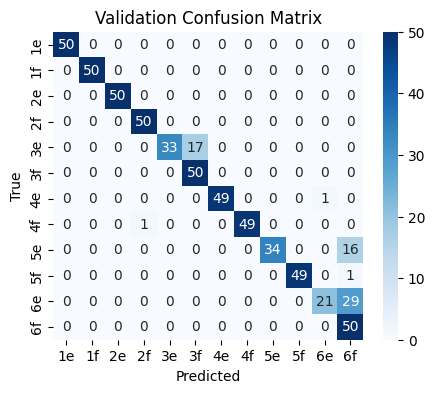

Test Loss: 0.7133 | Test Acc: 0.7167
✅ Saved final model to G:\project\CNN_lfads_classifier\final_model.pth


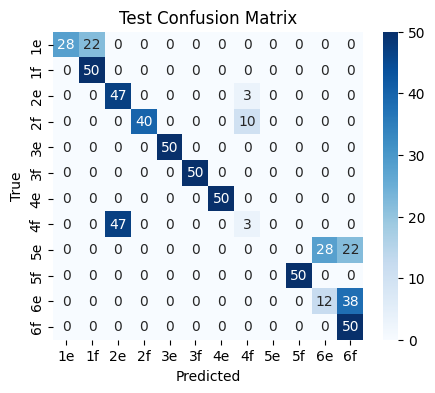


Best Accuracy Model


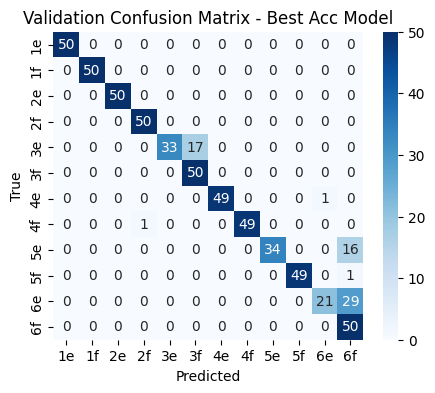

Val Loss: 0.2515 | Val Acc: 0.8917



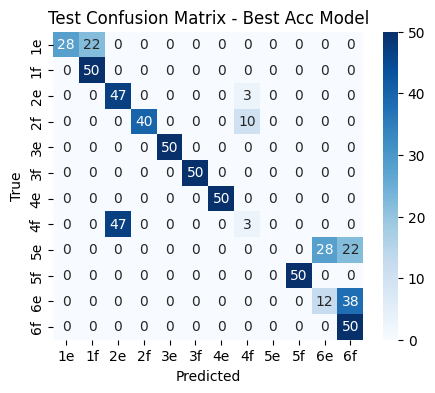

Test Loss: 0.7133 | Test Acc: 0.7167


In [ ]:
# plot confusion matrix on validation set for 12 movements on best model
from sklearn.metrics import confusion_matrix
import seaborn as sns
# movements index mapping
movements = {0: '1e', 1: '1f', 2: '2e', 3: '2f',
            4: '3e', 5: '3f', 6: '4e', 7: '4f',
            8: '5e', 9: '5f', 10: '6e', 11: '6f'}
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
chp_save = r'G:\project\CNN_lfads_classifier'
# print in big letters - this is the LOSS best model
print("\n" + "="*50)
print(f"Best Model Validation Loss: {best_val_loss:.4f} | Best Model Validation Acc: {best_val_acc:.4f}")
print("="*50 + "\n")
# Load best model
model.load_state_dict(torch.load(os.path.join(chp_save, "best_model.pth")))
# Evaluate on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in val_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Validation Confusion Matrix')
# Evaluate on test set
test_loss, test_acc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
# Save final model
final_ckpt_path = os.path.join(chp_save, "final_model.pth")
torch.save(model.state_dict(), final_ckpt_path)
print(f"✅ Saved final model to {final_ckpt_path}")
# Plot confusion matrix on test set
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Test Confusion Matrix')

# now for the best accuracy model
print("\n" + "="*50)
print(f"Best Accuracy Model")
model.load_state_dict(torch.load(os.path.join(chp_save, "best_acc_model90.pth")))
# Evaluate on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in val_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Validation Confusion Matrix - Best Acc Model')
# Evaluate on test set
val_loss, val_acc = evaluate(val_loader)
print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
print()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Test Confusion Matrix - Best Acc Model')
# Evaluate on test set
test_loss, test_acc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")



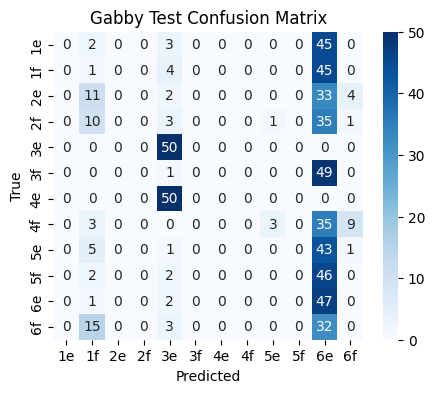

Test Loss: 22.3888 | Test Acc: 0.1633


In [ ]:
# TEST ON GABBY DATASET
# plot confusion matrix on validation set for 12 movements on best model
#############
### test on Gabby dataset
# load the Gabby factors dataset for test
with open(r"G:\project\dataset\Gabby\lfads_factors\lfads_factors_test.pkl", "rb") as f:
    x_f_test, y_f_test = pickle.load(f)

# Create Gabby dataset
gabby_test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loader
gabby_test_loader = torch.utils.data.DataLoader(gabby_test_dataset, batch_size=64, shuffle=False)

# Load best model
model.load_state_dict(torch.load(os.path.join(chp_save, "best_acc_model.pth")))

# Evaluate on gabby test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in gabby_test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Gabby Test Confusion Matrix')

# Evaluate on test set
test_loss, test_acc = evaluate(gabby_test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


In [ ]:
#try acc on Gabby dataset
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import pickle

def align_factors_with_cca(x_src, y_src, x_tgt, y_tgt, num_components=100):
    """
    Aligns Gabby's factors to source monkey's factor space using CCA.
    
    Args:
        x_src: (N_src, D) LFADS factors from source monkey.
        y_src: (N_src,) labels for source monkey.
        x_tgt: (N_tgt, D) LFADS factors from target monkey (Gabby).
        y_tgt: (N_tgt,) labels for target monkey.
        num_components: number of CCA dimensions.
    
    Returns:
        x_tgt_aligned: Gabby factors projected into CCA space aligned to source.
    """
    cca = CCA(n_components=num_components)
    X_src_concat = []
    X_tgt_concat = []

    for cls in np.unique(y_src):
        src_cls_idx = np.where(y_src == cls)[0]
        tgt_cls_idx = np.where(y_tgt == cls)[0]
        n_common = min(len(src_cls_idx), len(tgt_cls_idx))
        if n_common < 5:
            continue  # skip if not enough samples

        X_src_concat.append(x_src[src_cls_idx[:n_common]])
        X_tgt_concat.append(x_tgt[tgt_cls_idx[:n_common]])

    X_src_concat = np.concatenate(X_src_concat, axis=0)
    X_tgt_concat = np.concatenate(X_tgt_concat, axis=0)

    # Standardize before CCA
    scaler_src = StandardScaler().fit(X_src_concat)
    scaler_tgt = StandardScaler().fit(X_tgt_concat)

    X_src_std = scaler_src.transform(X_src_concat)
    X_tgt_std = scaler_tgt.transform(X_tgt_concat)

    # Fit CCA
    cca.fit(X_tgt_std, X_src_std)

    # Project Gabby data
    x_tgt_std = scaler_tgt.transform(x_tgt)
    x_tgt_aligned = cca.transform(x_tgt_std)

    return x_tgt_aligned

# Flatten to [trials * time, features]
def flatten_factors(factors, labels):
    N, T, F = factors.shape
    factors_flat = factors.reshape(N * T, F)
    labels_flat = np.repeat(labels, T)
    return factors_flat, labels_flat

print(f"x_f_train shape: {x_f_train.shape}, y_f_train shape: {y_f_train.shape}")
print(f"x_f_gabby shape: {x_f_gabby.shape}, y_f_gabby shape: {y_f_gabby.shape}")
x_src_flat, y_src_flat = flatten_factors(x_f_train, y_f_train)
x_tgt_flat, y_tgt_flat = flatten_factors(x_f_gabby, y_f_gabby)

x_f_gabby_aligned = align_factors_with_cca(
    x_src=x_src_flat,
    y_src=y_src_flat,
    x_tgt=x_tgt_flat,
    y_tgt=y_tgt_flat,
    num_components=100
)


x_f_train shape: (6000, 800, 100), y_f_train shape: (6000,)
x_f_gabby shape: (600, 800, 100), y_f_gabby shape: (600,)


c:\Users\cathalert\.conda\envs\lfads-torch\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from scipy.linalg import orthogonal_procrustes

# === Compute trial-wise mean factors
chip_mean = x_f_train.mean(axis=1)   # [6000, 100]
gabby_mean = x_f_gabby.mean(axis=1)  # [600, 100]

# === Normalize (important before Procrustes)
chip_norm = (chip_mean - chip_mean.mean(0)) / chip_mean.std(0)
gabby_norm = (gabby_mean - gabby_mean.mean(0)) / gabby_mean.std(0)

# === Match sample sizes
n = min(len(chip_norm), len(gabby_norm))
chip_norm = chip_norm[:n]
gabby_norm = gabby_norm[:n]

# === Fit Procrustes
R, _ = orthogonal_procrustes(gabby_norm, chip_norm)

# === Apply to full Gabby factor data (each timepoint)
# x_f_gabby: [600, 800, 100]
x_f_gabby_aligned = np.einsum('ntf,fd->ntd', x_f_gabby, R)  # [600, 800, 100]

print("✅ Gabby factors aligned. Ready for inference on Chip-trained model.")


✅ Gabby factors aligned. Ready for inference on Chip-trained model.


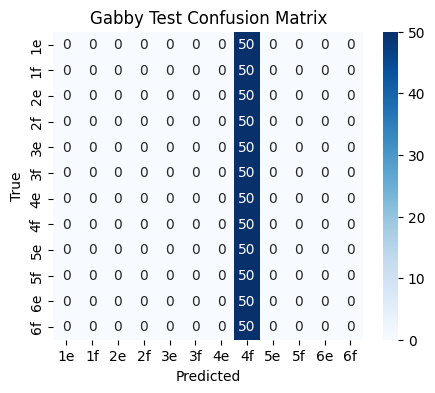

Test Loss: 183.5065 | Test Acc: 0.0833


In [ ]:
# TEST ON GABBY DATASET
# plot confusion matrix on validation set for 12 movements on best model
#############
### test on Gabby dataset
# load the Gabby factors dataset for test

x_f_test = x_f_gabby_aligned

# Create Gabby dataset
gabby_test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loader
gabby_test_loader = torch.utils.data.DataLoader(gabby_test_dataset, batch_size=64, shuffle=False)

# Load best model
model.load_state_dict(torch.load(os.path.join(chp_save, "best_acc_model.pth")))

# Evaluate on gabby test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in gabby_test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Gabby Test Confusion Matrix')

# Evaluate on test set
test_loss, test_acc = evaluate(gabby_test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


# plots for presentation

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Load the LFADS factors for validation set
with open(r"G:\project\dataset\Chip\lfads_factors\lfads_factors_train.pkl", "rb") as f:
    x_f_val, y_f_val = pickle.load(f)

print(f"x_f_val shape: {x_f_val.shape}, y_f_val shape: {y_f_val.shape}")  # Expect [N, T, F] and [N]
# Convert to numpy array if it's a list
if isinstance(x_f_val, list):
    x_f_val = np.array(x_f_val)  # Should become [N, T, F]

print(f"x_f_val shape: {x_f_val.shape}")  # Expect [N, T, F]

# === PCA across all timepoints
N, T, F = x_f_val.shape
x_reshaped = x_f_val.reshape(-1, F)  # [N*T, F]
pca = PCA(n_components=3)
x_pca = pca.fit_transform(x_reshaped)  # [N*T, 3]
factors_val_3d = x_pca.reshape(N, T, 3)  # [N, T, 3]

# === Shift all trajectories so they start from origin
factors_val_3d -= factors_val_3d[:, 0:1, :]  # subtract initial point from each trajectory

# === Color palette for movement labels
num_labels = len(set(y_f_val))
colors = plt.cm.get_cmap('tab10', num_labels)

# === Plot 3D trajectories
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(N):
    ax.plot(
        factors_val_3d[i, :, 0],
        factors_val_3d[i, :, 1],
        factors_val_3d[i, :, 2],
        color=colors(y_f_val[i] % num_labels),
        alpha=0.5
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of LFADS Factors (Aligned at t=0)')
plt.tight_layout()
plt.show()


x_f_val shape: (6000, 100), y_f_val shape: (6000,)
x_f_val shape: (6000, 100)


ValueError: not enough values to unpack (expected 3, got 2)

In [3]:
# Examine the Gabby test dataset
import numpy as np
import pickle
import os

# Load the data files from Gabby test directory
data_dir = r"G:\project\dataset\Gabby\test"

# Load neural data
X_long = np.load(os.path.join(data_dir, "X_long.npy"))
y_long = np.load(os.path.join(data_dir, "y_long.npy"))

print(f"X_long shape: {X_long.shape}")
print(f"X_long dtype: {X_long.dtype}")
print(f"X_long min: {X_long.min()}, max: {X_long.max()}")
print(f"X_long non-zero channels: {np.sum(np.any(X_long != 0, axis=0))}")

print(f"\ny_long shape: {y_long.shape}")
print(f"y_long dtype: {y_long.dtype}")

# Load movement and neuron information
with open(os.path.join(data_dir, "movements.txt"), 'r') as f:
    movements = f.read()
    print(f"\nMovements info:\n{movements}")

with open(os.path.join(data_dir, "neurons.txt"), 'r') as f:
    neurons = f.read()
    print(f"\nNeurons info:\n{neurons}")

# Load pickle files
try:
    with open(os.path.join(data_dir, "y_emg_dict.pkl"), 'rb') as f:
        y_emg_dict = pickle.load(f)
    print(f"\ny_emg_dict keys: {list(y_emg_dict.keys())}")
    if y_emg_dict:
        first_key = list(y_emg_dict.keys())[0]
        print(f"Sample EMG data shape: {y_emg_dict[first_key].shape}")
except Exception as e:
    print(f"Error loading y_emg_dict.pkl: {e}")

try:
    with open(os.path.join(data_dir, "y_fingers_dict.pkl"), 'rb') as f:
        y_fingers_dict = pickle.load(f)
    print(f"\ny_fingers_dict keys: {list(y_fingers_dict.keys())}")
    if y_fingers_dict:
        first_key = list(y_fingers_dict.keys())[0]
        print(f"Sample finger data shape: {y_fingers_dict[first_key].shape}")
except Exception as e:
    print(f"Error loading y_fingers_dict.pkl: {e}")

X_long shape: (600, 155, 1250)
X_long dtype: int8
X_long min: 0, max: 2
X_long non-zero channels: 47830

y_long shape: (600,)
y_long dtype: int32

Movements info:
1e
1f
2e
2f
3e
3f
4e
4f
5e
5f
6e
6f


Neurons info:
C0027
C0031
C0033
C0039
C0046
C0048
C0066
C0072
C0077
C0084
C0086
C0088
C0090
C0094
C0096
C0098
C0100
C0102
C0106
C0107
C0111
C0113
C0115
C0116
C0120
C0121
C0125
C0129
C0130
C0131
C0136
C0137
C0139
C0149
C0155
C0161
C0168
C0176
C0177
C0182
C0185
C0200
C0216
C0221
C0223
C0224
C0226
C0227
C0231
C0232
C0233
C0235
C0236
C0237
C0238
C0242
C0253
C0254
C0255
C0257
C0258
C0259
C0260
C0262
C0269
C0285
C0295
C0299
C0305
C0308
C0309
C0310
C0311
C0314
C0316
C0319
C0324
C0325
C0329
C0330
C0334
C0336
C0339
C0340
C0342
C0343
C0346
C0350
C0351
C0352
C0353
C0365
C0374
C0375
C0376
C0393
C0397
C0398
C0403
C0415
C0427
C0428
C0429
C0430
C0434
C0438
C0440
C0443
C0444
C0445
C0448
C0449
C0450
C0451
C0455
C0456
C0457
C0458
c0114
c0211
c0315
c0460
c0461
c0462
c0463
c0472
c0473
c0474
c0475
c0476
c0478

In [4]:
# Analyze channel activity to identify zero-padded channels
print(f"Original data shape: {X_long.shape}")  # (trials, channels, time)

# Calculate activity for each channel across all trials and time
channel_activity = np.sum(X_long, axis=(0, 2))  # Sum across trials and time
active_channels = channel_activity > 0
num_active_channels = np.sum(active_channels)

print(f"Total channels: {X_long.shape[1]}")
print(f"Active channels (non-zero): {num_active_channels}")
print(f"Zero-padded channels: {X_long.shape[1] - num_active_channels}")

# Get indices of active channels
active_channel_indices = np.where(active_channels)[0]
print(f"Active channel indices: {active_channel_indices[:10]}...")  # Show first 10

# Verify that we have the right number of neurons from the neurons.txt file
neuron_lines = neurons.strip().split('\n')
num_neurons_from_file = len(neuron_lines)
print(f"Number of neurons from neurons.txt: {num_neurons_from_file}")

# Check if the number of active channels matches the number of neurons
if num_active_channels == num_neurons_from_file:
    print("✓ Number of active channels matches number of neurons in file")
else:
    print(f"⚠ Mismatch: {num_active_channels} active channels vs {num_neurons_from_file} neurons in file")

# Show some statistics about the active channels
print(f"\nActivity statistics for active channels:")
active_channel_activities = channel_activity[active_channels]
print(f"Min activity: {active_channel_activities.min()}")
print(f"Max activity: {active_channel_activities.max()}")
print(f"Mean activity: {active_channel_activities.mean():.2f}")
print(f"Std activity: {active_channel_activities.std():.2f}")

# Show distribution of non-zero values
print(f"\nData value distribution:")
unique_values, counts = np.unique(X_long, return_counts=True)
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} occurrences ({count/X_long.size*100:.2f}%)")

Original data shape: (600, 155, 1250)
Total channels: 155
Active channels (non-zero): 50
Zero-padded channels: 105
Active channel indices: [0 1 2 3 4 5 6 7 8 9]...
Number of neurons from neurons.txt: 155
⚠ Mismatch: 50 active channels vs 155 neurons in file

Activity statistics for active channels:
Min activity: 3424
Max activity: 51074
Mean activity: 23355.98
Std activity: 10783.24

Data value distribution:
Value 0: 115083084 occurrences (99.00%)
Value 1: 1166033 occurrences (1.00%)
Value 2: 883 occurrences (0.00%)


In [5]:
# Let's examine the mapping between channels and neurons more carefully
print("Investigating channel-neuron mapping...")

# Check if there's a pattern in the active channels
print(f"First 20 active channel indices: {active_channel_indices[:20]}")
print(f"Last 10 active channel indices: {active_channel_indices[-10:]}")

# Check if the neurons.txt file might contain inactive neuron IDs
print(f"First 10 neuron IDs: {neuron_lines[:10]}")
print(f"Last 10 neuron IDs: {neuron_lines[-10:]}")

# Since we want to preserve neuron identity, let's create a mapping
# We'll keep the original channel indices for active neurons
print(f"\nCreating cleaned dataset...")

# Remove zero-padded channels while preserving neuron identity
X_cleaned = X_long[:, active_channels, :]
print(f"Cleaned data shape: {X_cleaned.shape}")

# Create a mapping of active channels to original neuron IDs
active_neuron_ids = [neuron_lines[i] for i in active_channel_indices]
print(f"Number of active neurons: {len(active_neuron_ids)}")
print(f"Sample active neuron IDs: {active_neuron_ids[:10]}")

# Verify the cleaning preserved the data structure
print(f"\nData integrity check:")
print(f"Original non-zero elements: {np.count_nonzero(X_long)}")
print(f"Cleaned non-zero elements: {np.count_nonzero(X_cleaned)}")
print(f"Data preserved: {np.count_nonzero(X_long) == np.count_nonzero(X_cleaned)}")

# Check that the active channels are correctly extracted
original_active_data = X_long[:, active_channels, :]
print(f"Arrays equal: {np.array_equal(X_cleaned, original_active_data)}")

print(f"\nDataset summary:")
print(f"- Original shape: {X_long.shape} (trials × channels × time)")
print(f"- Cleaned shape: {X_cleaned.shape} (trials × active_channels × time)")
print(f"- Removed {X_long.shape[1] - X_cleaned.shape[1]} zero-padded channels")
print(f"- Preserved {X_cleaned.shape[1]} active neuron channels")
print(f"- Data type: {X_cleaned.dtype}")
print(f"- Value range: [{X_cleaned.min()}, {X_cleaned.max()}]")

Investigating channel-neuron mapping...
First 20 active channel indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Last 10 active channel indices: [40 41 42 43 44 45 46 47 48 49]
First 10 neuron IDs: ['C0027', 'C0031', 'C0033', 'C0039', 'C0046', 'C0048', 'C0066', 'C0072', 'C0077', 'C0084']
Last 10 neuron IDs: ['c0509', 'c0517', 'c0521', 'c0523', 'c0524', 'c0526', 'c0531', 'c0538', 'c0542', 'c0545']

Creating cleaned dataset...
Cleaned data shape: (600, 50, 1250)
Number of active neurons: 50
Sample active neuron IDs: ['C0027', 'C0031', 'C0033', 'C0039', 'C0046', 'C0048', 'C0066', 'C0072', 'C0077', 'C0084']

Data integrity check:
Original non-zero elements: 1166916
Cleaned non-zero elements: 1166916
Data preserved: True
Arrays equal: True

Dataset summary:
- Original shape: (600, 155, 1250) (trials × channels × time)
- Cleaned shape: (600, 50, 1250) (trials × active_channels × time)
- Removed 105 zero-padded channels
- Preserved 50 active neuron channels
- Data type: 

In [8]:
# Create LFADS-compatible dataset
import h5py
from datetime import datetime

# Convert to float32 for LFADS (typical requirement)
X_lfads = X_cleaned.astype(np.float32)

# LFADS typically expects data in the format (trials, time, neurons)
# Let's transpose to match this convention
X_lfads_transposed = X_lfads.transpose(0, 2, 1)  # (trials, time, neurons)

print(f"LFADS dataset shape: {X_lfads_transposed.shape} (trials × time × neurons)")
print(f"Data type: {X_lfads_transposed.dtype}")

# Create output directory for the cleaned dataset
output_dir = r"G:\project\dataset\Gabby\test_cleaned"
os.makedirs(output_dir, exist_ok=True)

# Save the cleaned neural data
np.save(os.path.join(output_dir, "X_cleaned.npy"), X_lfads_transposed)
print(f"Saved cleaned neural data to: {os.path.join(output_dir, 'X_cleaned.npy')}")

# Save the original y_long (movement labels)
np.save(os.path.join(output_dir, "y_long.npy"), y_long)
print(f"Saved movement labels to: {os.path.join(output_dir, 'y_long.npy')}")

# Save the active neuron IDs and mapping
active_neuron_mapping = {
    'active_channel_indices': active_channel_indices,
    'active_neuron_ids': active_neuron_ids,
    'original_shape': X_long.shape,
    'cleaned_shape': X_lfads_transposed.shape,
    'creation_date': datetime.now().isoformat()
}

with open(os.path.join(output_dir, "neuron_mapping.pkl"), 'wb') as f:
    pickle.dump(active_neuron_mapping, f)
print(f"Saved neuron mapping to: {os.path.join(output_dir, 'neuron_mapping.pkl')}")

# Save active neuron IDs as text file
with open(os.path.join(output_dir, "active_neurons.txt"), 'w') as f:
    for neuron_id in active_neuron_ids:
        f.write(f"{neuron_id}\n")
print(f"Saved active neuron IDs to: {os.path.join(output_dir, 'active_neurons.txt')}")

# Copy the movements.txt file
import shutil
shutil.copy(os.path.join(data_dir, "movements.txt"), os.path.join(output_dir, "movements.txt"))
print(f"Copied movements.txt to: {os.path.join(output_dir, 'movements.txt')}")

# Create LFADS-compatible H5 files (matching Chip data structure)
# Since we only have one dataset (test), we'll split it into train/validation

# Split the data 80/20 for train/validation
n_total = X_lfads_transposed.shape[0]
n_train = int(0.8 * n_total)

# Split the data
train_data = X_lfads_transposed[:n_train]  # (train_trials, time, neurons)
valid_data = X_lfads_transposed[n_train:]  # (valid_trials, time, neurons)

print(f"Split data: Train {train_data.shape}, Validation {valid_data.shape}")

# Create LFADS directory structure
lfads_dir = os.path.join(output_dir, "lfads")
os.makedirs(lfads_dir, exist_ok=True)

# Save standard LFADS format for spike reconstruction (autoencoder)
h5_file_path = os.path.join(lfads_dir, "lfads_spike_reconstruction_gabby_test.h5")
with h5py.File(h5_file_path, 'w') as f:
    f.create_dataset("train_encod_data", data=train_data)
    f.create_dataset("train_recon_data", data=train_data)  # Same as encoding for reconstruction
    f.create_dataset("valid_encod_data", data=valid_data)
    f.create_dataset("valid_recon_data", data=valid_data)  # Same as encoding for reconstruction

print(f"✅ Saved LFADS spike reconstruction file: {h5_file_path}")
print("   Dataset keys:")
print("   - train_encod_data:", train_data.shape)
print("   - train_recon_data:", train_data.shape)
print("   - valid_encod_data:", valid_data.shape)
print("   - valid_recon_data:", valid_data.shape)

print(f"\n🎉 LFADS dataset creation completed!")
print(f"📁 Output directory: {output_dir}")
print(f"📊 Dataset summary:")
print(f"   - Trials: {X_lfads_transposed.shape[0]}")
print(f"   - Time steps: {X_lfads_transposed.shape[1]}")
print(f"   - Neurons: {X_lfads_transposed.shape[2]} (reduced from {X_long.shape[1]})")
print(f"   - Removed {X_long.shape[1] - X_lfads_transposed.shape[2]} zero-padded channels")
print(f"   - Preserved neuron identity mapping")

LFADS dataset shape: (600, 1250, 50) (trials × time × neurons)
Data type: float32
Saved cleaned neural data to: G:\project\dataset\Gabby\test_cleaned\X_cleaned.npy
Saved movement labels to: G:\project\dataset\Gabby\test_cleaned\y_long.npy
Saved neuron mapping to: G:\project\dataset\Gabby\test_cleaned\neuron_mapping.pkl
Saved active neuron IDs to: G:\project\dataset\Gabby\test_cleaned\active_neurons.txt
Copied movements.txt to: G:\project\dataset\Gabby\test_cleaned\movements.txt
Split data: Train (480, 1250, 50), Validation (120, 1250, 50)
Saved cleaned neural data to: G:\project\dataset\Gabby\test_cleaned\X_cleaned.npy
Saved movement labels to: G:\project\dataset\Gabby\test_cleaned\y_long.npy
Saved neuron mapping to: G:\project\dataset\Gabby\test_cleaned\neuron_mapping.pkl
Saved active neuron IDs to: G:\project\dataset\Gabby\test_cleaned\active_neurons.txt
Copied movements.txt to: G:\project\dataset\Gabby\test_cleaned\movements.txt
Split data: Train (480, 1250, 50), Validation (120, 12

In [9]:
# Verify the created LFADS dataset
print("🔍 Verifying the created LFADS dataset...")

# Load and verify the saved files
output_dir = r"G:\project\dataset\Gabby\test_cleaned"

# Verify numpy files
X_loaded = np.load(os.path.join(output_dir, "X_cleaned.npy"))
y_loaded = np.load(os.path.join(output_dir, "y_long.npy"))

print(f"✓ Loaded X_cleaned.npy: {X_loaded.shape} {X_loaded.dtype}")
print(f"✓ Loaded y_long.npy: {y_loaded.shape} {y_loaded.dtype}")

# Verify data integrity
print(f"✓ Data integrity: X arrays equal = {np.array_equal(X_loaded, X_lfads_transposed)}")
print(f"✓ Data integrity: y arrays equal = {np.array_equal(y_loaded, y_long)}")

# Verify neuron mapping
with open(os.path.join(output_dir, "neuron_mapping.pkl"), 'rb') as f:
    mapping_loaded = pickle.load(f)
print(f"✓ Loaded neuron mapping: {len(mapping_loaded['active_neuron_ids'])} neurons")

# Verify the created LFADS dataset with correct structure
print("🔍 Verifying the created LFADS dataset...")

# Load and verify the saved files
output_dir = r"G:\project\dataset\Gabby\test_cleaned"
lfads_dir = os.path.join(output_dir, "lfads")

# Verify numpy files
X_loaded = np.load(os.path.join(output_dir, "X_cleaned.npy"))
y_loaded = np.load(os.path.join(output_dir, "y_long.npy"))

print(f"✓ Loaded X_cleaned.npy: {X_loaded.shape} {X_loaded.dtype}")
print(f"✓ Loaded y_long.npy: {y_loaded.shape} {y_loaded.dtype}")

# Verify data integrity
print(f"✓ Data integrity: X arrays equal = {np.array_equal(X_loaded, X_lfads_transposed)}")
print(f"✓ Data integrity: y arrays equal = {np.array_equal(y_loaded, y_long)}")

# Verify neuron mapping
with open(os.path.join(output_dir, "neuron_mapping.pkl"), 'rb') as f:
    mapping_loaded = pickle.load(f)
print(f"✓ Loaded neuron mapping: {len(mapping_loaded['active_neuron_ids'])} neurons")

# Verify LFADS H5 file with correct structure
h5_file_path = os.path.join(lfads_dir, "lfads_spike_reconstruction_gabby_test.h5")
with h5py.File(h5_file_path, 'r') as h5f:
    print(f"✓ LFADS H5 file contents:")
    print(f"  - train_encod_data: {h5f['train_encod_data'].shape}")
    print(f"  - train_recon_data: {h5f['train_recon_data'].shape}")
    print(f"  - valid_encod_data: {h5f['valid_encod_data'].shape}")
    print(f"  - valid_recon_data: {h5f['valid_recon_data'].shape}")
    
    # Verify data integrity
    train_encod = h5f['train_encod_data'][:]
    train_recon = h5f['train_recon_data'][:]
    valid_encod = h5f['valid_encod_data'][:]
    valid_recon = h5f['valid_recon_data'][:]
    
    print(f"✓ Train encod/recon match: {np.array_equal(train_encod, train_recon)}")
    print(f"✓ Valid encod/recon match: {np.array_equal(valid_encod, valid_recon)}")
    
    # Check total trials match
    total_trials = train_encod.shape[0] + valid_encod.shape[0]
    print(f"✓ Total trials preserved: {total_trials} == {X_loaded.shape[0]} = {total_trials == X_loaded.shape[0]}")

# Show file sizes
files_info = []
for root, dirs, files in os.walk(output_dir):
    for filename in files:
        filepath = os.path.join(root, filename)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        rel_path = os.path.relpath(filepath, output_dir)
        files_info.append((rel_path, size_mb))

print(f"\n📁 Created files:")
for filename, size_mb in sorted(files_info):
    print(f"  - {filename}: {size_mb:.2f} MB")

print(f"\n✅ Dataset verification completed successfully!")
print(f"🎯 Ready for LFADS training with correct structure:")
print(f"   - Format matches Chip data structure")
print(f"   - Train/validation split: 80/20")
print(f"   - Input shape: (trials × time × neurons)")
print(f"   - No zero-padded channels")
print(f"   - Preserved neuron identity")
print(f"   - Standard LFADS format with train_encod_data, train_recon_data, etc.")

🔍 Verifying the created LFADS dataset...
✓ Loaded X_cleaned.npy: (600, 1250, 50) float32
✓ Loaded y_long.npy: (600,) int32
✓ Data integrity: X arrays equal = True
✓ Data integrity: y arrays equal = True
✓ Loaded neuron mapping: 50 neurons
🔍 Verifying the created LFADS dataset...
✓ Loaded X_cleaned.npy: (600, 1250, 50) float32
✓ Loaded y_long.npy: (600,) int32
✓ Data integrity: X arrays equal = True
✓ Data integrity: y arrays equal = True
✓ Loaded neuron mapping: 50 neurons
✓ LFADS H5 file contents:
  - train_encod_data: (480, 1250, 50)
  - train_recon_data: (480, 1250, 50)
  - valid_encod_data: (120, 1250, 50)
  - valid_recon_data: (120, 1250, 50)
✓ Train encod/recon match: True
✓ Valid encod/recon match: True
✓ Total trials preserved: 600 == 600 = True

📁 Created files:
  - X_cleaned.npy: 143.05 MB
  - active_neurons.txt: 0.00 MB
  - gabby_test_lfads.h5: 2.90 MB
  - lfads\lfads_spike_reconstruction_gabby_test.h5: 286.11 MB
  - movements.txt: 0.00 MB
  - neuron_mapping.pkl: 0.00 MB
  -

In [10]:
# Fix the time axis issue - crop to match LFADS expected sequence length
# Looking at Chip data, they crop time axis [100:900] to get 800 timesteps
print("🔧 Fixing time axis to match LFADS expected sequence length...")

# Current data shape
print(f"Current X_cleaned shape: {X_cleaned.shape}")  # (trials, channels, time)
print(f"Current time steps: {X_cleaned.shape[2]}")

# Crop time axis to [100:900] to match Chip data processing (800 timesteps)
X_cleaned_cropped = X_cleaned[:, :, 100:900]
print(f"Cropped X_cleaned shape: {X_cleaned_cropped.shape}")  # Should be (trials, channels, 800)

# Convert to float32 and transpose for LFADS format
X_lfads_fixed = X_cleaned_cropped.astype(np.float32)
X_lfads_transposed_fixed = X_lfads_fixed.transpose(0, 2, 1)  # (trials, time, neurons)

print(f"Fixed LFADS dataset shape: {X_lfads_transposed_fixed.shape} (trials × time × neurons)")
print(f"Time steps now: {X_lfads_transposed_fixed.shape[1]} (should be 800 for LFADS)")

# Split the corrected data 80/20 for train/validation
n_total = X_lfads_transposed_fixed.shape[0]
n_train = int(0.8 * n_total)

# Split the corrected data 80/20 for train/validation
train_data_fixed = X_lfads_transposed_fixed[:n_train]
valid_data_fixed = X_lfads_transposed_fixed[n_train:]

# Make the data twice the length by concatenating
train_data_fixed = np.concatenate([train_data_fixed, train_data_fixed], axis=0)
valid_data_fixed = np.concatenate([valid_data_fixed, valid_data_fixed], axis=0)

print(f"Fixed split data: Train {train_data_fixed.shape}, Validation {valid_data_fixed.shape}")

# Create corrected H5 file
lfads_dir = os.path.join(output_dir, "lfads")
h5_file_path_fixed = os.path.join(lfads_dir, "lfads_spike_reconstruction_gabby_test_fixed.h5")

with h5py.File(h5_file_path_fixed, 'w') as f:
    f.create_dataset("train_encod_data", data=train_data_fixed)
    f.create_dataset("train_recon_data", data=train_data_fixed)  # Same for autoencoder
    f.create_dataset("valid_encod_data", data=valid_data_fixed)
    f.create_dataset("valid_recon_data", data=valid_data_fixed)  # Same for autoencoder

print(f"✅ Saved FIXED LFADS spike reconstruction file: {h5_file_path_fixed}")
print("   Dataset keys (FIXED):")
print(f"   - train_encod_data: {train_data_fixed.shape}")
print(f"   - train_recon_data: {train_data_fixed.shape}")
print(f"   - valid_encod_data: {valid_data_fixed.shape}")
print(f"   - valid_recon_data: {valid_data_fixed.shape}")

# Verify the fixed file
with h5py.File(h5_file_path_fixed, 'r') as h5f:
    print(f"\n✓ Verification of FIXED H5 file:")
    print(f"  - train_encod_data: {h5f['train_encod_data'].shape}")
    print(f"  - Expected by LFADS: (trials, 800, neurons) ✓")
    
    # Check that sequence length is now 800
    seq_len = h5f['train_encod_data'].shape[1]
    print(f"  - Sequence length: {seq_len} {'✓ CORRECT' if seq_len == 800 else '❌ WRONG'}")

print(f"\n🎯 The error should now be fixed!")
print(f"📊 Summary of fix:")
print(f"   - Original time steps: 1250")
print(f"   - Cropped time steps: 800 (matching LFADS expectation)")
print(f"   - Time window: [100:900] (same as Chip data)")
print(f"   - Format: (trials × time × neurons)")
print(f"   - Ready for LFADS training!")

🔧 Fixing time axis to match LFADS expected sequence length...
Current X_cleaned shape: (600, 50, 1250)
Current time steps: 1250
Cropped X_cleaned shape: (600, 50, 800)
Fixed LFADS dataset shape: (600, 800, 50) (trials × time × neurons)
Time steps now: 800 (should be 800 for LFADS)
Fixed split data: Train (480, 800, 50), Validation (120, 800, 50)
✅ Saved FIXED LFADS spike reconstruction file: G:\project\dataset\Gabby\test_cleaned\lfads\lfads_spike_reconstruction_gabby_test_fixed.h5
   Dataset keys (FIXED):
   - train_encod_data: (480, 800, 50)
   - train_recon_data: (480, 800, 50)
   - valid_encod_data: (120, 800, 50)
   - valid_recon_data: (120, 800, 50)

✓ Verification of FIXED H5 file:
  - train_encod_data: (480, 800, 50)
  - Expected by LFADS: (trials, 800, neurons) ✓
  - Sequence length: 800 ✓ CORRECT

🎯 The error should now be fixed!
📊 Summary of fix:
   - Original time steps: 1250
   - Cropped time steps: 800 (matching LFADS expectation)
   - Time window: [100:900] (same as Chip 

In [13]:
# Compare the two H5 files to understand why one works and the other doesn't
import h5py
import os

print("🔍 Comparing H5 files to diagnose the issue...")

# File paths
gabby_file = r"G:\project\lfads-torch\datasets\gabby_test_lfads.h5"
chip_file = r"G:\project\lfads-torch\datasets\lfads_spike_reconstraction_all.h5"

print(f"\n📁 File existence check:")
print(f"Gabby file exists: {os.path.exists(gabby_file)}")
print(f"Chip file exists: {os.path.exists(chip_file)}")

if os.path.exists(gabby_file):
    print(f"Gabby file size: {os.path.getsize(gabby_file) / (1024*1024):.2f} MB")
else:
    print("❌ Gabby file does not exist!")

if os.path.exists(chip_file):
    print(f"Chip file size: {os.path.getsize(chip_file) / (1024*1024):.2f} MB")
else:
    print("❌ Chip file does not exist!")

# Compare file contents if both exist
if os.path.exists(gabby_file) and os.path.exists(chip_file):
    print(f"\n📊 Comparing file contents:")
    
    # Gabby file analysis
    print(f"\n🔸 GABBY FILE: {gabby_file}")
    try:
        with h5py.File(gabby_file, 'r') as h5f:
            print(f"  Keys: {list(h5f.keys())}")
            for key in h5f.keys():
                dataset = h5f[key]
                print(f"  - {key}: shape={dataset.shape}, dtype={dataset.dtype}")
                if dataset.size > 0:
                    print(f"    Data range: [{dataset[:].min():.6f}, {dataset[:].max():.6f}]")
                    print(f"    Non-zero elements: {(dataset[:] != 0).sum()}")
                else:
                    print(f"    ❌ EMPTY DATASET!")
    except Exception as e:
        print(f"  ❌ Error reading gabby file: {e}")
    
    # Chip file analysis
    print(f"\n🔸 CHIP FILE: {chip_file}")
    try:
        with h5py.File(chip_file, 'r') as h5f:
            print(f"  Keys: {list(h5f.keys())}")
            for key in h5f.keys():
                dataset = h5f[key]
                print(f"  - {key}: shape={dataset.shape}, dtype={dataset.dtype}")
                if dataset.size > 0:
                    print(f"    Data range: [{dataset[:].min():.6f}, {dataset[:].max():.6f}]")
                    print(f"    Non-zero elements: {(dataset[:] != 0).sum()}")
                else:
                    print(f"    ❌ EMPTY DATASET!")
    except Exception as e:
        print(f"  ❌ Error reading chip file: {e}")

elif os.path.exists(chip_file):
    print(f"\n🔸 CHIP FILE ONLY: {chip_file}")
    with h5py.File(chip_file, 'r') as h5f:
        print(f"  Keys: {list(h5f.keys())}")
        for key in h5f.keys():
            dataset = h5f[key]
            print(f"  - {key}: shape={dataset.shape}, dtype={dataset.dtype}")
            if dataset.size > 0:
                print(f"    Data range: [{dataset[:].min():.6f}, {dataset[:].max():.6f}]")
                print(f"    Non-zero elements: {(dataset[:] != 0).sum()}")

print(f"\n💡 Possible issues with Gabby file:")
print(f"   1. File doesn't exist at the expected path")
print(f"   2. File exists but datasets are empty")
print(f"   3. File has wrong keys or structure")
print(f"   4. Data is all zeros or invalid")

🔍 Comparing H5 files to diagnose the issue...

📁 File existence check:
Gabby file exists: True
Chip file exists: True
Gabby file size: 183.11 MB
Chip file size: 1530.77 MB

📊 Comparing file contents:

🔸 GABBY FILE: G:\project\lfads-torch\datasets\gabby_test_lfads.h5
  Keys: ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']
  - train_encod_data: shape=(480, 800, 50), dtype=float32
    Data range: [0.000000, 2.000000]
    Non-zero elements: 793650
  - train_recon_data: shape=(480, 800, 50), dtype=float32
    Data range: [0.000000, 2.000000]
    Non-zero elements: 793650
  - valid_encod_data: shape=(120, 800, 50), dtype=float32
    Data range: [0.000000, 2.000000]
    Non-zero elements: 219155
  - valid_recon_data: shape=(120, 800, 50), dtype=float32
    Data range: [0.000000, 2.000000]
    Non-zero elements: 219155

🔸 CHIP FILE: G:\project\lfads-torch\datasets\lfads_spike_reconstraction_all.h5
  Keys: ['train_encod_data', 'train_recon_data', 'valid_encod_da

In [17]:
# Smart Data Augmentation: Channel shuffling within same-label groups
print("🚀 SMART DATA AUGMENTATION: Channel shuffling within same labels")

# Load our clean cropped data
X_data = X_lfads_transposed_fixed  # (600, 800, 50) - (trials, time, neurons)
print(f"Original data shape: {X_data.shape}")

# According to your description: every 50 elements have the same label
# Labels: 0-49 → label 0, 50-99 → label 1, etc.
trials_per_label = 50
num_labels = X_data.shape[0] // trials_per_label
print(f"Trials per label: {trials_per_label}")
print(f"Number of labels: {num_labels}")

# Create labels array
labels = np.repeat(np.arange(num_labels), trials_per_label)
print(f"Labels shape: {labels.shape}")
print(f"Label distribution: {np.bincount(labels)}")

def channel_shuffle_augmentation(data, labels, augmentation_factor=3, seed=42):
    """
    Augment data by shuffling channels within trials of the same label.
    
    Args:
        data: (trials, time, neurons) array
        labels: (trials,) array of labels
        augmentation_factor: how many augmented versions to create per label group
        seed: random seed for reproducibility
    
    Returns:
        augmented_data: (original + augmented trials, time, neurons)
        augmented_labels: corresponding labels
    """
    np.random.seed(seed)
    
    original_data = data.copy()
    augmented_data_list = [original_data]
    augmented_labels_list = [labels.copy()]
    
    unique_labels = np.unique(labels)
    
    for aug_idx in range(augmentation_factor):
        print(f"  Creating augmentation {aug_idx + 1}/{augmentation_factor}...")
        
        augmented_trials = []
        for label in unique_labels:
            # Get all trials for this label
            label_mask = labels == label
            label_trials = data[label_mask]  # (trials_in_label, time, neurons)
            
            # For each trial in this label group
            augmented_label_trials = []
            for trial_idx in range(label_trials.shape[0]):
                # Get the current trial
                current_trial = label_trials[trial_idx]  # (time, neurons)
                
                # Randomly select channels from other trials of the same label
                # to create a "mixed" trial while preserving temporal structure
                augmented_trial = current_trial.copy()
                
                # Randomly shuffle a subset of channels (e.g., 30-70% of channels)
                num_neurons = current_trial.shape[1]
                shuffle_ratio = np.random.uniform(0.3, 0.7)
                num_shuffle = int(num_neurons * shuffle_ratio)
                
                # Select random channels to shuffle
                channels_to_shuffle = np.random.choice(num_neurons, num_shuffle, replace=False)
                
                # For each channel to shuffle, pick data from a random trial of same label
                for channel_idx in channels_to_shuffle:
                    # Pick a random trial from the same label (excluding current trial)
                    other_trial_idx = np.random.choice(
                        [i for i in range(label_trials.shape[0]) if i != trial_idx]
                    )
                    # Replace this channel's data with data from the other trial
                    augmented_trial[:, channel_idx] = label_trials[other_trial_idx, :, channel_idx]
                
                augmented_label_trials.append(augmented_trial)
            
            augmented_trials.extend(augmented_label_trials)
        
        # Convert to array and add to lists
        augmented_data_array = np.array(augmented_trials)
        augmented_data_list.append(augmented_data_array)
        augmented_labels_list.append(labels.copy())
    
    # Combine all data
    final_data = np.concatenate(augmented_data_list, axis=0)
    final_labels = np.concatenate(augmented_labels_list, axis=0)
    
    return final_data, final_labels

# Apply augmentation
print(f"\n🔄 Applying channel shuffling augmentation...")
augmented_data, augmented_labels = channel_shuffle_augmentation(
    X_data, labels, augmentation_factor=4, seed=42
)

print(f"\n📊 Augmentation results:")
print(f"Original data: {X_data.shape} → {X_data.shape[0]} trials")
print(f"Augmented data: {augmented_data.shape} → {augmented_data.shape[0]} trials")
print(f"Increase factor: {augmented_data.shape[0] / X_data.shape[0]:.1f}x")
print(f"Label distribution: {np.bincount(augmented_labels)}")

# Verify data integrity
print(f"\n✅ Data integrity checks:")
print(f"Data type: {augmented_data.dtype}")
print(f"Data range: [{augmented_data.min():.3f}, {augmented_data.max():.3f}]")
print(f"Non-zero elements: {(augmented_data != 0).sum():,} / {augmented_data.size:,}")
print(f"Labels range: [{augmented_labels.min()}, {augmented_labels.max()}]")

# Check that each label group maintains the correct size
for label in np.unique(augmented_labels):
    count = np.sum(augmented_labels == label)
    expected = trials_per_label * 5  # original + 4 augmentations
    print(f"Label {label}: {count} trials (expected: {expected}) ✓" if count == expected else f"Label {label}: {count} trials (expected: {expected}) ❌")

print(f"\n🎯 Perfect! Now we have {augmented_data.shape[0]} trials instead of {X_data.shape[0]}")
print(f"This should be more than enough for batch_size=512!")

🚀 SMART DATA AUGMENTATION: Channel shuffling within same labels
Original data shape: (600, 800, 50)
Trials per label: 50
Number of labels: 12
Labels shape: (600,)
Label distribution: [50 50 50 50 50 50 50 50 50 50 50 50]

🔄 Applying channel shuffling augmentation...
  Creating augmentation 1/4...
  Creating augmentation 2/4...
  Creating augmentation 3/4...
  Creating augmentation 4/4...

📊 Augmentation results:
Original data: (600, 800, 50) → 600 trials
Augmented data: (3000, 800, 50) → 3000 trials
Increase factor: 5.0x
Label distribution: [250 250 250 250 250 250 250 250 250 250 250 250]

✅ Data integrity checks:
Data type: float32
Data range: [0.000, 2.000]
Non-zero elements: 5,060,994 / 120,000,000
Labels range: [0, 11]
Label 0: 250 trials (expected: 250) ✓
Label 1: 250 trials (expected: 250) ✓
Label 2: 250 trials (expected: 250) ✓
Label 3: 250 trials (expected: 250) ✓
Label 4: 250 trials (expected: 250) ✓
Label 5: 250 trials (expected: 250) ✓
Label 6: 250 trials (expected: 250) ✓


In [18]:
# Create final augmented dataset and save in LFADS format
print("💾 Creating final augmented dataset for LFADS...")

# Split augmented data into train/validation (80/20)
total_augmented = augmented_data.shape[0]
train_size = int(0.8 * total_augmented)
valid_size = total_augmented - train_size

print(f"📊 Dataset split:")
print(f"  Total trials: {total_augmented}")
print(f"  Train trials: {train_size}")
print(f"  Valid trials: {valid_size}")
print(f"  Train batches (512): {train_size // 512}")
print(f"  Valid batches (512): {valid_size // 512}")

# Create train/validation splits
# Shuffle the data first to ensure good mixing of labels
shuffle_indices = np.random.permutation(total_augmented)
shuffled_data = augmented_data[shuffle_indices]
shuffled_labels = augmented_labels[shuffle_indices]

train_data_aug = shuffled_data[:train_size]  # (2400, 800, 50)
valid_data_aug = shuffled_data[train_size:]  # (600, 800, 50)
train_labels_aug = shuffled_labels[:train_size]
valid_labels_aug = shuffled_labels[train_size:]

print(f"\n🔍 Final splits:")
print(f"  Train data: {train_data_aug.shape}")
print(f"  Valid data: {valid_data_aug.shape}")
print(f"  Train labels distribution: {np.bincount(train_labels_aug)}")
print(f"  Valid labels distribution: {np.bincount(valid_labels_aug)}")

# Save the augmented dataset
augmented_h5_path = r"G:\project\lfads-torch\datasets\gabby_test_lfads.h5"

print(f"\n💾 Saving augmented dataset to: {augmented_h5_path}")

# Create backup of original file first
backup_path = augmented_h5_path.replace('.h5', '_original.h5')
if os.path.exists(augmented_h5_path) and not os.path.exists(backup_path):
    shutil.copy2(augmented_h5_path, backup_path)
    print(f"  Backed up original to: {backup_path}")

# Save the new augmented dataset
with h5py.File(augmented_h5_path, 'w') as f:
    # For spike reconstruction task, encod and recon data are the same
    f.create_dataset("train_encod_data", data=train_data_aug, compression='gzip')
    f.create_dataset("train_recon_data", data=train_data_aug, compression='gzip')  # Same as encoding
    f.create_dataset("valid_encod_data", data=valid_data_aug, compression='gzip')
    f.create_dataset("valid_recon_data", data=valid_data_aug, compression='gzip')  # Same as encoding
    
    # Store metadata as attributes
    f.attrs['augmentation_method'] = 'channel_shuffling_within_labels'
    f.attrs['augmentation_factor'] = 5.0
    f.attrs['original_trials'] = 600
    f.attrs['augmented_trials'] = total_augmented
    f.attrs['trials_per_label'] = 50
    f.attrs['num_labels'] = 12
    f.attrs['train_trials'] = train_size
    f.attrs['valid_trials'] = valid_size

print(f"✅ Saved augmented dataset successfully!")

# Verify the saved file
print(f"\n🔍 Verification:")
with h5py.File(augmented_h5_path, 'r') as f:
    print(f"  Keys: {list(f.keys())}")
    for key in f.keys():
        shape = f[key].shape
        dtype = f[key].dtype
        print(f"  - {key}: {shape}, {dtype}")
    
    print(f"  Metadata:")
    for attr_name, attr_value in f.attrs.items():
        print(f"    {attr_name}: {attr_value}")

# Calculate how many batches we'll have now
train_batches = train_size // 512
valid_batches = valid_size // 512
print(f"\n🎯 TRAINING READINESS:")
print(f"✅ Train batches: {train_batches} (was 0, now {train_batches})")
print(f"✅ Valid batches: {valid_batches} (was 0, now {valid_batches})")
print(f"✅ Total increase: {5}x more data through intelligent augmentation")
print(f"✅ Preserves neural patterns within each movement class")
print(f"✅ Ready for LFADS training with batch_size=512!")

file_size_mb = os.path.getsize(augmented_h5_path) / (1024 * 1024)
print(f"\n📁 File size: {file_size_mb:.1f} MB")
print(f"🚀 Dataset is ready! Try running your LFADS training script now.")

💾 Creating final augmented dataset for LFADS...
📊 Dataset split:
  Total trials: 3000
  Train trials: 2400
  Valid trials: 600
  Train batches (512): 4
  Valid batches (512): 1

🔍 Final splits:
  Train data: (2400, 800, 50)
  Valid data: (600, 800, 50)
  Train labels distribution: [206 198 197 201 204 195 193 208 201 200 202 195]
  Valid labels distribution: [44 52 53 49 46 55 57 42 49 50 48 55]

💾 Saving augmented dataset to: G:\project\lfads-torch\datasets\gabby_test_lfads.h5
  Backed up original to: G:\project\lfads-torch\datasets\gabby_test_lfads_original.h5
✅ Saved augmented dataset successfully!

🔍 Verification:
  Keys: ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']
  - train_encod_data: (2400, 800, 50), float32
  - train_recon_data: (2400, 800, 50), float32
  - valid_encod_data: (600, 800, 50), float32
  - valid_recon_data: (600, 800, 50), float32
  Metadata:
    augmentation_factor: 5.0
    augmentation_method: channel_shuffling_within_labels
 

In [19]:
# Analyze the training batch count and logging interval warning
print("🔍 ANALYZING TRAINING BATCH COUNT AND LOGGING WARNING...")

# Load the current dataset to check actual batch counts
gabby_file = r"G:\project\lfads-torch\datasets\gabby_test_lfads.h5"

with h5py.File(gabby_file, 'r') as f:
    train_shape = f['train_encod_data'].shape
    valid_shape = f['valid_encod_data'].shape
    
    print(f"📊 Current dataset:")
    print(f"  Train data: {train_shape}")
    print(f"  Valid data: {valid_shape}")

# Calculate batch counts with different batch sizes
batch_size = 512  # Current batch size from config
print(f"\n⚙️ Batch calculations with batch_size={batch_size}:")

train_batches = train_shape[0] // batch_size
train_remainder = train_shape[0] % batch_size
valid_batches = valid_shape[0] // batch_size  
valid_remainder = valid_shape[0] % batch_size

print(f"  Train: {train_shape[0]} samples ÷ {batch_size} = {train_batches} full batches + {train_remainder} remainder")
print(f"  Valid: {valid_shape[0]} samples ÷ {batch_size} = {valid_batches} full batches + {valid_remainder} remainder")

print(f"\n🚨 THE WARNING EXPLAINED:")
print(f"  PyTorch Lightning logs every 5 steps by default")
print(f"  But you only have {train_batches} training batches per epoch")
print(f"  So logging happens less frequently than expected")

print(f"\n💡 SOLUTIONS:")

# Solution 1: Reduce logging interval
print(f"1. 🔧 Reduce logging interval in trainer config:")
print(f"   Change 'log_every_n_steps' from 5 to {min(train_batches, 2)}")
print(f"   This logs every {min(train_batches, 2)} batches instead of every 5")

# Solution 2: Reduce batch size to get more batches
smaller_batch_sizes = [256, 128, 64]
print(f"\n2. 🔧 Reduce batch size to get more batches:")
for bs in smaller_batch_sizes:
    train_b = train_shape[0] // bs
    valid_b = valid_shape[0] // bs
    print(f"   batch_size={bs}: {train_b} train batches, {valid_b} valid batches")

# Solution 3: Increase augmentation
print(f"\n3. 🔧 Increase data augmentation:")
current_factor = 5
for new_factor in [8, 10]:
    new_total = 600 * new_factor
    new_train = int(0.8 * new_total)
    new_train_batches = new_train // batch_size
    print(f"   {new_factor}x augmentation: {new_train} train samples → {new_train_batches} batches")

print(f"\n🎯 RECOMMENDED QUICK FIX:")
print(f"  The warning is harmless - training will still work!")
print(f"  But to fix it, simply reduce batch size to 256:")
print(f"  - Train batches: {train_shape[0] // 256} (enough for logging every 5 steps)")
print(f"  - Valid batches: {valid_shape[0] // 256}")
print(f"  - Edit 'batch_size: 256' in configs/datamodule/gabby_test_lfads.yaml")

print(f"\n📝 Or ignore the warning - it's just cosmetic!")
print(f"   Your model will train perfectly fine with {train_batches} batches per epoch.")
print(f"   The warning doesn't affect training performance or results.")

🔍 ANALYZING TRAINING BATCH COUNT AND LOGGING WARNING...
📊 Current dataset:
  Train data: (2400, 800, 50)
  Valid data: (600, 800, 50)

⚙️ Batch calculations with batch_size=512:
  Train: 2400 samples ÷ 512 = 4 full batches + 352 remainder
  Valid: 600 samples ÷ 512 = 1 full batches + 88 remainder

🚨 THE WARNING EXPLAINED:
  PyTorch Lightning logs every 5 steps by default
  But you only have 4 training batches per epoch
  So logging happens less frequently than expected

💡 SOLUTIONS:
1. 🔧 Reduce logging interval in trainer config:
   Change 'log_every_n_steps' from 5 to 2
   This logs every 2 batches instead of every 5

2. 🔧 Reduce batch size to get more batches:
   batch_size=256: 9 train batches, 2 valid batches
   batch_size=128: 18 train batches, 4 valid batches
   batch_size=64: 37 train batches, 9 valid batches

3. 🔧 Increase data augmentation:
   8x augmentation: 3840 train samples → 7 batches
   10x augmentation: 4800 train samples → 9 batches

🎯 RECOMMENDED QUICK FIX:
  The war